# Synthetic Data Vault (SDV): A Python Library for Dataset Modeling

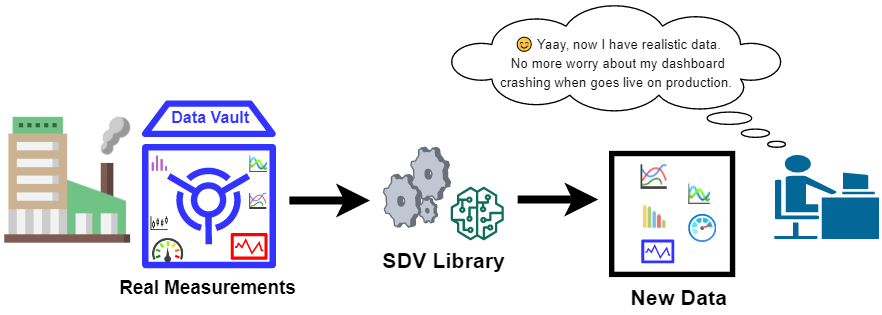

In [1]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAA3IAAAE7CAYAAACYH7NsAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsQAAA7EAZUrDhsAALPDSURBVHhe7Z0HYFTF9sZPeiV0CL2D9CqCgIAVFUWwiw0bis+CXdEH6MOu2J/t/VER9fmUJiqogIgoIh3pCITeAgRCevnfb/ZOcrPZmuwmu5vvh+Pemdvm3i2Z754z54QVGgghhBBCCCGEkKAh3HwlhBBCCCGEEBIkUMgRQgghhBBCSJBBIUcIIYQQQgghQQaFHCGEEEIIIYQEGQx2QgghhBDiR3bu3CkpKSmyevVqOX78uGrDK+qeUKNGDenWrZtZE7WMtoEDB5othJCqCIUcIYQQQogPgGBbtGiRev35558dirWuXbsqEWZl0KBB5lJJHO2vRaFGi7zmzZurgmNR4BFSNaCQI4QQQggpA1q4QbShoA4gpOwFlrai+Qpt3bMKRqvIw/kg6rSw8+W5CSGBAYUcIYQQQoiHzJo1S2bOnKkKBBSAUNKiCaUy0dZAFIi7NWvWqHYIu8suu0xuuukmJSwJIcEPhRwhhBBCiAsgiD7++GMl3iCU4B4JURQIws0d2mqH8tFHH0laWpoSdffff78MGzaMljpCghgKOUIIIYQQOyDYYH177bXX1HKzZs3k5ptvViWYLVramogCUQdBqi11hJDggkKOEEIIIcQEom3ixInKelW9enUlcmC9ghUrlIClTgs6CFaI0wkTJlDQERJEMI8cIYQQQqo8EHCjRo2SFi1ayMKFC2XKlClK7EDQhZqIA3CphHURQm7Hjh1qnh/quH64kRJCAh8KOUIIIYRUWRwJOLRB1FQVYI2DYLUXdK+//rq5BSEkEKFrJSGEEEKqJBAqcCeECyVeq5J4cwWELO4HrHUQdBC3oWiVJCTYoUWOEEIIIVUKRKHs3r27mvt23333VTkLnDu0hQ73CSIX9wrzBgkhgQUtcoQQQgipMkCQwNqEFAKhOv/N1yByJ+5ZzZo1lXWuslIuQFgi0iZeMX8RAhxFgzas0+ik7FZ03/U6fA6YgoEEKxRyhBBCCAl5MMgfPHiwGuiPHz9eCRPiOdpquWjRInXvcA/9Cd4nJDPHKwry4FnRAgzWQ0/SQdiLPhwTohBoUQeRp4+HuYKEBDoUcoQQQgjxCusg2H6AbF8HGCRrq4ceNIOKGiyjvwhogiEPrXDlA9a5sWPHKlEH65yvwGcGaRAwL88q2vAZwfuFAoHlS2ugtuDhfPpzC6EK8DnFuZB+An3wRCwSUtFQyBFCCCHEIRjoWq0iujjCE1GGgXJKSopZs6EtIHqgjldfCjz0F5Y4JPTGgF0LSlJ2IIYhjMsr5vDeaPGGZZ23DwJKi7fKAH3BZwUF/QPoC/qFPHuV1S9C7KGQI4QQQohCWyT0wBp1gAG2HshqsVXewSyOD6FotYagTVv6cC5dyirscDyKOP+Ae4v3Rqdt8PTe4j2HOIJ7Jt5zvDc4DgQcSiCirYR4xYMIfPYRKIfJ00llQyFHCCGEVGEwIEcCaAxUsQyGDRtWQrihVBQY3KMvumgLHgb5sAChb56AfSHiMNiGBYn4Hm/EHN5XfM7gmgkxh/cFYqi8DwQqGnyu8HnCteB68ZlE5NOK/I4QoqGQI4QQQqoYGEgjhxoGpNoqol3aAs0qooUdrCGw5GDwjD5CCKC/jsD1QVzAkof9iP/QYm748OEO3Szx/iFSKD5rsOxCvKEEu3UUnzGIUlwXHjZA0CEADAUdqUgo5AghhJAqAgQRLAl6UI3BJ0qwWEUgCiDM0H/M3cOgGS569i5uyHuG4Q2uN9gFQzCA90QLOXyeNBBwEDv4rOF9sq4LJfB5xPXBLRgi1d8RPQnRUMgRQgghIQ4EDQbVeEXYdgw2YdUKZpEDSxBEAoSpVdDh2jCwxrUGm9teMIP7j8/YqlWrlLUKwVCOHTum3g+sC3W0hQ4F+fYmT54ccNZtEnpQyBFCCCEhCixYGFBD1MDNEANqZ+6IwQquEdelBR3q9pYhUjHgswVLKUQNPm8Q1FXN1dD6ecRnEIKOVmHiLyjkCCGEkBADA2nk+sJAGvPf8BpqAs4ePYDW1jlS8eBzB/GCUtWtUXA3xX3AXM0ZM2ZUOUFLKgYKOUIIISSEgMsh5ivBrQ1uXrRMEVI54OECBC2CocBKTFdL4mvCzVdCCCGEBDmYo4RAH7DCYRBJEUdI5QErHNyakTIDD1dgGSfEl9AiRwghhAQ5cGnDQBGDRszJQYAJQkjgABGH+aqcv0l8CYUcIYQQEsRAxCHxNVwpMS+HkRoJCUzwgAX5GynmiK+gkCOEEEKCFC3i8Kcc1jhGxyMksIGAQ0RLBEDhnDlSXijkCCGEkCCEIo6Q4ARibtasWSrnHqNZkvJAIUcIIYQEGRRxhAQv+P7CBRqBiWCZI6SsMGolIYQQEmQgR9yOHTvUnDiKOEKCC3xnEfwE318UQsoKLXKEEEJIEIGBHyJUco4NIcENXCwXLVqkXCz5QIaUBQo5QgghJEhAbji4Y910000q2XdFADewNWvWqGXkp+OcHkJ8A75b+D5NmDCBKUNImaCQI4QQQoIEPMHHnDgIOn+D8yBU+s/z50jXNgmqLS09T47n1FX9uO+++2hFIKSc4LuEByWwyhHiLRRyhBBCSBCAp/c1a9askBxUsA4s+v5DGX9rU7lsYB2z1cbO/Vky4cMUWbQ+Xrl3Mm8dIWVHu0pjziut3cRbGOyEEEIICQLgSlm9enW/izgcP23bF7Lqkx6lRBxo3iBWPnqqnUy+K05FznRmHczMzJQ777xTFSxb2bx5sxKAS5YsMVtCF1zjkCFDJDU11WwpBvfhggsuUK+hgH7Pp02bVmLZG5555hlVykNZz10ZYJ4rXJYrylWahBYUcoQQQkgQADdHf8+jgTvlmt+/kilPtTVbnAORN2FULRk1apTZUpK4uDiZNGmSEnorV640W22D7MmTJ8vDDz8s/fr1M1tJVQUCF0K3skR9ZZ8fQMytXr3arBHiORRyhBBCSIADgQXXSn9HqUTQhdfub2nW3HPf1Y1k5+bfnQ5Ca9euLTfccIOysGiL1PTp09XriBEj1CsJTSDk3333XRk5cqTZ4hlPPfWUKlUJzDXVAYUI8QYKOUIIIaSCgOBBuHFnxRnYD26V/pyPBstZypalMrCHLYDJ/ZP/lkFj1qqi+ejbg0VtmCsH7r+mkctcWBBsmPszd+5cJeamTp2qxB0G+kC7WYaFhali71aHul6H7bQbItqtrnOwqDhy47SiXRkfeeQRp+fDMfU6fTztqqetNvZWHNSvvfbaMrtI4r131h9X12/dVl+bXu/oOhyBa0DfUeyPr/e37xP20etQHLkw6num11n30efBNuPGjZN58+ZJ//791Tb21+XpdeB4+nN0yy23SFpamrnGhvV6XJ0feHJ9vgT9wYMaZ7j73XC1LwltKOQIIYQQH4OBF1wh4XaIeWQIUoIBIVIHDBo0yGnRA8cWLVqo/SZOnCgff/yxzJo1S633JxBymP+mwfLP73SRCbc1ldVb0s1WUW0zX+ggP6+0DZS7tUlQFkNnQLAhgfknn3wi1113nXKn1C6VGEjDzfLtt98WxF7btGmT/Prrr0ViAgPqvXv3SkZGhlp/+eWXy5dffqnWnX322bJ48eKigf2CBQtkwIABRQLRGQcPHpRq1aoVne/rr78uMYCH0Dxy5Ig6J3j55ZfVMXFsnANgP1hRrHUI7aZNm6q6N6A/KM764+r6sV5bOpcvX64+N+iD9TqwX6NGjdR1OOOLL76Qf/zjH+pz265dOyVc9HlRsKzFDM731ltvqb7i2Hi/cC7dD0fY74P3G+87gPstBCiOY+9q6+l16M8R3HWxHa4F16Rxdh/xvtqfvyzXV1509Fd81/GdR/AT/Fbo3wN3vxv69wW/GdgXx6DAqxpQyBFCCCHlBCIIgycMpPTAa/z48SoSXdeuXVWofkR4XLhwoSrHjh1Tg0RdEHpcr0NBnjgEQMAygo9AKGHAVmHkidzdrZXk/h0tg3rUkG5tE1XzzRfXl4IjERL/dzW58YyGqs0TIA5g8cC9GTNmjNla7H6nB/AYsEPUaNCO9dgOg3UMxjWnnXaasrrs2rVLDbI3bNggvXr1Mtc6p379+nLVVVep5Tp16khycrJaBhBmOCdcQnFOWA61WIJVEedHP/B+w4IFUPdURDrCVX/cXT+A4ADbt28vsnSiP1jGdQAcH/fHmRiBkNHHw3kgkPWx9H3QohnH/Pzzz9V7CnAvPAGf+S9NEWq9LldY3w/gzO0SnwF81/T736NHDxk9erRaBq7uoz1lvb7yoKNV4ruOqLS4V8OGDSvxm4Fi/c2w/92AkB04cKDaF8fQAg+/RXiQgodBJPSgkCOEEELKAAZ4sLphoARLCAZPEF8YUGGAhafhEGCIRoe5Z5jfpp+g2+dfg2uVXoeC7T/66CO1vx6wVWTC4PwDUZJ/0Ch7YqTgeMmhQu7fsVKQFik5m22D8OPp+R6FTW/ZsqXaLj4+3myxYXV5e/rpp5Ww0Vjd5fr27asG6xoMuDt06KAsURCATZo0KZNFTKMH+OinI7RwRJ8wnwnv9cmTJ1Udr56ISG9xd/0QWBA7EGjoO/qor+P6668vuq9o37hxo7pP7oDVCp9tLbxRsIw2rMPx4eKo133zzTfmns5BX2HRgyjW+9m7a9rj7v2wguvCMSGEAQQbrHcaV/fRnrJcX3nB9wLfcXzXcZ/xvbf/zUCxx/q7gd8H7IN9cQxcI4QgxB2EHo6F3ymIOlheSWhAIUcIIYR4AQZJcJnEoAhWN1jcMGBCO8QXBlQYYPkSXx/PERgMrvrblvQ7LDFfJKJAksf/IGl5ueYWNm7/ao1MXb5HIurnqPrMRakOB5megAE2XNe0G9sbb7xhrrEBCw7c4LAOg08ICivavRJuZHgf3Fl4XKEH/7BsOUILx5SUFOWaCYsNzrls2TK1vjwi0hnurh/iEZY23EP0HX3U1/Hpp5+q/XTRbpPugNCGsMAxrftjjiOOjwik+Kxrd8d77rnH3NM12BfHwD54v60upI5w935YgYDDcbVQ1SJQ4+4+Winr9ZUXX3/H8R5CvOFBEq4Zwg6WfvxW4eETvAcg+khwQyFHCCGEeIBVwOEJNyxwsLpBvPk7mmRFoQZ+X+yV8BoFEtv/lLz2cEtpcc0fMva1v2XihykyeMxa2XUqQ668I0GiWuco0bdgdW65rh+ulHoAjgG31bUSYECOgTlEHwb/VmBpwvsCNzpPrILusM47wzkxN8rq2gfr0DvvvCOJiYlKaOCcsIiVV0S6wtX1Qzxibh4eKGj3TIDrsM7rgjXMWS47e3AdcBPF/jgvgPXMGmjkwIED6j3T98gd6Ls1EAuEV/v27YssaM6wnweI67D2Q4P7gO8lPj8ArpZLly5VyxpX99Eeb68vGMBnFRY7fF+0mybEHAVdcEMhRwghhLgBYg1PsbWAw2DI34m5KwM8vf+/79NlzVZbcBPMiVs9tYc0S46VQqM+/ramKthJjWqRtvXPbJGxDz1VylXUU2AhgqVEu/F16dJFzRHTwg7iBANyWIngsor5dXpADiCwILSsc7ww6C9rBEkcC+6KEBjaBfShhx5SrwAWMAjNevXqqTq2w5wkf7hVAnfXr0VXnz59SlgErdeB+/rSSy8pN2AtSN2BlAGwhuG82B9iCkFBcD7MP8P5cL/hpnjhhReWsIY5Au/zP//5T7UPjod+DR06VLXr9xCfAR1QRWN/HRBVuh9WUEe7dt3EnFT0UePqPtqf3931YRt3bqGBDizoEG9WQYeHVAyOEnyEGW8gfpsJIYQQYgcGNhjgILw+BocQOqEO3LCGDT1HPhnXqCgVgT2wxEHEVW8+VIncygQDa7jfWYNgILADBuKeuBISUtXB7xseTCE4ClwvK8KVm/gGWuQIIYQQB0DQwF1LR4arCiIOYBA3a858ue+9cOVK+fG3B2XRyuNFBW6WXW7aLF0H/aPSRRwsKpgjBxc8DdpgNfPHnDVCQhG4RsPLAAF84HlQ2d9r4jm0yBFCCCF2QMTB3QgDG7ggldV1MNjBk3oUDPI0GPTh6X1l3xO4Tl599dXKNdNRSHpCiPfgu418dnAhD0X38VCDQo4QQgixQBFHCKnKwCIHl3KKucCHQo4QQggxwZw4uBYhEiBFHCGkqgJXcuScg1t5WdOLEP9DIUcIIYSYIAccnkbDlZAijhBSlYEbNZLfY54wfw8DEwY7IYQQQgxggUOIdgg5DloIIVUd/BYivQbyz5HAhBY5QgghxADz4vAnEYKOEEJI8Xw5CDo+4Ao8aJEjhBBS5YErJQQcXCsJIYTYgHsl5gxD0JHAg0KOEEJIlQch9hGlEoOWqgBC9yNfHJJpW0lNTZVrr71WrScVA+71BRdcELL3fMmSJTJkyBD12SoryA145513lvq8anxxjrJSmeeuCGCFw+8iUhKQwINCjhBCSJUHQq558+ZmreowderUkB2AElHCBwIIQoiQsgIhh7QsJPCgkCOEEEIMqlqI7fr166s5ge+8847ZQgghpdFz4+CCTgILCjlCCCFVHoTYroqMGTNGvv76a+Ue5gxYdcLCwlRxZd3RLmaTJ08u2h5tzzzzTIm6Rrt3oh2v2rVQu9Hp/fAKnG1vRe+rzwNrI/pkrVtdR73pA46BfVGwLeZTWl39sB77OLs/1vvgqP+LFi0qWm/vQujsPcAxrG6Z1utFuf766+W9995T+cDs+6X3ff/990uc13ou3Q/03donb651wYIFZqsNnFffcxRsq7Ffh/NYOXTokLo+rHPkzvjJJ5843FffF2fHdfbe4BXvN67Vup+r6wtFcE8AhVzgQSFHCCGkyoPJ/FWR0047TR5++GHlYuloUI6BK9YdOXJEMjIyVNvLL7+sXh0xb948qVevnrL0ffrpp9K/f385++yzVf3pp58uOg8G1vfdd5+8/fbbah36gLp1YL537151zqeeeqrU9ni13x7ExcXJgAEDigbXmzZtUtYEax3vddOmTb3uA/jiiy/kH//4h3Izu/LKK2Xx4sVF9w3nwLnRB3twH/WxcK7LL79cvvzyS3OtyMGDB2XlypVqPfr40ksvFYkGb98DTb9+/dR7MHr0aCWuHfUL50VBn3799Vcl/ADq2Fe73uI99OZaUXR/cd0a7I++6HuOa8V5IZgcrXvrrbdKvB/4fEFQ4rhwhbZak7EuPT296FruvvvuouOOGzdObrjhhlLrgLv3ZuPGjepasQ731NX1hSoUcIELhRwhhJAqDwaFx48fN2tVixEjRqjX6dOnq1crGLBj8Fq7dm01aMdgGINYewGlgYUHlg+Ae4o6xCJo2bKlegUYpAO9Tu+j24FVKKAdx+vRo4eq4xV16/YatGNwjQE8BqCwqADUrQLE2z4A6/XgNS0tTXbt2qXux4YNG6RXr15qnT24h++++646FvrhaPCPe4v17dq1U2JCi09v3wNvgHvtVVddpZbr1Kkj559/ftE14D5qvLlWR/3VoI77gPUAYghC0ooW+7gPn3/+uTqOBsfSx23UqJHZaqNr165F14LPR58+fWT58uWqzzt27Cjqr3UdcPfe4B5Zr9XV9YUq+rexqrmfBwMUcoQQQqo8GLRW1cn8ejAKK5BVxOhBrVWA+QoILNzz+Ph4s8U12B4ugtge7mx4Rd2RpUCLDlhc4DKLaKQnT55UdbzqQbm3fbAHA/kOHTooQQBB0qRJE2XpcwTOrV0G+/btq4SFFYgFCCmNvuf+fA+8wdNrddRfXFfNmjXNWkm3RFhpce0An0NY5IB+n+HSiGN6QnJyctE9tAo99BfHst5fK+7eGyueXF8owkAngQuFHCGEkCoPnjRjjpIjYVAVgIUBViBYQzR6MLx9+3azxXdAQOFea1dBd2B7uAhq9zddRo4caW5RjBYdKSkpUq1aNWXZgbVm2bJlar0WIN72wRHa5RCfHZwD98wRcNXD/UWfMSiGy6kr9D3353vgLZ5cq6P+QkghmTSAaIJrIx4Y4F688cYbql2D/WEdwzrsh/fHkaXYHVpwAQgtfTxHePPeuLu+UGXWrFly0003mTUSSFDIEUIIqfLcfPPNau4U0hBUVRD4BANnzAnSYPCu3fgwOIbQ025l5UG7J2oL4Ny5c9WrbrcH7egb5pEBbUVB3xwBiwnmTyUmJqrBN0QbXOKsAsTbPjhC9wsiE+dwBYQF7iH6jgAzVuBeCEEB9Hrce+DqPYBIgSVJuwniWjBXzB94eq3oL/qP6wDaRVSDa9WiCtesXStxfXBv1e8prHI4j7v7qsF16/cQn5OlS5cq6yuEe4sWLYrukXWdxtV7Y4+76ws18J7//PPPVSbHZrBBIUcIIYQYQMy9/vrrVXauHISB/XwfCAa0QTBoF8SHHnpIvZYHnAv3GkEnIETg1om6M4Fovz1EBYKToH+OwCAdAgGBVwD6D6uJdfDubR8cgW3RB+vcOUdg7hbEA+4h3AchmrV4AHAvRHF0ba7eA5wf6xCkBPvCcgKhpcH14rzDhw9XQqk8eHqt2Ab9xzboE9xZteuhnv8HqxfWdenSRblEQtjZvx+4Vli/9H1wB/qFqJbYF8dH0BScD8J90qRJSgDbrwPu3ht7XF1fKDJhwgTlnkwhF5iEFcKWTAghhFRxIODw9B+C7rXXXjNbCXENoijC1U5HtgxlqtK1ElEeCngIMGPGDAq5AIUWOUIIIcQAYeo/+ugjZRWoyi6WxHNgtcG8Me0GGcpUpWsltgdbo0aNkmHDhlHEBTAUcoQQQogJBiyY1I8BDCO1EVdgjhSiHHrj/hesVKVrJTYRN3jwYDVvGA+3SOBC10pCCCHEDrhXYr7RwoULVVANQgipCmgRhzQMCHLC37/AhhY5QgghxA48hYZLEQY0fCJNCKkKwAsBv3mw8SBaJUVc4EMhRwghhDgAAk67WWLCf1WNZkkICX0wN7h79+5KxMEShznDJPChkCOEEEKcgOiVcK9EwSAHAxxCCAkVYHmDFe7++++X8ePHK6scRVzwQCFHCCGEuGDQoEFqsINk0hjwoFDQEUKCGfymwdsAydIxH27VqlUqZxwJLijkCCGEEDfgCTVSEsAyB9cjLeg+/vhjulwSQoIGBHHSAg6/Z1OmTOF8uCCGQo4QQgjxEFjnYI3DAAihuRHdsmbNmmpghAFSqIs65BK78847VWJoRyxZskSGDBkiqampZkvFgRD5F1xwgXoNdazXWpWu2x53n8ey8swzz6gSKsBdcuzYsUq8IcUKrG9awOE3jAQvFHKEEEKIl0DQwUJ37NgxNSDCwAgDJIg6zKXDoAnCDgOl8rBo0SJl9Zs4cSLz2hHiJwJBDOM7joAj+M6X54EQ9sUxcDx4DYSFhanfpBkzZqhIvHCjxG8JBVxowDxyhBBCiA+AaMMACRY7lDVr1phrRJo3b64K3JdcBRLA/hiI4VhWEaitfwi+UpnAAgKROmDAABk5cqTZGhhgEH7vvffKG2+8Ie3atTNbQ5OqdK2u8NXnMRDuJ34X0tLSzJqtrt0d3f1u6Dm71rm7zZo1Uw+csK9+JaEHLXKEEEKID4BQg1UOYguCDNY6uGDiSTjSGGBgBcsd2vTcFAQXwKtuwz4Qbdge+2F7PG+FiMNTdnfApRGujXgKjwJXR4DXa6+9VhUM6DBwRcGy3tbqSma/Th9Hc+jQoaLzWF0pra6Vehmub/o4Vhc47RaHdpzrkUceUXW0W8FxrO04hn3d2nfcJ30+e/c4bKvXWY+B64VFBn1wtq8Vd3233j+8om4Fx3Z0Hutx7dc5Q/cdr9jeuo91na676pcVZ58lgHOgn3q9q2Ppz8HkyZNLHUtfL46Hdt13Z+8TsF7DLbfcUkL82F+//WfF0TWh7b777pMffvhBrr76anV8R8dx1B9s683nxhX6IY3+LUCf8JuB77/1dwO/GSi6joLfjIEDB6p7jDqsbngQhBQqiEaJ+0VCEwo5QgghxA/gCTqehEPcYeCFQZW21qFgoIVBGl6t7XDZxPbYTw/A8OrOtRKDy3HjxskNN9ygjrtp0yZ5+umniwbYX3zxhfzjH/9Qx2natKka9L399ttF2/76669qWxzHft1bb71VJNbAvHnz1OA2IyNDCdh33nnHXFMSbAdrCY6D47/00ktF/Zk+fbp6xTHmz58va9euVXV7TjvtNDVY37Vrl+obLJ2wWur64sWL5eyzz1bbHjx4UBXd76+//rpINOB16tSpcuTIEbW+UaNG8vLLL6t1APtVq1bN4b72uOq7Fgb6/j388MOqru8f7tvevXvVvihYRhvAcdEv7KfXOeuDI3AftDgBy5cvV/Oi8H7b9wuv1n5Zsf8s4b27++67i947sHTpUuUKiPWXX365+sxgP0fgc5Cenu70WPp+PPXUUyXeJ7QB/T7pzybuKY6FzzM+155gf036+4Hz4DrOP/98+e9//1vKIueqP8Cbz40r8LAGYgwukfjdcPSbgYLzoFjb9G8GRBv2xXeSVA0o5AghhJAAB4MzgEGbMyBs8CS+V69eqo4BKQbQemAKywFEEYiLi5N3331X+vXrp+oYpGJAagWDVwx+sf/nn38utWvXNteIGgyjjuNAeDgD54QFBNSpU0fq16+vlnFcCDCIPBwDx8IxHREfH68sDnogjUEzBAvquGaIPH1dOP5VV12llnG+5ORktQwWLFhQ1G+A7TZs2FAkZFzta8Vd3zGYB7pP+vrRrvfF9tgXBctowzoAIQCRg3XW98gT9Dl1H7Zv3150LrRhgN+jRw+1Dq+o622t2H+WsG2fPn2UMNRAvOnPVsuWLdWrM5C6Q99bR8fS9xLgfcI1688X+q/FqaN+jR49Wi27w933wxmu+gM8/dx4Aqxy+I5DwBHiCRRyhBBCSICDATfcrFwN8CBs4NqFwaQnwAVMu4PBMqFFFgarsHoAiCist3dvKy8QZLBEemI5QH8w0MeAWouOjh07qjquuUOHDkXizBnoO6w+119/fdE1Q/Rs3LhRHcMb3PVdr8O9s0fv279//6J+YBltWId5XrA2oW9Y58pl0RFaVOLeQGjgmrW4wznee++9ovcUr6ij3R5vP0vugLjRx8L76Uz86/fJmTC075erY9lTlmty1x9fg/cbbtUUcsRTKOQIIYSQIACuU4hg6WjgDTBAhcuVJ8IE4gAubhBG2AdBHqxggAxrkD4ezqndCX0BRATEjrNrsQdWlJMnT8r69euVNU6LE0QG1W6VrtAD/k8//bTINQ0FbqbuLDL2uOu7XgdhZo/eF/fe2o+5c+cWiVGIOd3uzmXREbhXsDTiHLhmfVycF9Yr9Mt6bkdBQrz5LHnCgQMHio6lxZEj9PsES6Ij7Pvl6lj2lOWa3PXHH0DMeTIflhBAIUcIIYQEAZhDA6scBJ0jMA8K86G0yxosMnDrczZfB66UelD75ZdfFrlW2u+nxQeKr8AAGVY27VKIc8KV0xkYhO/evVtZmrCMPkHYnThxokjUuQOCD+fQLnGYl4br1HVPcdd33R9tPYRIA2jX+2q3VQDLqLZ42gfZgCUIQgL7eQo+B3BFHT9+fJHLH8D5ITBXrlyp6hDzEA2OPh/2nyXsgzlx2i3RWzCv0dNjWef54Z7gXmnXRt2vL43PK4C7JI6lwf2y7ov3SOPt90Pjqj/+AO8J8PQhB6naUMgRQgghQYIrqxwG+5MmTVIDTe1CBjc7R3OsYIWCtUe7+HXp0kW5v0HYYYCK4A8ISIF1EE0QE46OUx5GjBihXnF8WIUwn84Z6BNcKBHkBNeFa8VcOavFyR3oP+4H9sd1IfAKrrMsA3JXfbe/f/bnwfboN/bFeogEvG+4poceekhZmNCOgvdyzJgxaj9P0WIR89AgXjT2/YKwgxuno/fV/rOEzwmCo3hrvdTg/kBUeXIs6/uEewRwX4DuF+4ZjoVgLbhOjZ6PiH379u1bNB8Q2F+T9fuhRR7uib2wc9Ufd+BhgbdRLLWQcxfciBDAPHKEEEJIEIGBHgaiCEkeSmDQCxc2RC4MNoK57/4GwghiBveoLKK5KoLvNyyqzqzvhGhokSOEEEKCCIQaR/S9UaNGmS3BiR7cA+2eWFFBJcpLMPedBDba2q4j1RLiCgo5QgghJIjAXDVEtdMlWMH8Lbgdajc3uLA5CrwRiARz30lgo1OMUMgRT6BrJSGEEBKEIPkv5stNmTJFJQ8nhAQ/CGoEq5yrnJGEaGiRI4QQQoIQJA8eNmyYDB8+nHmnCAkBEMwHqQd0wBNC3EGLHCGEEBLE4Am+tsxhmRASnMDKjocysMjVqFHDbCXEObTIEUIIIUEMBn5IGo3gJxMnTjRbCSHBBFwpkR4ClnaKOOIptMgRQgghIQAEHZ7oIx8WrHN0zxJlqRw4cKBPk5mTkiCKKu4vP2/lA99bJPzn3DjiDbTIEUIIISEA3CoxCMTz2cGDB6un+1UVJFPu3r27uid4ZXJl/4DPGOZo4vPGe1x2YE0/duwY57oSr6GQI4QQQkIEWEUwoL7vvvuUdQ4DbJ2XqiqAYBFjx45V4q169eqycOFCZeWg0PA9EB/4jMGtl/e47OA+zpgxQ7lU0nJMvIVCjhBCCAkxJkyYIKtWrVKJw+GyhcFiqAs6uFFqt1IUWCeRiwuviO4JcUeLh2/A5wn3EvcZYg73GC6sFHOeg4cO+ExCxOH+MVARKQsUcoQQQkgIAuscxBsG27BMhaKgw2AYAV5wbRgIQ7Dh+qyDYgSOgOi46aab1PUzIEzZwb3V4gOfKX2fcY8xVw73H2IOwoQ4B59b3Cc8aMG94vxCUlYo5AghhJAQBoNte0GHeU2wYAUruB64UOJa4NoHkYZBMQSbs4h/WIdtUThvznswHw73DXMwIT5g7bQH91iLOXzGIFhISSB4rfeRIo6UB0atJAHJnDki+/aZFeITevQQ6dXLrBBCqiwYbGMwOWvWLCV6LrvsMjWnLtAHlBBv6DP6DxGGeVlw64NQ9SZcO46Da16zZo2al4RrJ87B/YIlE6Jj/Pjxym3XHfh84b1JS0tT2/Me2wLw4OED7iMePDDNAPEFFHIk4MDfCAg54nuMv8FyySVmhRBSpcEAHQNuCCOIGgRagJUFJVBC9i9atEgNgLV4QwATiDBdygMEBtwscb0QKI4sTFUZWNN0XjPcd7wH3twj7I97jGNgP1iEq2IwD+3+i/uI7xXuCT9rxFdQyJGA4rPPRF591awQvzBtmki7dmaFEEIMIJIg6mAtgHgCVmGHZQxC/QmEJQQl+oD+4BX4UrzZg/PAcoRrxnVS0NmA2y0EB0Li4/6glNV6hHsMqyneW9xbLMMiFerg84z7CAGHoTZe9ZxCQnwFhRwJGDZvFhk50qwQv9GggU0wV6tmNhBCiB0QUSgQdxiAazCYhwsmCpbtRQ/cHR1ZXTCYh5udRos0+1fQtWtXdVx9nopw+cT5IVwg6DDYhqCritYjLeAgQnzt/qetv3CPxb3Vgi7U7jPuIa4VBd8HXGd5hDAhrqCQIwHByZMi110nsn+/2UD8CsZeL79sVgghxA0Y2KNA8MBVDMLMXpx5A6xsWgxaXyvbGobBNwbdKSkpVcZ6pC1HEFlawEHM+Utg4RwQiDgfPj+4x7jXCJISrGIH3wV9D/H9wLXgunxtQSbEHgo5EhA89BCeiJoVUiE88IBNPBNCSHnR4s4dEAfBYIGxWo8gLjAoR8COULIe6cAxuFYIa205qshrxPlRtDuvFvNa2AUq+Kyjz3iwoR9uaOsbSih9TkhgQyFHKh138+LatKEbYFlB5M8DB8yKAzhfjhBCnAPrkRYbsNJBaMDKApGB5WAD4k27/UF8YN6jFh+VCfqiRRH6hnsNtKhD0VbcygCiDeLNKtzQH2v/gvHzQIIfCjlSqbibFwcR9/nnZoV4De7v6NEi6elmgx2cL0cIIZ6hBRAG8hAasLpgAK+FXSACIQoRovsOMAcRwg39DlTLEfqtRZO+3xoIJvQbryiwmPoiEI92FdZCDXUULGtwHtw3CjcSKFDIkUrD3by4xESbyGjY0GwgZeKbb0QmTjQrDjD+HnG+HCGEeAEG+Foc6WAwWljo4u8on/ZAcOionyhWEQKhqQVIsLr94Zog8LTI09frCNx/d/Pt7EWaRlv+cJ+0WNdzOAkJNCjkSKXhbl4cxAVEBik/E9zk5mN+OUIIKRsQFtp6owWUDgIDEQC0sNCvsIq5ExqO0MfWIkQLG10A5mrhPCg4v+5DqKLvBbDeB411vb7/VqxtoX6vSOhBIUcqBXfz4q65xib0iG+A9fOOO0S2bjUb7ID18733OF+OEEJ8AcQDCkSFVXRZXQQdoYWEI0FijxaDWohgX0dChRASulDIkQqnPPPi3nwTOVrMih2IEH3PPWbFS3DcM88U6dnTbPCSFStsc9GSk23HatHCXGGi13fqJPLaa8jFZK4oJ/p+2F+7o+txOl8OvwBhIm3b2sQc58sRQoj/sBdpEHkQe86wtxJRrAUG9sLcavnToA3vlxXtsqlxlnuREE+gkCMVSnnnxbkScmDIEJEnnxSJjTUb3JCVJfKvf4nMnWsTMWUVcvjtvv9+kb/+EnnqKcxHMFeYOBNc5cX+uO6ux918uaFDbW6YhBBCCLEBQYb5eHhFgQutM1zNjdRpFuzRllVtVdXusYS4I9x8JaRCgIhwlfQbIsKT4CYQLsuXFxeIFgABM2+ebbkiwcNRLZr+/NMmqDQQebDIAVjJKhPMg4NYcwbm0UHsEUIIIVUVWNtef/116d69u4SFhalXRPpctWqVElmTJ0+WhQsXyrFjxwT2EGuByHNW7LfdsWOHOg5yFOK4M2bMUEFp9HkHDx4sSDRub+kjREMhRyoMWNqM3zGnYF5cWecZQ0TBEgasQgqvsND16lVcYMUC+F28806b+ANwO0QqHf17CfFl3Q8CyPjNdYoWaatXlxSrf/9ts9TBrbJVK1sbjoPjWY+vxR6YNcvWhr7ra0G/0D/7bTXurkfz4IM291VnvPKKzQ2TEEIIqUpAbEE8tWjRQsaPH6/mIU6ZMkUJOC3SkFMQidNhPSuvi6uOijlhwgR1XFj7cB6IO5wX4g4ir2bNmjJ8+HC38yZJ1YNCjlQIEAbukn6XN7hJly62OWpaSFndDK3AFRFCyRV6TpsVJNaGRdFeGGkg0iDWsN3Ro2ajwW+/2V4hNvGbDxEHN0j7RN2IHOlKKPoKzIGD5RNurI7AHDpcJ9xgCSGEkFAHFi8IOBQIKVjG0AZxBUtcRbs5QtzhvDg/+oH+wPoHgTl27FhzK0LKIOQy8rJk36mDQV/2Zxw2ryh0yM3NlczMTDl16pQqGRkZJQrWVwYQBK5EGgQFrEDlpWZNkTp1zIoBxBxEHebN/fqrzQUTLplg1y6bqHr3Xdt6APdM4zdTtWvxhTbs97//2UTikSNi/Jja1tljda/U+0P02btVrl1rE3GwIOLYP/3kWAB6i6vrsQfRKRHF0hlbtvjmPSGEEEICGS3i4OYIyxusbnBvDCTQH/RLW+pGjRplriFVHa+Dnfx5cK18vsVFQqogITYiRp4980GzFtxAoOXk5EhqaqohBI5KVlaW8q0OD7fp9Ly8PPWECS4ADRo0kISEBImOjlbrKgJf5otzFTQEogkBRyC2sJ01cqS9hc3T4CD2Vj1nUSk1+jw6OiXcKq11e1Glr0ej+wCL4TPPlAzeoq8Pbpp6O/v74e567IGbpZO51wrmlyOEEBLKIKk73BYh5IIheqR2/wyW/hL/QtfKIAci7eDBg7J582b1mp+fL1FRURIZGamEHEpERISkp6fL0qVLZf78+bJ9+3bJzs42j+Bf/Dkvzh5YyiDiNBA+ek6ZvZukO/Qctf79S7tmukK7V0JsQcTZu1UCiD0cG8Uq4ioDuFhCnDqD8+UIIYSEMph3BkEULKJIu3lyvhwBFHJBDEQbRNmBAweUxU1b4OyBkIuPj5e4uDhlsVuyZIlyH4AI9CeezIvzVmC5Am6JcE/Eb1yDBjZLEwQVhApcI62ula6AAJwxw7aM7a2ule6AWNNWMBzD3q0SFjN9bO3yqV0rKwPMl3PlQsn5coQQQkIZuC1CFAXL3DP0s3r16moeHSEUckHMtm3b5MSJE8qN0h0Qc3CpBBCA69evNwTKcrXsDzyZFwdrkK+STyNICNwAwemn21wRMQ8OXHCBzRUSAk0LK0fs2WN71ZY9CDcdql/Pa/MELdpgyYOQhGDr2NHWBiGnzzN8uK2fOqqlI7At9gFamHqKPo87MF/ugQfMigM4X44QQkioAksc5p299tprymURrouBCPqFtAQIfBKofSQVD4VckJKSkqICm3gi4gCEHCxyGgi4tYY6gUXPH5Y5d/niMDcLAqKswCVRuyeiXHmlTWhBNEG4gaZNba9623PPdS2EMCcNwg0iFEFTcDwcF/tinado90qNFpYAr40b25ZhjcSxHVkldQRO9Bf99rYPQF+PJ5EwkaTdRQ5T5pcjhBASsiBCJAKJwLsJYg6CCXnkKtt9EekIYIFDf9AvpENAG5OFEw2FXBACEQZLnDcCDG6XmDtnD1wsERzFl7ibFwdx4Y8AGogCiUAfWjQNG1bSlRLL2kUSljlY6LDtrbeWdJuElRDWPd2GV+yH/SHuYJ1zhdW9EvtClGlwPlgqrUIPQUl0Djw9pw4WRIhhK88/794F09H1eIon8+X27TMrhBBCSAgBV0UdGRKCCXnkEO4fBcFQJhp/lGfNmuU3cQeBhuPjPBBtyB2nLXADBw5U4zWkI2CAE2LFZ1Ers09lyYbvVpo1Gx0u6iExCeao2mD7kk2Stq84vnpyhybSoGMTs2YMrPemyo7fiiMrRMfHSMeLS4bdW//tCsnJKA7U0eLMdlKjUW2zJrJ//W45sGG3WROp3rCWtOx3mlkrJpijVu7Zs0cOHz4sBQUFZot7sO3JkyeVO6YVWPTOOussadWqlQqQUl4wL27kSLPiAMyLe/9937lUEt/i7v1r29Ym1AkhhJBQB8IOBSILBd5QAFHAYRVzFCQF7Y4ShUMA2otAHBPpD6yukhCR+tiYv0frG3GF74TcyUxZ9dXvZs1G9yv6Sky1Yne+zfPXyrFdxWEFG3drIY27F8dxP5pyWLYsWGfWRGISY6X7leaEI5NV//tNstOLLUhtz+4stZrVNWuGyFm1Q/asLvYlq9m0jrQ7x2ISMQlmIYf5bd64VQJtxYMrpT1tDHV15plnSkxMjNlSNuCSCBc9Zy6VmBcH61N5XCqJ/4FQcxWkBpFGy5u8nRBCCAlGrMLOKsywrIWeKyDUrEIPQk0LNwYwId5C18ogpCwBSmCRc+ZCCeueL4Ke+HteHKkY3M2X++IL166zhBBCSKgCsXX//fcrN0dtsUOBkINtxFqOHTtWqg0C0Lofgqxgjh5FHCkLFHJBCOa7eWONA5hPB9dKR8C6542bpiMqa14c8Q/u5sthPefLEUIIIc5x5GJJiC/xmWtlfl6+pO09ahzRqJhHrN6olkRERtgqBicPp0luRo5ZE4mrHi9xNWwh8QHmvqUfPmHWDMESGV5i/hvAPLqCvGLRkVg3Sc2l02QePyWZaRlmTSQqPlqq1a1u1ooJdtdKbwKUQKTBrRJPixxZ3jA37qqrrpJE+D6WAc6LC004X44QQgghJHDxmZALNoJZyK1bt05ycooFsTuys7Nl3759Khm4I5AsHBGZdJ45b+C8uNCG8+UIIYSQwACumPDI0kFSnKGDsCBxOIOlhDYUckEEXCCPHDkihw4dUn7WnrhX5ubmSmpqqhw4cMDpPLjk5GQ599xzlaDzFgziXblUIow/XSqDmzvuEFlZMiBtCV5+GXMGzAohhBBCyg28qJCOQAdWQbEHaQmsQNytWbPGrBWD+Xc6qMqwYcPo8hlCUMgFCbt27VKiDC6SEGTuRBzeVljt8KWG+HPliokISshVEh0dbbZ4hjtrDVzvEOCEBDewurqyusHqis9Cw4ZmAyGEEELKBKxuSEY+c+ZMVYdY0yJMF0+xikCURYsWqXYEV0GePPvUCST4oJALcCDa9u/fryxqGnciDnPiYL2DiENxJeIg3mCNa2iMwhFExVPczZ8iVQvOlyOEEELKByJhjho1Sj1gR2RM5JHzpfUMY0KcA5EykSphypQpStSR4IVRKwMYiLiDBw+q+W0Qb7rYU1BYoKJSYi5cenq6cqXEfnh1FxSlSZMmUrt2ba9EHHBliSNVjy1bRL75xqwQQgghxCtgMYOIu++++9QyBJavXSBxPAhEuG3CxRLnI8GNW4vcydS9kpF22KyJ7Dq5T1YeXm/Wgpeo8Ci5uHnJiT21G7eTyOjiBOaVCd4WiLLNmze7tMBhu7S0NDl16lSRmIM1DsuugHCrVauW9OvXT+rWreu1kOvVy1wgxKRHD1t0UkIIIYR4B1wqBw8eLKtWrfLKfbKswCo3duxY2bFjB10sgxi3Qm73+sVycHvpCZahSMeB10pcUh2zVrlgftuePXuUVc2VyILVDuZxJJ30FAhDWOFgum/RooXXIg5QyBF7MOf6lVfMCiGEEEK8AgIOD+cnTJggN910k9nqW+BeiSAqsMzBKgdXSxK80LUyQIFFDUFK3Ims3Jxcp9EoHRETEyP169eXLl26SMuWLcsk4gASfBNi5dprzQVCCCGEeA2scghuArfKmjVrKosZRBdcIcsDXDU//vhj5UqJB/g4Plw4YZUjwQ0tchYCySKXkZGh8sUhWbcz8NYdTT2q5sNlZmWarcXA8gahhoKgJnFxccqNsm3btkrMlQdEMkR+uC++MBtIlSU52RbVkikICCGEkPID4QaRBWGn0wlgfhssdkglYAVtWId9rIIPljcIOBxDA08siDgEUaE7ZWhAIWch0ITchg0bXM6P0+6X+LI6ehsTExOVCyUEHF7r1atXpsAmhBBCCCGkcoAYgyhD0WINr5haYw/Emg6SArEGoedIAJLQgELOQiAJOQQvWb9+vURERJgtJYE7JebPITk4ApzYA7HWrl07GTBggNlCCCGEEEIICRVomglgkA/OERBxmAx7+PBhhyIOaFdKQgghhBBCSOhBi5yFQHOt3Lhxo3KZhHslXnVBhErklsvNzTW3Lk2dOnVUQJPWrVubLYQQQgghhJQGbpswEmjgumk/jw6BWEhg4QMhFybhkVHmcuVTWFDgcL6YsQYrzWXHBJKQg9UNgg35PeAmCdGGLxjcKeF26eptgztm+/btpWfPnipKJSGEEEIIIRrEV0Aky5kzZyoRh7onYK4dCqJe+jphOfGecgu5mMRa0rzXpWat8oHQQbGnMDvNWOk6kXkgCTmQlZWlEkPCTRLibcuWLU7dLa0gqAlEXJMmTcwWQgghhBBCbNa34cOHK6sbgqNocQZh5igoig6yglcIP0TSxLZTpkxRETBJ5UEhZyFQhBzEGp6MbN++XdXhWom8ckhH4E7IIe9Ip06dpE2bNi5TFxBCCCGEkKoHxBdEGZKBOxJu7oCowzHgKQbPMVJ5UMhZCBQhZz8/DsDVEkLOWfJvbJecnKxEXOPGjSUqyv/urkhN8vnnIitWmA2kStK2rcgddzCPHCGEEBIMwJqGfHLlSQgOEYgE45gGRBfLyoNRKwOMzMxM2bVrl1q25pBDdEpHmhtul5iMes4556inKk2bNq0wEYck0BRxZMsW22fBknOUEEIIIQEKRNzrr7+u3CtnzZpltnoGLHkQcCjDhg2jiKtkaJGzEAgWuRMnTsjmzZtLJe1GlMoDBw6UEnNJSUnSq1cvadasmXKltIo/fwILzMqVZoUQA1jmPvvMrBDiA7b+vUNSjx6TPqf3MFtck5GZJfFxsWaNEEKIMyZMmKAscjpSJYwBSBzuTJghKTmKBsFOcAwKucqFQs5CIAi5kydPyqZNm4qEHN4eWOO2bt0qOTk5qs0KrG9I+l3RaQbgRpeeblYIMVm+3FwgpAys37BZvvtxgfr9+3t7itkq0qd3D7nx2ivMWjHf/7BQsnNzZMfOXbJr917jtzJHWrVsJjePvEpq16ppbkUIIcQRiMcAC5u9SEObFnjWlAMQehB8KBRwgQGFnIVAschByCGFgBZxe/fudRoWNioySs466yxp1bqV2VIx9OplLhBigUKOlJXfl62Q/379jcMHVsBezP248BeZMXuu8kIoMH4rtS8CRGBkZIScd/ZZcvEF55ithBBCSOjBOXIBBsQbcsYh4Mnhw4fVfDlrgkZ7EhITJCo6cPL4EUKIt7z3f5/K1M+/lmbNmkuHDh3N1pIsXbZSPvn8K7UM0QcR17xZC2nfvoMScdqtHJF9IQa/nTtfuWUSQgghoUq5LXLhkdGSWKepWat8srOylBWrFAW5xkrXyQ4DwSKXnp6uolOmpKSo63B4LRrjnWvZqqV0795dateubTZWDM4scj16iPTsaVZISIIAN87mR9IiR8rCmLFPSJs2baVHd9uPxy+//CwHDh4oYWmzByLujDP6qOW9e/fIr0sWq2WAP2rY7/67b5O2rVuqNkICEeSHdTMMIyEIAtPFxcWZNULKTrmFXCgRCEIO1rg9e/bIb7/9ppKAuyIhPkF6nd5LWrRooaJXViTOhNztt4uMHm1WSEjy3nsiH3xgVuygkCNlAUIOlrjOnbqoeo7xO/j993MkKytL1e2xijhw6PAhWbhwfpGA01xx2cVy9sB+Zo2QwKOiApSRwGLx4sXSv39/s0ZI2aFrZYCB4CXIB9euXTuJj483W0uTkJAgbdq2kYYNG1a4iCOEEH8SbfwODjxrsPTvN0CGXnypXH3VtapccP6F0rv3GSVEnBXrkBhRfDMyM80aIYQQEnpQyAUgsbGxctppp6noQE2aNFEpBjAo0esaNWokXbt2VdskJiaqdkIICSUQEa1Ro8bqoZUGbS2al3aVrFGjdITK3Lxc2bpth1kjhBBCQg8KuQAErhYQaFrMdenSRTp37qxeUSDiYLGDwKNbBnEHXHSdRQIkJBSABc8RJ06eNJcIIUENhzqEOIRCLoCBFa5BgwbSoUMHOf3006VPnz5K2DVu3Fi5YAYj+347LFv+lyKFBZzcXVFs3LhRjjF6HwlQkMTbF+D3slDNkrMRZvw7eOiIzJn7k9lCCAlaOGQIKtIyc+SNBWvlwa9+k3Mmz5bWT06TyLveLSo9n/1KtWM9tks5yoduZYXBTiwEQrCTYKGswU7m3/WHFOYXyqDXeklkvM1dlPiXmTNnSseOHaVNmzZyIk/kWK5IbLhI/RhzAy9hsBPiS5B6YMOmrTJ06DCnljVPsI9caeWGay+Xvr0ZTpcEHo68ap588km5+OKLzRoJZpAH+IorivNfakI12AkE3OuGMHtjwTo5nuEi6roDburbTv45tJc0q1XNbCGeQCFngULOc8oq5H687Xf1OvjN3hIZF6GWiX+ZPn26dOrUSWIat5G1J0R2ZRZKrWiRPjXDpEW89/4qFHLEVyxYtES+mvmtDB58jtSrW89sLTs7dm6XZcv+MGs2YKWDde6Jh+6Rxo0amK2EBAaOhNyUKVPk5ptvNmskmNm+fbu0atXKrBUTikLu6W+Xl0nA2QNBd9/ZXaRL44pNqxWslNu1MiwiUuJqJAdMiUow3vjopNIl0nkESFKB2D82MOp5mfnKSkf8AxIkH8spkB8P5sv3B/Jl/YlCmW8sf7M/X3ILCiVHTkim7Jc84/9W1zRC/AlcKuH2iLQDvhBxAIFQGjZspAbH+pMMERceHi6ffTXTbCGEEOIrYIWDq+TTc5aXW8SBj3/fLGdPni2/bN1nthBXlNsiF5NYS5r3utSsVT6pqamq2FOYnWasXG/WHEOLnOeU2SJ36+8YWRVZ5HZ+v1e2Tt8ltU6rLj0f7GBuRXzJf//7X9lTt4Ok1GwjHZMipGetCPluf66sOJ4jL3Y/KhK7WE6GbZL6MkDqyukSK7XMPR1DixzxBRBxPy5cLEMvLp9LpT3IQTf7mxmSl5enRJwVuliSQIMWudCmKljkLn9vnsxa7Z8IwSvHXUnLnBsY7IRULPibZXl0kJ2Wq+oZh3wT8ICUJq+gQH4/nC3VI/JlUN1w6VUzXC5pECaZ+fvls5P/ku8K75Il8op8L3fITvlRCiTf3JMQ3wEL3Na/d8jSP1fKt/PmK7fKNq3b+lTEARyvXdvTJCLc5rpd/HNTKP/9erZ88vlXsuCXJaovhBBCys4nSzf7TcSBEe/ONZeIMyjkSOXj0iZMyktqYaycMvRyu/gwaZdkG9zWSzwsQzp+Ltl1P5G64RfLafKwsV2E/FY4VXbJUrUNIb4CIu6hJ56WyW99IJ989pX89sdKqVWrjrRr197cwrd07tRFYmNi1TKeHcHqERYeLtk5ObJs+WqZPus71ZcnJj6vtiGEEOI9cIP0JztTTyqxSJxDIRdgYD5TVkaGw5J5Kl0yHJT8vDxz78AifW+G/Hzfn7Ljmz1mi4Ej0Vbas4T4kMzYo9It+bC0SspU9VNyVHZFzJeUmCny95YrZP/6J6VH7v3SrfBmOZS/T3YVrJF8Kf5MHTiVJxfOoq86KTt79to+Pxecf6FcfdW1cv55Q2RA/7N8bo2zcsklw2ToxZeqQCrt23eQuJg45WqJ39gCM/3J8eMnjL7tV8uEEEK8Y9EW/48N/C0Wgx0KuQBj1+aN8vwdNzosdw8fKmMuu7hU+X1BYOZJOpFySnINEbBt1m6zxcCRaKNFzq9E56dLk5rrpXbSXsktzJTN2Qvlt5NTpH5WR6l3+B8ya02M5OckSd+wW6RhdjfZcupX2ZZjC+O+Nz1Xpqw7KjuPpKs6IWVhy7btkpiYKDVq1DBbKoaEhAQVSAUWunbtTpOw8OIgKCAiIkJ+X7bCrBFCfEFevsjJzAI5fqpAMrILix6ckNBi7Z7S8ShIxUMhR0iIE5mdLcezlsmx3A2yPv0nWXzkI4nOrC5XJk6Q65p3kZ0HT8l3m49JfmaydAy7SLLSM2Vb+lJJy86Q1ftOyddrD8u1bRLNoxHiPbB6JSVVN2uVQ/MWLaXQGFBanyXl5+fJqrV/mTVCqhYrVqyQ5597Tnbt2mW2lB8IuOV/Z8t/l5ySD+aflJl/Zsieo5x3HYo0rc1xQSBAIUf8iyeulHSt9Cth2eFy5ORBWXToc/nx0H8kLydcBiTcJq1jekmXurHSv0GcTFtxQHYczZIWkWdKjcIW8veJdTJ968/yybL9Ep2fL9d1dB3JkhBXIDhyXn6uWasc4MbZILlBiSiB+HmitYBUVVJ27pS5338vR48eNVvKx8msQpm3JlMJuL9250q6Uf9tc7b8tNbm1k9CixpxMVIjPsas+Y/mtZkg3BUUcsT/2I+T3Iyblj69Vn4fv8askfKSnxUhtQpby5GMVMnIyZM+1UdKp8TzDP0cJnGR4fKPM5Jl3+EM+eLP/XLoaHVpHtNfPVWd+fcc2XHkiNzWq6ZExm4zj0aI91xy4Xly6OAhlbC7Mjl+4rgSlQD/R2TL/n1PV3VCiIfgO5STI5KdjSchqikrp1C+XXFKvvwtQ7o0i5a7h1STfxjlgaFJcnFP5vENVZC82988dbGTfFdEUW4hl5ORJjuXzw6YcmzrIik8tLpUkeN/mz0mFY6XFriTu06pQCmByubNcEkpXdAeiOQbf2A7JAyWQbVHydl1bpVu1YdIZJjtKVpkRJj0b1Fdru5aR37dfFQ+/GW3LFnVSLbvaijHC/6Sxo0WS9NGK+SbPR+p7QkpC40bNZDBZ50pq1evUnneKgOIyMyMYssAfoYQ+OTsgaGRy4kQv5JjfG8PHhRZ+ocUzpgphVM/tZWZsyR32QpZs+GY/LQ2SwZ2iJGr+sZL6+QoqZsUIS3rR0r96rZoyST0uGdwZ79a5SAUaZFzTbmFXGFBvmSnHw2Ykp91QiTPEAH2JZ95yiqFsrpNurHaVRQQaO+/b0tyfskltkToI0fa6vYF7ViP7VDHfti/sinIL5DGsW3looa3yoC6wyUhIslcU8zD5zaXM5tVl5/+OiJTf86R/XtbGz+e0RJef6p8tecN2XLSdTJ9Qtxx8ZBzJT4uTlatLNuX4vDhQ3L8+HGz5j3r/lprLtkIDw+TPqf3MPpkS1NASFXlVFaB5OQ5+aML69vxNJHff5fC/0yRwk+nSeGiX0S2/Y2nI1L48y9yYOosmT5np9TNOy4XdrQJNwd5zkkIApH1nxsHmTXfMrBtQ+PYg80acQZdK4n/KI8Yq8Q/Aj//LPLQQzZRZhVk+z2MUo7trAIQx8HxcNzKIC8vT1keXJEQEyH/GtFGnr28rTxvlDcvvU5ub/+AtKrWWerHNJMH2082tySkbEAwXXLRubIzZYdXggzbfj39f7Jg4XyZ98P38vWM/8nevZaUJh5wyBCBVmscwNy4swf2M2uEVF2+Wpqh5rLl2Gcywt+NfcYftJkzpeDzL0TS0yXsnHMkbMxdEnbfvRJ2z91y4sZb5ZemZ0nK8TA5b9Mcabxvo4TnVe58WFKxDOvaQgkuX1rmYImbP/ZSs0ZcQSFH/Ea1pvESGRchzS9qZLaIJPeqLfH1YiU8yvbRq9Ophtqm2XkNVB3UbJck1VtVrCn95Emb8Bo0yD+iS4tDHB/nwfkqCoi47OxsycjIcFkkP1sGtUmUs9tVkwbx0dIjYZCMb/eRPNrmbakX1tQ8GiFlp3atmuo1JzdHvXrC/AU/qocR+rlQfl6+/LpksVdibvPmTQ4fDsHlk5AqjfHFOnYqX77+45TsSTW+Z0VftHyR7dtt7pNLl0lYr54SdsvNIhdeIGFt2xh/zOtLVq16siqmpfwQ01kG9aguPaIOSdTsmSJbt9n2J1UGCK9t/7pO/nlxr3IJuhv74DgjaYnzgrBCPfPbCbvXL5aD21ebtdCm48BrJS6pjlmrHHZuXC8fTRpv1kqy69ARKXDwdt328OPS//whZq1igJXJEbffbrNCBQtawH3+udlQgVx7rcgddxiC18+a9YknnnAeXtrRt9/BgDcyMlI++sg2T+6990Q++EAtlmL5cnOBEAekHj0mTz3zkkrSjfxu7oBYg2jDx1R/LCMiwqVWzZpyPO2EjBh+hdnqmpWrVsjWrVvMWjFPPHQPxRypVKxRVDVTpkyRm282RJOfmf711/LGa6/LzQ++LDO3NJPhvRPk8j4Jkohx+J49Uvjh/0nh2nWGgBslYQP6i1RPQofVvgj2unl/rnz6S7pER4jcOihBGu1cK4UffSxhbdpI2A3X48mN2rYqs90Qw61atTJrxSxevFj69w/N+bnHM7Pljfnr5I2F6+R4RrbZ6hwIv0u7NJd/Du3F+XBlgELOAoWc54SCkJszR+Tll5W3SKWRmGi7XxB1/gLWOHeulZ4QFxenXinkSHkYM/YJj4Uc5rVt3LihKNKk5pYbr5b/++S/Xh1ny5bNyrIHtDC8/+7bpG3rlqqNkMogEITcMy+8Jpsy28jSrdlyfb946ZtwRGKmfyWFGzdK2NVXSVj/fiLxxZEn8XVMOZIn//3tlOw9mic3Dqwm3ZtHS0R2phR+973IDz+KXD5CwgYPEomKMveqmlRFIWcFom7N7lTZmXpSUoyi6dqktkpfoF8DnU+Wbi4SmWe1aaheAwW6VpKgYMIEkX37zEo5wXEgnnDMyhRxAOd/5RVbf3x1fdrKqN03Y2JilAgrbyEEbP17h7KsVRSwBtuTVK2axBqf64MHD5gtrklMTCwScaD00JmQKorxZUiIDZMLusVJk1qRMuf347J8+p+SvmGrhA0dKmH9ziwh4hAU5e+DefLFklOScjhPLjT269A4SiIwmoyNFTn9dJG6dUV+WYzJqbadSJUFIg1BS+B6CYubLphXh/ZgEHHglo8XytmvzlYl8q53Vanz4BQ5Z/JsVW79ZKE8/e1yVWav2Sm/bN0na/ekmnv7Fwo5EvB8843NenbppeWfX4a5atdd5300yeRkEeNvmrI4wor37ruOC9ZjO2zvDegP+lXeuXn6+nCfIBAJKS8LFi2Rdz+cKq+8+Z6ypk1+6wN5+oXXZM9ex9F/Zn47T76dN18mv/2BjH1sgiqoWzl1yvMnKPbWuKioSFmzboPEehFtMiEh0VwihNiDCK6NakbKZd0iJOHEYZmRUk1+63m5HOp5lmRGxinxdiq7QA4cz5dfN2XJO/NOyP5jeTLs9Hjpf1qcxEebj0bCwiQsub7IoIFSuHuPFK5axblyJGSB2+iiLftU+fj3zfL0HEPIGWXEu3OV4Osx6X9Foq/1k9OKRN+DX/1WJPog+FDKQ7ldKyOiYiSpfmmzcWWRmZkpWVkOUg3k54hkuVbHdK30nIpyrYRoQzh/q+UM7ogIHALB5A0QhBMnmhUPaNPGJop69hRpWAZLOixsEGiffSaydavZ6AEPPui9qyVy2L36ammBOm2aSDsf5+uka2XVAQLs27nzlftXYSHcc4ttWVHRUfLwvXeWmGMGsff39hRjYBhe5M5baPxD8vkaNZLk5pFXyUeffikNGzWRzp26qPWuQO63Zcv+MGs29PFA795nSIvm7l0jEbVy4cKSYhLQtZJUNpXuWvn66/LaG29It65dJXfVOtn0yffybUJPSUk+TZo2ribtGkZJUny4HD2ZL1sO5Mreo/lSJylCWeK6NouWhJjS/ZcDB6TwnX8bC8Y39R9jROq5d38OVaqqa2XK0ZKulJ4QaC6LViDG/AncNleMu1Kqx0WbLZ5TbiEXk1hLmvcKnBChqampqthTmJ1mrHSdC4tCznMqSsjB+vXFF2bFDgisBx7wTKi4Eh/2QCAiCElZxJszIOpgJYNl0RM8vY/ugrXgHuHafQmFXOgD18l3/zNVDh9JlY4dOhvibJvxWTupfn+swzarmPvk869k6bKV0r1bD9m9e5ccST1SQnRhwFqvbm3lFinhUdKju/HhdANSDyDlgD36uEMvvlQSEhLMVudQyJFAJSCEnFG6GX/wCt96R/IOp8qBkaNlZUwLWbUzV/YYwi03v1BiI8OkUe1I6dEyWnq2iJa6SZES6SzPd06OyE8LpND4wxR2+20icM+MqJpJwauCkINoe2PBOpm1eoeaC1ceIGhu7NtO7ju7S5lEjb/wt5ADCx64tExilq6VJGCB+HEm4gCsT0jCjblu7twtYVmDhc0VAweKzJ5tO54vRRzA8XBcHN+dJVFbAt0B8QZrpauIm7hHsEQS4g0Qcnv3HZDep/eRtm3byVkDBkm4mgQDCVVMbk6uTHr5TeVyCREHCxm2P+ec84zPcdsiEQfwzPDgoSOSkZkpp06dMltdU6NGDalbt54xBowoOi9ew8PCpUFyA49EnCu2bNtuLhFShcnKksIFP0vhli0SNfxSadK7rVzYI0HuHlJdHrm0ujx2WQ15xChjLkiUcztHSWTUUdl66C9ZnvKHrN61Qval7TXEniV3XLQxAO/UQQqrJUnhn8vLNx+CBDSYB9Zq3DR5ff7acos4gGPAPbHVk9OU62FapuepaqoqFHIkYPF0jhesXO4EDYwAsFw5EnOYz4b5bTifrwWcPVrQ4XyO5tGhf+inq5QEsHpB6KG/ngRr4Vw5UlaiMCAzgGCCmIMws7cf6Lq9m2NUVJQq9kAgtmt3mllzDyx3MdExEhEeLmHhYYaIC1MBfPr09TyZd3RU6Se7kKQ/LVxcoYFbCAlItmyVwp9+krDevUV69USELImODJO6SeHStmGUtG8UJY1r58nJ7F3yw8Y58uaCyfLyD8+r8sK8SfLG/Fdk/sYf5GTWCfOABrVqSViPbggZK3LwkNlIQg1EpfQHmH9GQecZFHIWDmQcliNZxyQrP7vUBHtS8UDwXHONWXGDjv4IgePMvc+RmIMVDgLQmauov8D5cF6cX+NOxMFCibmBd95p/N0tnRLLIT16+N61klRNEOa/f78Bqlxw/oVy9VXXqlfd5miumjVSJH5RIcRwHE9SBmhglbtgyEXStUs3aZDcUNq37yDnnnO+Ic48D2uOY8CCp+b6mW2QpPn5+fLRtC/NFkKqJoW//aYiToZdcJ5ITVvSfg3GQqmnjsjirT/Lx79/KLNWfy2ZORnSv81AuanvrXJ5j6skMjxSrZu3/ns5lW0+XUSkyy5dRHJzRZzlMSUBDcSTDsaBUhliioLOPRRyFr7d+bPMS1ks61K3yP6MQ3IiJ11y8nPVk1tS8UDQQLggYAcEiSdA4EDoYD9H4fytYg4iEeLPlfXLn+C8OD/64UrE6XlwEKmeRrWEtW/8eNt+vg52QqoujRo1VgXCCOBVt9mDkP/WB2Kw3BUWFErHTp1tDV4A0QaXzQH9z1JBUsriUtmz5+kqCItNUtrIzy9QwVl+X2YXJYiQqgSsZ8MuFWnZyhgVFg8L8f3dn7ZPZq+eITNWfaXarup1nTxw3iNyVc/r5OzTzpOLO18qo868XTo27Gxs8z/ZcWS7FCAwEizoLVqInNlXCqt4LrlgpOezX0ntB/6vKOQ+CuoVFVLfHgo651DIWTialSYrDv0ln2/+RqZsmC7fpyySv44aou7UYSXqcgssPuCkwoAQgSCBMPE0rL81DL89EEuwhkHsBQLoB/rjSMRZr8PTnHcIlILjwd2UkMrCPuQ/rGENGzbyyhrnSyD+unTuqixxJSmUL6dzIimpwpx3npn0uzhfaH5Bvuw6ulOm/PaBTF/5pXRv0lNu7HurDGp7jjSo3kgSYhIkJjJG4qLjpUXdVnJp1xHqO75s51I5lW3Oga1VU8KuvFzCune31UnQsGb3EXOpJP5ypfQUCrrSUMg5ITXrmPxxYI1M2zRbPt44Qxbs/l22HU+RY9lpyvUyv5C5USoaPQ8OQsUTIHwggLBfefOzaXAcHBOWNESV1AV1tGO+ni/mdSOdAI4LkbffcbquUsBqiWAq2K+yrIwkNMjMdJDCpZzAs6F+vfpmrXKAVS8pKUm5eGpgn6MrfWiwerXzCNvEOWGG4LIm/c7IyZC/9q5Rc99W7Vouo/rdrixxLeu0UuLNHgQfal6nhRJ7mw9skFM55lNHRKpE6oHqSba6j0k3/shnZ1eusCCVAwVdMeUWcoVSIPl5OQFTCuAKWZBXqkgZhRcGH4czU+WXfX/KlI1fywfrv5T5u3+T3ScPKEGXh+NXxCCA4wwFBAqECgSLdX6ZKyCEIIiwnyN3S3dAvGG+3qBBtuNAsEFQIiKkLqijHdsNHmzbztNUA1YgAiEKEY0Tx/UEHawF5/d3sBZSkp999YQggMgwRNyXM74xxl/ezWWzB/s2b9bCdGc0MH7DNm3ZaFuuRBo3blLCKoflxo34xQkFkK6iRYsW8vHHH5stxBMOnjgg6/etlT+2/ybz1n8nHy35QN5cOFl2pG6Xa3vfKOd3vEiS4qqbWzumWkySdGjYUXLycyQ962SFjIt2peySYwxWVKWhoDP+hhlfNpffNnd55EKJ76qdkuMRtiS27ogKj5TkhDrSpXZ76VS7rdSPr22uKR9O88gZ79Kuw1Uvj5w7ENgE4unAAbPBA5AjDgm33VmtcGzkS/NUUDmiQQObS6gnwVQgBhGYxFMXSiRGx3VU5P0GzCNXDHI9paSkGO/xeEPoG0o/BEA+uBWr1snQocO8CijijAUL58uRI4eLctAhQIqeY1cZoD+HDh8sEnMQmgP795Erh7vJC0KCAnwPFy1aJM2bNzf+NkyQm266yVwTmARCHrn+N54pOTWzJCP7lHo4HRcVL63qtpa+rfpLhwadJC662OXSFXDFXL17pfRp0U/qVqvn8Np8yf++/J+0btNaupuum7nG8C3fGCLhtNHheEhT+QRrHjlnedPsc50hCArmz/mSbf8aKZ/8vlneWLhOCTVvqBEfI/ee3dnneeiYRy4EyTV+7GCV+3bnQnl55Yfy+pqPZdHeZXIs+4R/jGeB8IsUgEAgwfIFAQlh4wmwXMHd0pnFDFYxiEMETSmPiAOwBuI4EFvOXC69TScAkIsO+eEqWsSRkmCgCKvc4MGDVQl2Cx3yqiEfXP/+Z/lExAEcKzY21pY+wBhh/bHsd1m/4S85fPiQx/nkfMmxY0fNJRsFBQVSG65lJCTAdxLs3LlTiSFa6NxgDFia1GoqPZueLkM6XSy39LtDxp73iNzY9xbp1qSHxyIONK7ZVM7vcKHUqVbX7yIOIKiK1RaxI1NkjfF3drPxs5Lj2TN5EoAgKfg/h/aSI6+Mkv/cOFgGtvVc3FRFCx0tcha8scjZAx/xCJTwCGlerZF0qXOadKjVWqpFJxQ9+fUEpxY5g12HaJFzhXZL9MalsWdPkQceKI7siGOg/56G9/eGtm1t1jl9Lrh56nl1noJ5cLAoemLh8xe0yJUEg0XrQBEWgWC10L361vty4mSGDB50jtniG/bu3SO/Llls1mxWMAgo0L1bDzV3zV/A3S431/bHPMd4/fXXxcbYtVAiIyJU1Epw/923SdvWpdMnlJUl2zZKp0bNpHpc8bwjd6zbkyJNa9f1ah/iGG2VsxKoFrpKt8i99ro0a9VcYuNiJNz4FxERqcYyvhRirdu0kX/cc49Z8x2fff6ZtDN+O1p16SG/HCmUrYaAO5knEhch0rtmmHRKCpO6vjPKlAla5Lwn7993mkvFIFH4GwvWySdLN3tlpfOVhS6QLXIUchbKI+SsIKdKdHiUxEXGSLOkxtK+ZktpW6OFJEbFu/1xpJArPxATEHRbt5oNHgALF8qrr/pHxGlgNYQQwhjjs8/EKzfKBx8MjEiUFHIlwZN/PPW3J1gE3da/d6ik2Hv27pcFi5bI4MHn+CWy5Pz5P0rqsVRBCgKA/yO5d0RkpAw5/8IypRRwByx+c74tPcioX6+u9OzeWYk3zI+Lj4s115SPX7dulCemT5W/9u6SJEOQPTfiBrn2jAHmWsfsOnpYnvj6U/lu3Qq1z2MXjpA7B1Xs73mooa3kjgg0QVfpQu71182aAb6U6I4eZtgvW9HbWnG0v0G3bt3ktTfesFV8yLRp06R+y7ZSrV1P+SilQBIiRXKNc5/MK5TkmDAZ0TBcutTIlcKwdMmTdImUJImW6ka3Ks4ZjULOexwJOQ2iZs5avVO5XTqLrOmI8go6ulZWMeBjnpGXKalZx2V96haZs2OhfLD+vzJ9+w+yLnWzSmVA/AdEJuabwfrlqbslrGLeJNpG3jdYx6zFEyDcEMgEljhPRRzEMdwomU4gMMHA0NGgMNBdLtes2yBjxj4hk9/6QD757CtZvXaDCk7ir/QAPXueXiTiAFwt8RyxID9fVq1eabb6lhUrl5cYKIeHh0nLFs1k/ONjZeiQc5WQ84WIS8vMkLunvSeXvjlJiThwwmy75I1JytrmiBe+ny5nvTBOiTiAfZ6Y/qnLfYh78PCka9euZq0kdLksBg9PkpOTbaW+URqYy3i1Luv1eltru17nbH+j1KrtmxgC9iCh/5YT+bLgYK7sz8iVs+uGybDkMGkaUyh/pubIlvQsOZK3Vw7JUkmRWXJUVkmOpJl7k2CkRlyM3NS3nax44gpZMe4KubGPZ94coexySYucBV9Z5ByBJ89R4VESHxkrSTHVpFm1htK2RktpmpgsidHFT6JpkfMtcJWEBemLL8yGcmD8PVLXBndMR9EhcS6M1yG6VvpgXApxiOkegRaJkha50jizylkJNAvdnLk/ydJlq+TMMwf4xRrmjENqbly6IHT4hg3rzVaR3r3PkBbNfefeiPMsXDjfrBXjazfKz/9YLI9Pn6pEGGhcs7bcNfhC+Xbtcvlt2ybVBh41LW1wnYTlDiJv91HbE+Wk2Dh59KLLjfYN8v264h8PbI/96G7pPR999JGMGjXKrDmnsi10lWmRC3Zwn5bHt5LDjXvIeclRcq5R6sSEy85TBfLkulPSqu7P0q7hHImutkAKJFsSpJG0lEuktzxhHsH/0CLnPa4sco6Ale7j3zfLmwvWKRdMT/BXUJTKgBa5CgICLDs/RwVD2X1yn0o8PnvHT/LZlm/ku5RFsi0tRTLzmA+lLEBAOQORKZEKYNo0z61m9sCqB+serHawijkTVjgX1sPa9vLLnlsD7YFg9CSdgKvrJhWLM6uclUCz0G3Zul2SkmpUqIgDsPhBsHXu1EUaJDcQzFcDy5b9ITt2blfL5SUnN1dWrPiz1CB58Fln+kzEwWIGyxkEmRZxjwwZLosfe07uMgTYnHuflLdG3qFEGrBZ356Q6z+YrCx3WsRd03uArJn4utpn2u0PyOx7xikxCN79ea50nXC/EoXEOyCEmjVrZtacQwtd8JIRFi3HckSyc/Lk9FoRUjcmTKpFGn8343OkfZ0NIkk/yNGo1ZIviRIjLeSoHJct8qtslZ8kQ5i2IFSAlQ6CDNEu54+91CMrXShZ6GiRs+BPi5wzIsMjJD4yTqpHV5PacTUl+mi2rP/6O4k4YgwMEEfXAi1yjoGFCCILhg6E43clfjB+hsjyNF0BRBXm2+kAJd4AoYXAJJ7O1YPwc5dOAInCca24DuTRg0itaGiRc4wnVjkrlW2he+DxidL+tI5+DTTiDgg3CDj8qsHVEgFQfJGe4I9lS2Vnyg7BzyWkHBKAd2jXRu6+o/xWDrhRQmBBmGnObH2avHP9aGlaq67ZUgy2f/67r+W9RfPMFhsdGzaV5y6/Qfq3aW+2FIN9/r3we3lx7gyzRaRf6/by9vV3ODwHcYynVjkrFW2ho0Wu7Dz3yVTZENlQ4pt1lFd615PEqHDJkxw5WnBAvj45RbaHzZW48BhpI+dKi/hk2RH+oxwq3Cz1CjvJeeFPSH1pb/w+FN//A6fyZF9GnvSo65s5s4AWOe/x1iLnCFjmkMIAwVE8sdLBQve3IQQdWefW7klVVr/KAkK1S2Pn7snlFnKRMQlSp4Uth0cgAHcdlFLkZRor95oVx1SGkLOCICkxeeGSdSBVwo9nScThDFs5avTdeJco5BwDsWR1ZUR0SFjGELzEUa44CCwEGnEmRjQQVtiuPK6Nnoo59BXBTBz11yrekM5AAwsjrHb+IjtPZG9qnkRHijSqFWkMOGztFHLOweDL26f6lSHokPT7oSeelg4dOirLWGUBy9mMGV+ZNfzMFUpStSS56ELjC1FGtDi0xxculbCMYQ6b1SXyWUOMXXfGWaruCljwBr44Ti3DcvfYRZerZVcgEMqYT99z6qJJ3ANhhlyP3lJRgo5CruyM/++bkl8jWdq06irXtGglMRERckIOyI6CpfJVwf2y7UAzSTh2lXQtGClXt6kme2NnyO8FH8mWwoVyZ8QsaRs+SMLF+ANn8snGE/Le+jRZckUTs6X8UMh5jy+EnJVZa3Yo18vZa3aaLaWBkFv+xBUq9YE950yeLYu27DNrFvDVdamgfAPSL8DS6Ixyu1ZGRMVI9eTWAVNiazaRsPh6pYrEVF4CWk9BkJRT4TmS3yBRctvWluxuyZLVp5Fk9m8iOe1qSXhdQ1lElP7Rr+rYz0dDwBJY0SA4HAGxBLE5281vDyx35Z2fhnNhnpsrN0u4bWIbRyIOYM4dgrdYRRzwdB7eraNGybZt28yaZ+w7micPf5Iq7/90Ul6cnSbrdoV+LhZfgIGft1SGyyUCfFx0wdnG52JrpeRy0+TmlPxc4en4yXL6DDt8kFdOIKjgEnnDh68VibjRAy9QLpGeiDjQuXGxm1//Nh3MJdfA+gYXzam33V/KRRPz7Ih7yvKdBHS5DHxi8zKkTtzfklxntYSF50lmwQnZkPWDzD/xplTLaCTNToyQjL19Zfamo5KWnS9twgZKt8IREp2eJGsyvpEducvMI4l89/cJWbQzTXIr0fJC/MOwri1k+p1DlOvlvWd3UaLNClwx54+9xKGIc0kFiDhPKLdFLqZaLWne07lSrGhSU1NVsacwO81YWTyx3hGVbZFzCN6egkIJT8uWrEMnJP/IKck/cFLy9qdJwYks5X5ZKRa5nsb/HGjKirbIwVqFKJCOgEByFekRY2ZnromwkJXx779DXFmxkMcOCcGdASE3caJZsQNz/9y5fULIPT5unLRu3dpssePECSk8eFDkeJqE1a8nqQl15blvM+XMdjEypFuc5BlfifjocImMsG1Oi5xrymKVs1KRFrpxE1+QhMQk6Xdm5TwZ/uOPpZKya2eJpL7g6quuNZe8Z91fa0sEUdGU1SL32R+/KCucngcHl0i4UVqFmafUuvd69Yp5cI5cKjUQa1qoQSgihYEjF82LOveUt42+0DrnmrJa5az4y0JHi1zZeenjZ0Sa7pGWXevIkBoPypaMxbIqc6bszlstfZKulYLj58vCTXXly/VH5aVzGsnAZtUkI3q1/JD+imTmnpBe8VdKz/jrJCs3Qp5fckA2HMmSxtVj5J0htMiFkkXOEbCwNTOEmyfibc2eI3I8o/IeZteIj5aujeuYtdKUX8glGkKuF4VcRVGYnSf5Rw0xdzDdEHVGOZQuI6+9QwYMOE8l8awoAsW1sjwiBxY3Z9EsYa0rrzXOCowMEJWOjAWY6wYLojOQOPxSJ18xdyIQQMjd8+Dj0qVjWwm3jhmys0XmL5DCH38yKsaKpEQpOHJUPqg1RKRrF7l9RCOJKLGDDQo513g7V64EuN3mL3JFCLot27bLa29/KP37DZBGjRqbrZ4Bt8i048ekbhnTFTjL8Qbsc9lhW8x5w9y56KhoOZVxSg4ePCi5Rh/QdysQcpu3bJL8vHyzxUZZhZwWXzqyJIKSlBVPhNzjX08tNZ8OQVO05Q8umoiSqd0t3YlCb9m0aZPxu+iDML8BxOrVq2XWrFlmrXz4WtBRyJWdVz6YKEeS/5QanXLkwjoPy+LjH8rR3F3SNK6rXFZvgiSG15evDBH31E+7lYi7oXtd6dIoQ1Kyl8v3RyZLy9je0iXmFtl+qKa8suSgJFeLkTtOry8Dm3tpmXEBhZz3VISQCyUo5CwEg5CzUpCZI/mHT0nXVl2lU/NOUi++ttSJrSkJUfF+F3WBIuTKIyogrOzdFQFyxMGV0ddgDhwSgTvCXV/Lc79vvXmU7G1wp/zrtm7Sq5XpUmAoy8K3/y2FhkoMu3uMhLUyBriRkbJ60wl5f/o+Gb/r/6T+U/eLNCqtZn0t5GbOnKkGWqEErmnNmjVmrXz4W9C9+5+p8vfOXTL0Is9/x+3nodWtV0/OOL2PVxEwleVso/GbbP4Fwvy4mOhoycnJLSHkIBgXLPhR0tJK5n9q0KC+HD6SKo0bNZEzevcxW23H3bp1ixJ5Vsor5DwRTBBZyCPXr81pDoOSuDsWXDi7TRirli/s3EN2pR6R9ft2SZNadWTNhNdUu8abfnkDPrvDhw83a8QZvhJ0FHJl58XX/yV7kn+RzNPWS6TESGFYgZxZ6woZWn+sVI+sb4yDImXFnpMybdUhmfXXEbmnXyMZ3TdZoiIL5N8pt0tazhHJPHaG/O/nwRIbGSc39KwvYwc0lkgfTmGhkPMeCjnvoJCzEGxCzkqiId7qx9eRRon1pUF8PWO5ttSKrSHVohIc/qEoL4Eu5DAnzd10o4q+BlfWQ3cWQIzhHVnzPBJyo0bJkOsekmUHGsjEq2pKfLYh4sY9JYXt20v4LcZgIdYWoetkVoE88PFRGX1OovT66wcpWLBAwie/IhJh+lSa+FrIldcVsargL0GHfHLfzVvgsTvj8ePHZd4P3yvhpSO+RRifkfDwcBk6dJhER0WpNnd8Pf1/kpcHsWU7Bo7XqkVz2b4jRbp366GiaR4+dEj+XPmnnDxxQm2DhN5169aR4ZdcKLVqVJeMzExlUWzTpq306A5/78oTckhDgJxyGgQkeXaEbV+Nu2PBnRKpCcCiRybJur0p8o9ptohGR9/4VL1qKOQCg/IKOgq5svP8i89KWMtUie2WJptPLJc+tS+W3rWHSpuEXoaIs/0OpWXmydYjGXL/11skKTpSLu9aV241BN2PBz+TZanfyopd6fLnspEy5sweMqBdodRKOiIdqvdV+/oCCjnvKY+QSzl6UgU2CXX+eXHxAJZCzkIwCzkNBlbVohOkcWKyNKnWwBB1daV2XA2pGV1d4qNsk+V9QaALOU8iOjq7Brhc+sP4AZFzp5PfJ+SNc9YfYB+ZU3PNNe5TEEDIPfjoE/LNpnpSOzpXblr2b4kwBsHho403K872mTh4PF+e/vq4DOwQKyPOSJDIrAwpfO4F40acJWHnnKO20VDIVS6+FnTeCjk1r233TiksKP7TgaXIyAhp0qipnHFGsXXMFbNmzZDM7Ez1mwVUxMqkalK/Th3Ztn2nEof5Bfnq4LYz2f6vBr7mqc8e2E/q1qkt//16tkoonpCQaHxPlitXzLy8PCX8Cox+In/cxUPOVUFevEULJsxTcxb6H5Y0LeIwhw5WNGAvsjwRX80fuV1OZGWaNRuwziHHnBUKucCirIKOQq7sTHp2kjTpVFfantlQ/k5fKz1qnSPN4jtIfGRJ18jMnHx54+fd8tOGIxIbES5X9awv29O3yvbCL2R3zp9yZF9/uf3006VB7VNyNHeP3NH6GXPP8kMh5z3lEXL+6E8gYr1HTAgeYmAwdCInXTYc3SY/7vpVZm7/yXj9TZYf+ku2pu2UQ5mpkpUfOhEIV6wwF7zEleAoayJvd/hyzp0GETo9IToyTG4eGC871+yS93J6yJFrb5XsyFg5mVkgf/6dLRO/Oi5nto2Ry06Pl0j8KsTHS9h110jhy5NF7FzaSOVS2YnF004cV/nerGAoOnjAmbJn725bgwck2n3RVMTKE+nywD13SL26dSQB6y0iDuvxr14dm8slfusWLFoinTq0kzNO765cPRcunC8nTpxQIg40b9ZUnnjoHrly+NAyiTgrEGoIQuKoaBGHSJaLH3u2KKH3r1s3qFdvQPASHaES4FjIN0cCGx3l0l8u0KQ0mAdbL7qp9KkzVEY2f0LaJ51RSsSBuOgIufusJtK/eQ3ZuOekPPDFRnn3+3zZtD1ZBZJo1na2rMp5R77b/4ksT/3F3IuQ4KDcQq4gP1cyjh8ImJKbfkRZ3+yL5FZeiO3KAjnnjmefkLVHNsk3OxfIl1u+kwW7f5e/Uj0c/ZPQwfgs1N+ySu7f/YXk9Txdnv0+W17+Jk2enZEmXy3NkBsHJsp1/ROV4CuiVSsJ69ndUL1lVMvEr2hBBytAeYg3rbKe4syJo3fPbkpAwfXSE8LCw5Uwc0RCfLw0adxEep9+hkRFRkr9uvUlNjZW4HKJ+XNWUo8ek5uuu1I6dzpNCbr7xtyqxNs7k5+Vh+4dLY0bNTC39D9LthkDxJ/nyp5jNq+Q6vGezxnUXNyll3xqsb4tfuw5JgEPApo1a6YsaZXxcKWqggdKbpzKikiIiZDbBzaRV68+Ta7sWV8mXtpGXjz/Brmj/VipFVNf0nNOSuvELnJbq6fMPQgJDsot5HIzT8ru1XMDpqTt+N3mQmlfTjhPBBgUOB7veAxclFKzjsuyg2tl+raSEdGCGWdWLkdBTKy4cmP0QxoqBaJPlhVnfXKWe64UJ9OlYOqnUvvGy+Xe4fXkyRHV5Zp+iTLm/Gry5OVxUitph8zfNE8WbVkgxzKO2vaJjpaw66+XwgULRTJsoddJ4DBw4EBZuHBhuYWct0InMqI4ga6Vg4ds+dVycj2z+Net616ctGjRUi4fcaUSb8MuHa7mzWm0CETkTXDXrTcqQYd5cP4Qb0jijXlqZ7Y+rUQdZfWEycqKhkAnSFUAUHeWY+6J6VPlkjcmOS1Yr2FqgcBGCzhtkSMVR35+finvAGfAg7V+9Wg5s01NufWsJjKkc13p1qix9KzVX+5oM17GtHtGLm08Stol9TD3ICQ4oGtlsODZQ6cqRwMn4zV3Qs4VZZnn5Qmu+uTO7dKZC2XbtuaCGwoRaaVdWwk7vZeEG9/6OkkR0qp+pORJijw+4x65+7PbZfnOZfLNmhkyZtqtsvuYbY6PtGophXsNBZpqijtS6WgBhyf/vnDj0ha5Q4cPqVd3RMfElLKkYZ7PzDlz1XKNGjXVa1lZs26D7EjZJTVdHCepenV1zgLjhxHz+7BPZQKL2Tf3PqnmskHoXdN7gEoW7kyEQfDBeuesYD0JbCjgKh94AOzZs0dWrFjhUVm9aqWkbFkncvRvOZyyQbat/0t2rd8vsbvqSbU9TST77wjZudFz93BCAoFyBzsJJUIh2IknxEbEyLNnPmjWykagBzsB7gTZtdeKbN1qVixAHH32mVnxIc7SD/g7wiaCnTzW7jRpc8MNRekE8BRz9prp8u1f38ilXYfLgNYDJSEm0WjPl1lG++pdK+Xpy56XyPBIKfxqukjvXhLWtKnal8FOKgcIOFjf/DEHZ8zYJ5TVy5q7zRlbtmyWNWtXS77xGdJyDn9EsBxniMJLL7lMtbkD0SUdJe6uWaO6xMcnSv/+jq1ZICcnR+bO+04yMzPVXLka1ZPkuQmPm2t9AwKYPPH1p/LdOptr8aQR16scckPf+JfK4QaL3GMXXa7WeYoOUIKAKNXji0Wezgln3w6LnjOrnj4WUhMgOiZcMn0B88i5BgIO30NfiTcGOyk7999/vxw5YvMEcIqjEW7pW15EUlKSvPPOO2at/DDYifcw2Il7rPeIQs4ChZznBIqQgwByFrUx0BKCDx5sVuwoT0JwTyJsQsg9/uhj0vo02804nnFMvvjzU1m9e6U8dP7j0qpumxKDibTM4/LPWY/Lg+c/Jk1rNcNjT4QkNNf6Xsgxj5xr/CngQEZmljz0xNNq/pnVddEZObm5MmPGVxIWHlYiciU+Q926dvfoGMAq5CDGIsIj1AOGyKhIGXL+hSoCpRpwOfkLtXfvHvl1yWIJjwiXgnzb73Zy/bry0H13lSuwSVpmhgpggrluGgisOfc9qSxsvhByZYlmac/z330tL86dYdZE+rVuL49eOMKnESxDBSToh+WsPPhawGkCR8gZX7TM/SLRNUQigsOdFw90PJ0j5w0xMWa+VR9AIec9A9t6N/iafGU/6dLYFmCKQs4BFHKhRygJuc2bRUaONCt2PPCAyHXXmRUHuBKBGDNDJPkKV6LRXT9d5Z9zl7YAQMhdefsVElZdZM+x3bJ27xrJycuRCZdMkvpJyeZWJXnvl7fk9OZ9pEfT0gf3tZALNTBgxMCxvPhbwGmQfuDHhYtl6MWe54DTCcGRIiAvP0/Cw8Kldq3acs4555lbuAdCbuPGDSookx7KIrgJXCpr1PTMPXPHju1yKuOUrF//lxKDcPm84drLpW9vW045b4F4e94QcScMMQcwz+1RQ6zBEqcJFCEHkID88elTiyx6AGkSIOgYIMXGRx99JKOM38Cy4i8BpwkUIVd4couE7fpcCpM6SFjjEUbHbPlDT+Ucl/gomysz8R4KOf9j7VNVFHKcI0eCGlcWtxVugi1ifOws1QBEnjt3R0+B2HTlqeRunO6qH+5EnGbJtl/lj+2/GwPT6nLv4AfkrWvfdyriwA19RkmnRl3MGvEGDPrKg6/nwLkC1jiE8G/Tuq3HIg60aN5SuWK2bNlKGjVsrCxxA87yrq/t2rVXScTDlAQrlMjISBXcxFMRB7B9p46dbXPm8M8YbG7dtsNc6zmwwp31whMqUIkWcRBqmOdmFXHugLCyT01gLY6wWv60G6endG7cTObc+6RMve3+opQHSIVw1gvj5Nu1fKoCJjp7CuaGKjUHriBXwvZ8JZJzRMJSfxM5ZvscHs88IEuN9qOZe1WdEBJ4UMiRoAfJvx3hTsgBzJNzBsbjEGHlAS6VrhJ2Dx3q3oXT2XU4u25HLP5wiSx48Rd5+4F/y62X3yrnDBosg846q7gMsCwb5aJzLpTzB51bVP9hXuhEOvUnGPSVdb5fRQo4zYJFv6q5bhBV3oL5dD2695QB/c9S7pTeCEGA7Xv2xJMI25N+WPb+Wr9OLdsDFyoUR6A949QpmxwsLJSunTuYazwHAkwHGEHAEkShhLXNPljJ3dPeK7J+vbtonnz2R8mcU/82RJkjAaeLPXCP1FEuAUTd418XR6z0FMyPW2uITszjgxURYhR9qerAGuetS2WVDGKSnyWSZUbjKswTydwl2XkZ8vvuL+VQ+g7ZcHiR5BWETv5ZQkIJCjkS9PR04kWFkP3uhBhcGp1Z5bA/3ETLKuawH/Z3Fa3yjjvMBSfgGM5SD3gasbIU2kMGTtXasdrqNYM21OlJ4zVlscZVhoADyL+GiI+dOnT2WoT5Clj26tSuo1wzIcLgImnPoUMHZcbMr1VZtXql2VrMlq2blQjEx7Z6UrUyCTkr025/wKFbIkSXTvwNIJb+Me19FRRFo5chphC90r7YAzEIsA4CErxntFmP6Q2wHt5pFGLDG2tclRRwLth/couk59iiFe89sUkyctPUMiEksHAv5BIbi9Qz/sA4KTGN+0jLPle4LHHN+jncV5dqrQY63M9aHO1nLXU7XuBwP10adL3Y4X7WEhbpXWJcEhi4Gvt+/rm54ATkYUM0SWdARGEO3vvvmw0eMmeOTcQ5SxsAMJ/QnTXOVf8vucRccMN/jMHJz7/8Ij8vNgpedUHdvk2327Wdf8EF5tGIM7y1xlWWgNPs2Wt7wtCokfEbX4n06XOmy4AF6/5aB1ubcptExMzjx46Za4pRbpXGK4Scv/h120b1qi12mm/XljaZdzJdHu2LPdqNExY1a3TKXaluIvERt3hqjaOAc0yB5Nu+l/ivoEBFNCaEBB7uhVx4pCFwYp2XqDiJik10WRzuZynhPjhGRHS8w/10iYxJcLiftdBAGZxgnlyyk+leEFTuEnFDEBljapdAyGE7CCtnx0M7zoftYJhxZkkDbdq4Dwqjj+cIXK+r+YGk4vHUGlfZAk4Dy1WN6tVl85biQBmVQUJCgrLKOePYcZtVIDIyQkXK3LNvj6pbQTvYtcfNl70caDfL3UePyHcW8VaehN3aSjdu+qdyw4evqWXMdWPkyfLjzhpHAVc20rILZHdarlkjhFQ2VC4kJHBlnULUR3dgDA5x5Qq4SCJNAFIB4HwQYrqgjnYcx10ycrhyuko3oHHVb1fXSyoeT6xxgSLgrHTv2tH4vFZ+IIMjqUdMm5rNldIKgqmA3Nw8p5Y7nX7An2iLGebS6XltSEvgLM+bJ7xz/eiiICUALplw7bQHc/gcJQ53VHYfozXPlTWOAq7sZOcVyi/b0+WLNcdk93GKOUICAffpB3bvNv6wHjJrpUG+DfwwugLHQOJWZyABY7Izk4rJFlc+agb169eX6tWrm7XSZGRkyJ49pZ/kWvku8zc5VnjSrIUuoZR+QOMq1xqEE0QR3ChdgcAkmLPmKEm4r0BfEL7fnTUNfYFYc2bV83WeO29g+oHSYEDoTMhBwFVEGoGygHlyTz3zkgpWUrNmTUmIT5C6HiQF9yXHjx+XeT98b3OfNP5dcN6QEpErdb44uFbiz9XgQWdLvXr1zbWGsFq/Ts2tKzD2RwzMJx66Rxo3amCu9Yxft26US9+cpJaPvlEcfMQeRIJ8/rvpsvvoYenXpr08d/kNJebT6dQEsLQ5cqV0lmYA5weIQmlv4Rv5wavy/brScwPd4awPVQFHeeMwTvFnGoGyEhDpB3KNPzh/PWFWDOoNlO1xLWT53tmSj+AnBhe2uUd2p9WQ2RtPGIKuQJrViJaru9aQxGjaA1wR6ukHjmdmy5rdqWatcujapLbUiLPl/mMeOQdQyBXTNqm59Kjt2UT6A/sPqOS29mzO2yUHC2yuQo6oF1tLzm7Qx6y5JvVIqmRnZ5u1YvbmH5a/850/ZQ9FIQdgDXPmiogxtCd54fwp5vARhyXOE5dIRLr82UnaAUS6xLVWFhRyJcGA0VHeuEAWcFY++ewrSdmzV/bvL7aEDb34UuXy6C8OHy7+m3LIWP7rr3VqQFu7dm055+zSuegwLw5BTTCfz35OH6JWzp4zU/Ly8lRScSQFf/KR+8y1nuGpkHNHWYWcK/QxvaWqCjn7vHGBKuA0ASvk4g0ht8cQcgWGkDO6CCG3Ym+iLNphe7qYFBsh13erKcnVIqUwO0uMDSUsPjgSiVckQSXkoAbMj6OnQi7QYB65iqL071ZQUCumurSv3sqj0iSyvsOSEIa5eM6Jj4xzeDxHpVl0A4fnqBHuJAxjiOMqAiREkTNhZAVWO8yDgyD1JRBfOK4nIs5dX91FuiQVi/3cuEB0oXTFjdddIU8Zwuedyc8qa1aDBvVl2fKl5lrfg2TiCxbOLypKxBn/8EyxZYvSAx4AC13v3n0cBmaJjo6Wnt17qWPkF+TLPkOQwtIYalzTe4ASgO4KtqvK6LlxdKGsIPJyJWP2/yTz+5lSmFP6wXJlM2vDSRk754B0f/NvCXt8fYlSc+JGGf7pbnl9SarsPEZXUadj8yAds1cVKkfIubQBElI24GoIweQMjLdhcfMEWBXffde7XG2OwP6wBOLc7lw7AfpnpwtK4EneOVJxYJCoXSqDTcA5Ai6Jo0ZeJYcOHlKCy9fk5ObKur/WmjXbnwIkBR90Vl9pkFxfdqTsUBY6ZznjnGFvPaxdy/Ok4v5AR6P0JU1r1VFWPHcF21VVYI3DAwEKOB/iYhCPVZnz50r20sWS9cevkrPiD9uKAODjlcelxYtb5LKpu+Q1Q6htO5wr3ZPj5bL21eXyDjWNUkNiw6Nk8d+Z8tS8I9LS2HbUV3sp6BxhGbN//Ptmefrb5QFTZq/ZKSlHPRzYhSh0rbTgzrWyT92ucmEjzya2b9u2zaFr5e/Z62R7vvPIas0TG8mo1iPMmmuc3ddNuTtlRa7z5GcV4Vo5ffp09b6ee+655hrPOWmoGVg5XvEkIogd7uaWIfcaXAM9EVUauAvCmobE3K4iUWowDw657ZBs3Nl9cgT6jnvn7KOO4372WeULObpWFoOBIgaMweBC6Q3/mzFHlixdLhdffKlPc8xBxG3YuN4YbBePD6Ojo+TZCY/LmnXr5cvp30h2do6yvPXv596ydOpUuvy29DfJyc6WdGMZA46WzZvJQ/d559/tC9dKJAu35pm7qHNP+fT2sWbNhivXyjRD/DmKgKldKx8ZMlwlKXcH8t29OHdGlXStDMaHKAE/R86Va2WnBIl9fbwU6MiyTVtI0gOV+5mDEBtuiLfV+7MkKjxMRveuLZe0T5S+zeKkWkxp28XmQznyx64s+c+fabLpcJaERxTKc0Pqyc09a5hblI9QmyMXiNSIj5Ejr9jcqelaSYiP2Lt3rxw4cMCseQfmuqxZs8aseQcEmivXQ4gkb+fwQYxBU8Ldcdo056kO0A4rHrbD9t6IOIB5ca6eV+C6aI0LLDDYCmYLnDMuHnKu1K5d07i2+cqK5gsQ1ASpDvDs0Dp0HXX91RIfFyt9e/eUyc9PkPvvvk0FONmxw71FcNWqlXLs6FEl4mDRg2uotyLOF3z2xy8lRBz4bt0K1e6OF76fLs0fvUNaGKXrhPtVQBVSNkLte1iplNaXAQ/EW/c3/lavl7SrLtsfaStvDqsv57dNUCJuc3qOKuDnIxlyMq9A2tWLlht7Jcmiu5rIxPPqScOEGHl4zmFlnSPBwfGMwHPprUgo5EiF8/LLL8vq1avNWmnuMBQLrI1PPGF5QugF113n2iUSYsmV+6IrMMfNmZhCu7fiTYP+wOLnDFwProsEFqE6cISwevCe0RIbE+UTMYf9f1+6RPLz843xYfEI8aILzlb57Ky0bd1S+pzeQ1avXeUw+bcGQm/vvr1SUFigrIZjbrvR62iVjnAU0t9Z0exKPaxekY4AFj28At3uDIg2CDntiokcdcgnBxGoz+EPN01CvMKl35YB1rvbxs9AvA1+f4ccz8qXly5sILNvbiyNq0fK8uNZ8uC6A9Jz4Xa57s898vPhU2p7tA1avFOG/r5L3t95TIm6O/tWly9GNpQeDeLlx81Z8sCcsj2MDgVg5QoWgqmv/oCulRboWuk57lwr33zzTRXO/Prrba5EGnyWxo8fr+YTXXPNNaptw4YNMm/ePBk71uaGNGzYMHnttdfk+eefl/fgx1cG3LlYArg/Yv6aN26WAJaxlQ6igUNsIXG4N6CfsMS5EnGepk+oKOhaWXXIyMySf73wujRs1Fg6d+pitnrPylUrZOs24zfc7q8NAqw4Y9JLbxj/j5D+/R3/5v7w4zw5dszm0gVBOHSI927cGqtrpTf0a91evrl3nPz757kqqTe49owBhkBboQTYpBHXy12Dhqh2YO9aqVMLwA0S2+mk4I7wxLXyXaMfz5vCsCqnHwgmgjpqpRPXykIpkJS0dZKc0FpiI/0X/VYD8dbiha3q9b/XNJGruiYpYfb+jmPy2Z40cysbdzSvKaNb1FTCzkqD2EiZ0L6e9KoRK+nZBXLLl4dk6a5T8q8La8uNPcruZhmsrpVgZ+pJSTFKINOsdjVpbhSNz10r8fWs5IcUjqBrJakwIGbheoYn8eDzzz+XlJQUZZUDaP/zzz9lx44dcuSI7xLZQvRAcEAEOQPiCWJvs3PN61dwXpzflYgDuI5AEXGkagHLXN06teTwYdeWJXfArdLbP4awzOWalsBly5bKgp/ny/yFP8ovixepNjyDxD9fgPxt2ormDdoqh6TgOrE3XCwhpJDc29Nk4bBSOhrQW+nfxnnqGwhRuGUiUbm24JUnUTkhZQXfyX0ntsiKPd/Iin3fSE6+84f4vgJz4iDinhpcX4k4sC8rT2bv91yE7De2/2b/CbWcGBMuk4bUlqZJMfL8gmPK2lcVgUAa2LZhQBeriPMLASji7KGQI34F0efuvvtuycoq/iG84YYbpC2ijhig/e2335Zdu3bJqlWrVBty43377bdquTzADfJBN4ZHWOxGjvTeklZecD6c113wlPHjPUtZQIi/aNO6hYSHuxYZnuCt6IozROSpzFMqGfjOlJ1y+NAhiYmKlIMHD8gffy6VvDybyHMngDwBQUYWP/assnpBgFmBhc0a3h/FPsQ/9p9z35OqHZYwvP5iHM9R8BIrWmxBEF7/wWS1jPNPve3+Eufb8cL7pYKjgF1HD8slb0xS1kS4ZQKcf9EjkyjkiG/w8uuVlZcuGw4tkpy8TNmbtlF2pf0lhYWlvZN8xc/bTxklQ4a2S5Knz68jp4yfmf8z9Fi7xGh5v0dDSYzwbJg7NDlRJravp8TfwiOnpE3dKBl3bi0JLwyXCT/47iEzIb6GQo74FUSexFP1Rx991GwpTYMGDUpEt7zrrrtk2rRpctttt5ktZQcWL4ghd0BYYVtnCcV9BY6P83giHNFvbEtIZXPMwVw1WNl2puxQyb1RsPzHsqU+S1vQrXNHqVGtmgp8AusbolGOe/heufD8wbJzxw4V4ASWrM4dT1OBUnwBXBfXTHxdRg+8wGyxWdiemD5VWe1chfhvWquuvHP9aOXOiFfU3XFxl17y1sg7isQjrHrfGPujXZ8LxZEgRHTKbhPGFlkFsS8EIM6PvhJSGcAVE2JOL2fmnPD6IY43TJxv8xYYd7bt+/bFSZFvTom8ebykmEuOiVRulZc0sFlwXu5cX4k3YBVxEzcdlgkbDyvXzAvbx8tZLRLkr/25ksK0BGXCUcoAuD8S30EhR/zKsmXLZO3atfLLL8XR25588kn54w/n+WbOOusslRfq9NNPN1vKh6dibv9+W9ARBBWB4ML8NV+A4+B4OC6Oj/O4gyKOBApNGjUsldcNIm7+gh+N7/HSosTeWI4MLzS+83/4RMwhcMnYe+6QkVcNV5Esx9xxk2q/+IJzVNudt96o5tjdeesNPs0bB9H03OU3yOoJk5V1C/y1d5es25Oiln0NLGc7X/xABUlZa4hIT0UYUgwAiEDMxcO+EICEBAyw5pXfYO6UPWm5yiI3sFmi9GkaK38ZP1NzbLFMZEFmsZj7vHdj+cIomBvXMDZSrR9cJ0GJt2/6Ni0h4kC6IeLe22F7eHVdj0RJiIqQL9fa3C6Jdzw9xxBvduXnLRRyvoRCjlQoo0ePlhEjRsj7FpPU5s2b5d///rdZE6lRo4bKQ+dLIIqQGsDVnDmNjmo5eLAtEAnSCZQFiDfsj+PgeG7i9SjQP/STIo4ECnBxBDpyJV4XLV4oefl56jl7WHiY9OrRVYmqBwzhhWWIOTUvzkS7QXoL5uj163u6mi+HZQ3aunS0iSx/AYtaZQcLgeskolqiIJKlIz69/YESAVUI8Sn4kpfFoAYB5z9DnOKHrTbL3w09bIHuFtgFeIWYQ4F4qxbpeLiLdbC+vbI1VbqlbJVHZ02Vm37+Vj43g6R0axQjsRHh8s0GRo8lgQmFHPErcInC/DcdHDU2Nla5UtaubQsMAMvb1KlT1by5wVA8BpjzgkimvgaRNhE4pE0bs8EDIOLKGDhT5ZzzRgSiXzhXWVMYEOIP4uNsbn8//Pi9cp9csOBHycnOMb7TIhGGiKterZpcc8UwtQ245YarlfCCxU67X544Wfw0G/PtoqIiVaRJ4hxYAM96YVyRkMMcuse/nmquJaSC8MSq5kzs+dEaB5buzpSY8HDpnGx7yLPT7nlRvHH+M4qf/zikMD1dYmbNls/f/Ke8+vHr0m/TGjlgBi5C6oLEmDA5o2mcHD5pC9hGSKBBIWfFzz86VZFehioZOnSoDBhQHBzggQcekG7dupk12xy5Ll26SGSkzeXBnyBwyOefi5iZDzwCaQqseJqU2xurGvqDfjGwCQk04OL4zFMPS+f27ZT7ZNqJNBWNFj+XBQWFMub2m0pYy8Adt1wvMTHRMu+H79U++XnF+ePat2sj/3xsbLnSBQQ6et6aNyB1AAKX6HL9h5OLol/qiJrvLZrnNxdPQsoMvtqOxk9+tsidyMqXmMhw6d3U9vuzI0+9FAERl2Dp1549e+W99z+UN9/+t/w6Y5ZkvvCqnLjkKsl8632JTK4vLwy7Xi599GWZ17WP2n7FMVvEzUbVIyXaw6AphFQ0/GRa8fOPTlXkkUcekaioKHnppZfMltI0btxYLrroIrNWMcDlERYzT6xz9oLM0J0e4UmuaJwfrpToDyGBCuag3XjdFcp1EvPTYE1DGW0INkdJuCHsJo57SJoY6wafdaaa4/bEQ/co98u777jZp3PaAonP/vhFmj96hxJieEXdEyDOkDoAAlAXHYXyzkFDVERNTZqZXoAQnxEWIZLUqbjENJSEqBrSMOk0aVjNVqIiYqVOQoS0qxujSuta0RIbHSlR7TpIVMeuqkS2aiuR4VFSL6GlbT9j/6SYukUPcXxPmESaUWsRrfKZ2iXLNXaR6efOmydbt22VI0cOy49r18rJNX9JzE3XSbXPp0i9N1+SETePkPe6Nywqg+racuA1qBYhET6IjkuIP6CQI34FIu6pp56S6OhosyVw0NY5BBZxlo8ec9bKaiWD5c6ZUMT5cF6cn66UJFho3bK59OtzurKmoXTt7Dy3GcTc44Z4u3L4UOVq6UjwhQJaeCG65T+mvV+Uxw2vqCPHmzus4gwBVlB0Xrp3F82Ts14oTtbsLqUBIV4TaXymWo0uLnXOlPqJraR/s2tlYIsbVEmIriFdG8TJyG41VbmsY3WpkRAtCdeOkmq336tK/LCrJDYyUc5oMrxov2Y1ukhYmL+GmoVFAivKKHWMRWuBa2UJCgvlyOHDcujgQRVpN/HDtyT25uslPLm+Wo1k4NaCQCkaH2RgIcFGkLznFHLEL8BN8j//+Y8KbIIk4FdccYUMGzbMqzJp0iTzaP4FFjcEJoGw6tHDbDTxxKrmCntrHo6P8+g0BISQ4Ea7Qt49zTaZFm6QiECp3SF/3bpBvXoKAqygTLv9AeVWCUGIqJkA+emYWoAQTZgh5QolPbtAoo1B97dpJcvvdnlahw69WJo3a6ZSIg05/3yJj/fsocjfqXlqTjCpYgTJe04hR/wCcsEtXLhQZs2aVeYybtw482gVA4QVgmnOno15fDZrWnmFHPbHcXA8HFfnqyOEBC8I869zv9lzIitDWejwWh4g2JBUHEnKIeCQbw756QghNpJiwgWpxjcdsqVHSYZZzsIuozndkos8OTlZJkwYLx9+8L5ceqnnf4jTswo484YELBRyhNgBl0jkfIPbY3mFHI6F4+B4ngZJIYQEHgg+AvdJAJGlc7/psugRmwcB5rbBQqfnuF3X5yz1WhaQAgFJyiHgkG8OYD4djk9IVef8tomSk18gf+zKUvUGdkIO/GjLIlBmTuUUyoq92VI3kcNlEpjwk0kIIYQ4AZYwABdHuE9CRDmKHAlxN/W2+4vmtuEVdYgxX4B5dAiIMvDFccriBzCXjq6WpKrSp0mcZBlCbu4WWxbwtg5SDdQuZzDs33dkSV5BgVzXwy5yCiEBAoUcIYEIkil37y6CidyBUGrWFFm92uwcIVUHWMJWT5isRBOAiIKYgqiyjyAJl8u1E19XFjq8ou4Lvl27XAU8QYoCALdOCEzMpWPwE1JVaVw9Svo1i5eVe7Pk578zBUazM2yBJhVtYkTOKqf++nhZuuTkF8o5bfg9I3YYQ6NAIKxQZ2o2WfC/z+XQnt1mTSTT+EOVnZ1t1koTHh4hcfFxtkmBTi4qKzNT8vPtkinqsxr7REZGSUys8Y1zwal0u1mrdsTExEpklPNHLzg/+uGKA/lHJVfsEpFYqBVdXerF2Z62uuPUqVMqQpI9RwtOyKlCmxuAI+Ij4qRpomfR3RzeV4OTBZlyvPCkWSsmz9j26MlTEhEWLh1qtTZbbYwa+7BUq1HDrLnHWaTF228XGR3i0ziQtPuDD8yKBQQywRw4n4BM4maC9IABUVomTHB6/WD5cnOBkBAEguruT9+TE1m2vyVNatWRZ0dc75Fg23X0sHSbMFYtP3rhCFU0iGx56Zs2d0mIQA32ufvT94sscADz5Z67/AYKuBAhDA/K7JgyZYrcfPPNZo244uftp2TYx3ukd6NE+fGORqoNgU6qGaKuvCJu1toMeXVRmnRtHClvDC+bZX379u3SqlUrs1bM4sWLpX///mYtdIm8611zqZh/Du0l/7zYP+G6f9m6T85+dbZZC13y/n2nueRAyH00abzs3LjerHmIRZR5jKN9ynIcb/D38QOcnNw82Xf0mFkrycuf/lfq1HcSg98BFHJmxQKFHIUcCX1ghXv+u69Vcm5Nv9bt5e3r73DoRontYUl74fvpZosN7AMRCNdIR0IO21v3QRRMCLj+bdqbLSQUoJArP5dN3SUrduXKrb1qyoQLakmOMdZDFMvysCM1T+6fcVROZOfKrFsbSFJs2RzYKOQo5PyB74Wcr6CQ8ysUcr6hQoSMVch17Sry2mu25Yrmo49EPv7YtkwhR0gRmCc35tP3ZP0+W2oAACsbEnhraxmCozz//ddFgU/gEtnJEG6/bduk6gDb92t9mtzwoe07PvuecWounnWfRy+6XO4ytiOhB4Vc+TmelS8X/d9uOXKyUB4ZWFtu65NkrikbEHEPzjwmB9Jz5LXhtaV3UweT7zwkGIXc5e/Nk1mrd5i1wOb/bhosN/YpTvZbFYVcYM2Rw++ZP0WWp8eH4CshbwmpRODyivCZlVGaNzc7QQixAkva4seelUkjri9KRQALGuayQcDp3HJakI0eeIGsmfi6mtdmDYoCa50WcQCWOb3PhZ17qBQEFHGEOKdGbIS8MzxZ8goL5JVfjsqkH4+ba7znr325hog7KgcNEXd9r8Ryibhg5XiG8+lUgcbO1NLTiKoangk5Chvv0feM980tMApv3bpVpk6dKo8//rhcf/31cuGFF8rZZ58t5513nlx++eVyzz33yJtvvqmeYiGZJ3EBrGiEkAoBIgsCDXPXAEQYBJw1siRSE1jntWFO3eLHnlM54hwBkQfLHJKC+yrqJSGhTLcGsTL9xkaSXD1cPl11XG6cdkjW7LXll/OEjJxCeX9Jutw3I1X2p+fKnf2TZEy/6ubaqkW3JnXMpcCmRnyMDGzDvE6euVbqLfxpLQs1rHe1Iu+bi/cq0FwrEahlxYoVhu74SDZuLJ7M747Y2Fi59dZblcirXr3if2gr3LVy4EBb3RMQ7bJFC5HJk0V84ZozYYLIxIm2ZbpWEuISzHUb8+m7sudYqrLSPWuIN53/zRlw0Xx8+lTlbol94GqJ3HGkalDZrpUnT9pynVYWbdvanD98Bdwsb/xiv2w6mCuJUZHSr3mcDG4VJ/1bxkq9ahHmVsUs3Zktv+3IkUV/Z8rRjDyJiCiUJ8+vKef6KEplVZ8jR/yPeyHnTBhQ3AXmPQgSIYdIqA899JD89ddfqo4/ZhBoffr0kXPOOUfat28vNWrUUNvt3LlTfv/9d/nhhx/k6NGjRRa5+Ph4ef7556Vz586qXlEEtJDTwgsukTt84ONOIUeI10DQwfXSm8iS2Kdp7Tq0wFUxKlvI4Sd+zhyzUknMni3S0MeGlcU7MuSNX4/J+gN5EhtujC8iIyTCuNc14iIk2RB0fx/JkwJj+FtgbIs8cdGRIld2S5AbeiZJWQObOIJCjvibwJojR8oP/iYEuLjesGGDXHHFFUUirmvXrvLpp5/KrFmz5J///Kf069dPjtVaKNPCW8lXcR2UqLvlllvks88+ky+//NIQi7dLZGSkZGRkyNixY+XZZ59V7plVHljjXn9dBFZKQ/zKzJnmCg/Avvffb1YIIeUBkSW9TQ+AfSjiSEWzb5+5UIn4ow8DWsTL/25oJP+9IVnu6p8kzeuGS0uj7EzLkmV7MyQ6ukBa1guX/q2iZOJFNeXnuxvJ3f1q+FTEEVIRlLLI2eeRI6GDLY+c43x8FZVH7pdffpF//etfyqpWs2ZNNSeul3Ew+6eSm+RjWSC2J5JjisyMxRw4cEDeeustWbJkidoXlrwJEyYYP87R5hb+IyAscrCSwUJmRVvPFi4UuewyW0JxLHvC8OG2cxyzs9jSIkcIIX6jsi1yd9whsnKlbXnoUJEGSGOLLvn52eiKFcXnffdd52OKYIcWOeJvSgk5QjyhLEJuuTHKHzdunOTk5Ei7du1k0qRJsrL2V7JavpeHpaT1yJWQK0z7PwnL/Fnya70gH3/6vQqSAi4zxMu9997r8A+jL6l0IYdgJqNG2ebAGX/wFXpuHFIVYFurqHM3AUEfD6xaJdKtm20ZUMgRQojfCCQhV5GCyvp3hEKOkLJDGzKpENLS0uTFF19UIq5t27YqAuWp2vsMuTZWlsssmVr4sLmlawpzt0vY4TEiJ6dKxIk3lMvlHcZfIvwxnDlzpsybV5yk11/07Gn7w+OoVAhaWEGAQWgB5JmDmNN1uEnCxVJv6wy4YI4daxOAgBEvCSGEuOCzz2xBUgghlQ+FHKkQXnjhBTl8+LCKMgkRFxUVJU2lswyRf0iY8e/7sNflkBQH54iQaONfDVWKKMySsL2DjddsY4P6IrWeVM3XXHONdOnSRS3j2JmZmWrZX+DJobPidyC0IL5gibvpJptQg4jD3DhY7rT1DW6yEHOwzmF7Z8ASBwGI40LMzZplriCEEEJKAgH3/vslnUQIIZUHhRzxO8cNofDnn3+q5TFjxpSYx3aNTJK2cqbkS648Xtjb+L8tEWUbuVZuk2OqFJH2H5HcXbblRvOMT2+CWoQ17uWXX5a6deuqACj//ve/VXvIAVdLWM+aNbO5VULAQXyhzWqN0+jgJfbtGuyPv8ZwmYQ7JY4J0bd6tbkBIYQQUgyscenpNjHnKbTeEeI/KOSIX8EUTAQhycvLU9EpkfvNSqREyV0yRfrLSHkjbKtRizHXiGzZskXlmiuixmiRBv8TqW8IuhjTFdAEUSyvvvpqtYyAKiX2CxUguiDYIMAArG5og5izWuM0WA+r3ccfl7bKoQ5rHvbTQg8BUgDdKwkhpMpjL8B0zrkePUT27xf55htzhRvwp4YWPEL8A4Uc8SvHjh0rSvY9fPhw2Z6xUbLyS7o+NpA2co98KglWN0qD3377zU6QRYokXiGSdItZN0G8nr2r5LKLL1BWOczHmz59urkyhMB1omjBBbSY0+LOHi3S7K1yiFKJY1lFG3LPwdq3aJHZQAghpCqCwFUIXGYVc9oahz8nEHOeWOUg9vAnioGwCPEPFHLEryCZNwKcYE5c957d5J6/LpJBv9eR8Vtukd+P/SBpuUfNLUtTWshZKDDa9640/kK8IPLKaSJv9pSIwxukd+/eajVy0lWZgKwQc9ZIk1YgzmCVw9w3WPMA/grDfRKvWG8FIhHr8AjV1dw6QgghIQsiSm7ZUizmtDUOKQqQvBvRLmGVcyXQkB/ulVdEEhP5fJAQf0EhR/wK8ryB7t27y+7CrXIk94DkFGTK7ANTZMy6C2TWQcdufBB/W7duldTUVLPFjtwskbf7iMx9TOTIVikMMz7Km7419IxN0Jw4cULlqiMGEGzaJVOLNLhUOkoArkNeYx8KOUIIqXJAnCHP2wMP2MTYQw8VW+Mg4ACCe8Eq5ywVDcCfGog4/DmB6Nu82VxBCPEZFHLEr6xbt069Qsi1T+whP5yxV17vNEc6JsJyFiZ9ap6r1ttz8OBB9bps2TL1WoqYBJHm/UTi60jh+c9I2GMpImePkzZt2qjVWVlZal4eMYDVDcINkS0RpRJpCZzNg4MQRu45FGdWPv+m6SOEEFJJwBXy1VdtIu2662z53iDAINi0NU4DUQfB58gqB+GHdRBxmL4NQefpnDpCiOdQyBG/snfvXvXapEkTCQ8LlxpRtWVArYvk0x5/yLw+u6V1fCe13h6kKgBOhRwY+aXIuH0SZgg4qd5IJCJa6tWrp1bBJZO57i1oqxwschBx9i6VVvBXFwUum47gbSWEkJAEog2iS1ve2rUTefBB27Ju08Aql5xsc7m0gmNg/tw11xSn5cGfFLpXEuJ7KOSIX9E53eLj49WrlXrRjZS4c8SBAwfU65o1a6SgoEAtlyKhriHeosyKjdjYWPWKfSjkLOCvKKxyw4aVDJZCqjx4aPL8889L3759VSoPlB49esi//vUv2bXLTPdhxzPPPFO0rX1p3ry5iiA7Y8YMyc62pRPRTJs2rWi7++67r9R6zZEjR+TCCy9U23Xo0EHWr19vrikNfmPuvPNOte2QIUOcu2NbwDbY1n6fzcYIFO7ZaMcx/Z2TkpBAA26UEGHWvKiXXILvbklrnAZz6CDQ4IKp0S6VWKfBnyC4V1q3I4SUHwo54le0sHI0IDqUfsip2Pr777/VK1wk0+GY74ijR6HYzIoNbA/Cw8PVYIxYgFWOqQWIBaTqGDBggDz++OOydOlSs1Vk1apV8tRTT8lZZ51lDNK8e4yekpIiX375pYwYMUJuv/32Ius6OPPMM+WMM85Qy3/88YcxqHM8qsMDHD2/Fn1o2bKlWvYL/JkgxC2wzDkCIg9WOR3BEq6YCJKCICfVqtnaQM+etlcIRc6VI8R3UMgRv9LQfIS3Z88e9ZqVlyVr96+REZ8MlRYvNJBNh2ypCezZvn27uWQLXOIQ+G1ggDdliqhZ2Iao04NG5JWDmCMWXLlLkioHUoO89dZbygrlDIiycePGqeizZWHq1Kny9NNPFz3Iwe+BVchBMNoDt2iIx5Nm3PPzzz9f4uLi1LKvqF27tsydO1c9SJr7/VxVJ4SUDVje5syxpRnAXLrbby8t/CDq8CcbljpCiO/gSJf4lU6dbHPgMGBbsWe5NH8uWfq83V3mbvnWGEQVyMLt89V6K1988YWsXbvWrIly8Spl0YPlbfFijDRFbr1VpF49KXzmGdm2bZtaHR0dLREREWo56ME1wlelMgonNYQseFjy66+/quWLL75YNm3apEQU3JKRjB9tAJYxiC5n4BgQRCjYF26R//nPf6QZchIafPzxxyqVCIiJiZFzzjlHLYMffvih1Hf70KFD8vvvv6tlWPB66kf5hJCABM8IIdBgbUO8MatLpRXttunMukcI8R4KOeJX4LYFVqxYIa2rt5HEmGoSFR4lwztdKV+OnCVXdrlGrdfApQqDQOu8OFgM3n33XbNmEhlpi6z45JMijRrBd1PCzj9fVq5cqVZXr15d5a4LCWANgVtkZRQ8YiUhCdyQ92PSigGsZO2M0ZV2SUb017Fjx0o10zcKws4TsC+sW6NGjVIPYAAsa/Pnzy/KCdmrVy9j4GeM/Azgzmk/D++vv/6Sn376SS1D9DVu3Fgt+xJnc+TsQd/uuOMOdU2Y+/fAAw/I7t27zbU2IET1HD3Mr4OlD3MEUb/sssuKtodV88EHH5TTTjtNrUPBffj3v/8tp06dUttorHMQZ8+eLffee68kJSVJnz595OGHH1btqGv3UyuTJ092uZ4QX4OfiWuvtS3jzwYhpOKgkCN+pUWLFso6hpxua1evla9v+EZ2PXFIpl3zpQxtf6nURcASCzNnznSYNmDBggXmkgmEnDGoMUY8ymJVaAxYCrt0kT///FOtxgAKgxlCiGOsbo54ePL666+rIEN63ipEFNyaUcd8OW/Ad+/ss88uEmzICannutavX7/oAQ8e3Cy3xC6H2FuIBzQGEJEDBw6sNMs6LI2XXHKJfPDBB3L06FHlZgqRdOWVV8rGjY5dwmFNfOKJJ9QcQVCzZk2pVauW2v6aa66RV199tYQrK1xIx4wZI4899lhprwOTF154Qd58800liHFPhg4dKu3bt1d13Cv9foG0tLQi6+e5556rAsUQUhEgVQHyztHaRkjFQiFH/AoGMhgsIkIdouJ1bdBNqsdWN9eWxlkSb/003yGwIpx5poQlJMj48eOlf//+Mnz4cHNlkIIcbjfdZIs0GQgF0S51snASEjRt2lQuv/xytQyRcv/990uDBg2USLj77rvl22+/dT4/1QNq1KghrVu3VssQHfoBDYQZBJq29i1evLhIxCB/pHarhBBB9MzKApEyrzNGpxCgGRkZ8tprr6k+w80UwtdRxE1YOGHZxCv2ee6555RnAMQg9htmfI9wryG+cFzcZwBBh3ZH4H5B/OG3ccqUKdK7d28VAAZgPx3hF2A7bYWDayx+fwmpCPB1hpgjhFQsFHLEr+DJPIIdwEKGACTuuOCCCxxa0rTlwB14Ag23pKCfH4egJIgwCdfGQCgzZ7rOPUeCDnxH4LKHgCewGmkgBt555x1l+YFFHVYoZ9YiV+B77Ox7iO+p/k5b3SthnfsZnzcDPJCBGKwsICRHjx4tCQkJKtjKjTfeqNoAxKZVQFm59tprJTk5We2DV3gkwBIH8TZ9+nT1Owj3y0cffVQ+NxNwrVu3zql7Jx5KtW3bVu0HN1McFwFgAMThhg0b1DKODysiRCTEONwwCfEGBCzBHLaKKOYsCEJIOQkzfvyZbIt4jTXHjBVj7KfCEZeHmTPfNAYk080aNE09ue++d6VaNT5dDgS++cb2B98RFi85EkTA8gbL2Hfffafms1nd/8CLL76o5odpYYaHJf/85z/VMsRDv3791LIVWKRgif/www/VAxrkkNPRIfFnZ9KkSUUum9jmhhtuUC6GEI6Yo/fVV19Jly5d1HpXQGRiPt97771X6jzOgGgaOXKkzJs3r8Q+uG7Mb4PLJ0Qc+qIjZqLPEydOVAWWOQRqgViynt9Zv7ENgr5AIEO0OcJ6H633F+c577zz1LIGaRvQf4he3EN4IiAKKe4hRCIEOt4zBJchgY2jB5ewvN5cQR4QSPJd2aIKU+CdjSmCHQSVatWqlVkrBr+3eFhFSHmhkCNlwp8/uvhIRkTsMP7AHTRqcZKff5rxastHRwIbCrngB98/uDjCtfKll15S4gbRIz/77LOiSJSeCDmr2LjiiiuUWEMQIs2yZcuUpR4WJAxaIYYQWARWJtRhKYQ1zB0VJeSAo+u2nr9r167y3//+V7lXauCCiRQOryCxlgHmB8JqhzmEsMhBGAJnQs7R/YWrOfbDdpiHiP7v2LFDJVGHG+usWbPk0ksvNbcmgUxlCzkEJ3H2YK6iMD6+ITu3jkKO+Bu6VpKAA3/YCgpaGoOVvkbpZrRQxBHiSyA+dKRFuDla032gDS6Bt9xyiwrQAWBF0hEuPQXRJxGtFsBSlWiXQApt2v0P4g1pR/AK4MLoiYirLDCXMDbWs98lRKvUUTiRIP3777+Xu+66S4m9srqAYz+4vqIfEMpwT4UohYjDvTv99NPNLQlxzYMP2ixilVVCWcQRUhFQyBFCSBUDVqbu3burZURUfPiRh1XEVx2QBEJvzpw5SlwBhN73dL4aQul/88038sgjjxRFWkQETHvRgkAcOnol+oDAIABz52ABrGxWr15dYh4cIkJql1OIMIgoT0BePVj4QJMmTYoEKu4NonmWFfRBW+oQTAUumABWOQhxQjwBQUrgYVNZhSKOkPJBIUfKRCUGkyMBCseOwQVcCrUQ+GHeDyoaIiIswiIXHx+vXPO0cIGw0m6V9sA9CPvoAssb9tXi5aabbnIqzBB90V4QYdtGyA1ZBmCVqlOnTon+WAtcET0F1kGIy8OHDyv3SMx9Q043AAFav359tewO9Acul+DHH39UOfkglCGSkW6lrMBNFTnwAObFob+4l/r9IIQQEvpQyJEyYaaHIqSI8ga5IRULrGzPPvussuy4AhESkcjaOlfMUxB8A3O9nO2LaIw6EiSA9Q5h8xHpsbLp2LGjclusV6+ecqO87bbblBUN4hcRLD11i8R91teIeTG43xDKmA9otZwhOIy3QLRpkQggztFvQgghVQMKOVImkC/GnD5DiPosjB5tVkjQAIsYxMXLL7+s3B91bjdY36666ioVjAMh8zGfzVP0vpgLBpe/unVLJv23gvMhp5zmjD5nBEwSa4gkWMwwrw3pGVAgaGGZ0/nxPAGRI2EJRMJ1LZpxr3EcuK9qayVEo3Zt9RSIROv9Q58DeW4hIYQQ38KolaTcMFJh1QbzHAghFQ9cPjEX8Y033lBzCyG8kfuPBA+O3GArMmol8S+MWkn8DYUcIYQQEiTgT7b+s71gwQLl8pmSksLccUEKhVxoQyFH/A1dKwkhhJAgoaCgQJ588kk1Rw+JwiHi4M6K+YgUcYQQUrWgRY4QQggJImB5e/TRR4tSO2AZrpWMVhl8OHrPkGDeGgSIBC9IYXLrrbeatWJokSO+gkKOEEIIIaQSoPiumlDIEV9B10pCCCGEEEIICTIo5AghhBBCCCEkyKCQI4QQQgghhJAgg0KOEEIIIYQQQoIMBjshhBBCCKkEjhw5UpQXkFQdatasKZGRkWaNkLJDIUcIIYQQQgghQQZdKwkhhBBCCCEkyKCQC3GWLFmi8tS4KnfeeadkZmaae/gHHB/ncXc+63a6TJs2zVxbDNqs21TENZCyM2vWLNm8ebNZI4QQQggh5YVCjsh7770nw4cPl9TUVLMlsNi+fbu5ZAOCDck0SeCjhfn48ePNFkIIIYQQ4gso5Ihi3rx5MnfuXLMWWMCqaBWZu3btkqVLl5o1EshMnz5dPSgghBBCCCG+hUKuCvHrr7+q6FjWsmnTJunatataDyuX1T0R4mnIkCFF7ovdunVz6B5nv11YuPNtveXqq69WIhP91CDK15o1a9Q6Z5S57y62feaZZ0pshwKRacXqympdZz0PjuOozXp87U7qyNXU/pzazRT9Xr16dYntsYxj2F+nI3dVT86F+4Lz6GNYr1e3aXA9119/vVrG+3XaaaeVuLfWY+mi+0sIIYQQQlxDIVfFadq0qfTp08esFYMBep06dZSI0ujBuHWwjsH4OeecU2I7KSze1l4IeAME5tlnn62Wd+7cqV7BggUL1GvHjh3Vqz3l6ruBfd+1wPnnP/+p6lb69+/vUBR5C46tj4/r7tWrl+pf3759S1m0cE4tBq2g3927dy+xPZYvu+yyUtcJgWV/L7w5F8AxsN4K2jx5z7EN7jH6bAXnD2Q3X0IIIYSQQIFCropjdVNs1KiRxMXFqUG0Hrw//fTTRda7Tz/9VLVNnTq1aKC9fPlyNRi/4IILivLhWK18VgFWFurXr6+Opa2FOC9EAM7XpUsXc6ti/NH3lStXFgkcq1UTxwfWY5YHfWxY1SCwJ0+erPo3evRoycjIUOuwDfj666+V+LJHb4uCZfDDDz8osY42XCeuF+h7ilKWcwHdZ70t0EL7qaeeKrrvuKe4t/racM+A9Xz63kNwBqqbLyGEEEJIoEAhV4WA9cTqxoZitYpo6xcG1BhMY1B91VVXqTYA1zyIAKzDNmDkyJFqEI6Bd+3atZWVx3pM+0Al3gLLWnJyshKbEJ0QIgcOHJDmzZtLs2bNikSXxt991yIFQKhY9y8P6BvOrbEK7BtuuEEJbNCjRw8lftBHCFF79LYoEOYa3Y5+9uvXT7VBqEJElfVcELL6WHpbsHfvXo/dI/X7Ctq1a6eEHu4p3htCCCGEEOIcCjmisA7KtSUKA3iICy36rO6KVksbBJDeRs+J8hU4J/qFvkDEaSuath7a44++Y18tGOH+qLeHOPSFJQ5AmMbHx5u14nmAwCrAsY22DtoLTfQRfdW0bNlSvdq321OWcwF9fG+xikz798nq7kkIIYQQQpxDIVfFgesbLCCwLnmDHthj4G0VQDie1X2vPMASBwGiBQOsYfq82npYFrztOyxFb7/9tlkrBsIQ/fNFgA5nwtQVnlq+9H0sD95Y2TzhoYceKrLgWcH7AUHnyTw7QgghhJCqDIVcFULPZ7LOn8LA2VkwC1hy4IaIfewLhB+sUfZznfzhEgdrFdABQbSFCQUixRG+7jusgtjXkdCD1Qrz6FyB/eASWhb0+2Zf3n33Xa/Fnzsq6lw4Fo6JY+t5dFbw3vhSOBJCCCGEhBoUclUQDKIR3EKLOYgjq0ubFk5we4MA8QSrRak8osURcL2ziidXFiZ/9x1zzDAnDgIEQhGCEVjdNX0Brs9fx7anIs/lCD1XEUUHkEE/IK4JIYR4Dx5W6pQzSUlJMmvWLHNNMdZtfDlVwJdY++ioYH72fffdp/7m428IIVUNCrkqCoTLpEmTigTSSy+9VBSZ0CqcYK3TP+7W+WT2rm+oYztYUXQERF+BuVpaoAFYx5wFF/FH353tC9Gnt9X9s4oiHRilLPfEmhbC+t7g/LovVvFdHvx5LkfC2vqH2eqWile4cALsZ50zSAghpGycPHlSPvjgA58+YA0UVq1aJW+88YYMGDBATYHIy8sz15QPTMH4+OOPzRohgQuFXBUGYkjPjcNAG2IDg2lru54HhkG3nk+mA6NgO0Q5BHo7a4CM8qIH8xCdOjgGcBVkwx99HzFiRJH10hoMROdQwzo8FQRWUaQDo5TlnuCax44dq0Qh3hsdEMR6TvTLF/jzXFZhi+MhATgEnX6PcF9wf+zvkzV6JiGEkPLx7bffKpf1/Px8syW0gFh94okn5KuvvjJbykZ2drZy98c8fB1RmZBAhkKuigNRo93ZMIh++eWX1TLara6DGvzA6UE4gFuc3h9ge+yn5z1pa1d5sQY30VYeDPz1shVf9x2CAvO5rNtqsK11/hherZZOgGVYuaxtnoAgK/Pnzy+1H/rh6zlr/joXjvvwww+btWLLnLP3COfX6wkhhPiOKVOmyPr1681a8KH/PmhX/NzcXNm2bZt6EAkg5v7zn//I/v37Vb0sIDI2HiSmpKSYLYQEOMaXgRBCCCGEhAiG4Ck0hA8mjZUoo0ePLszIyCi1DV5Rt5Kenl74zjvvFJ5xxhlqm2bNmhUaoqlwx44d5haFhXl5eYWPP/64Wn/mmWcW7ty501xTWLhp06bCrl27qnVDhgwpPHz4sLmmsNAQTIUNGjRQ6z788EOztTTu+gjQz9tvv11tg/LDDz+Ya2zo6xg4cGDRNu3atSt84IEHSlzL008/XbTeWqz3zNNjEVJR0CJHCCGEEBKitG/fXs0hA5999pkYQkctu8IQXXLXXXfJmDFj5I8//lBtsFJhCsagQYNk0aJFqi0iIkIGDx6sln/77TfZsmWLWgbwRIEXBsCr1coFyxcsZ23atJHTTz/dbC0bCQkJcuWVV5o1kb/++stcEjl16pQ88sgj6jp0nwH69uqrr8o111wjW7duNVtd48tjEeIrKOQIIYQQQkIUzN1+/PHHpVmzZsr98PXXXy8KLOWIwsJCJfgwpw77/Pjjj2pu3b59++T2229Xguxf//pXkQtjx44dlbgDEH3YH8WalgfbQrwBCKKlS5eqZcwpb9GihVouD02aNJHOnTur5fT0dPUKMGXgnXfeKXEdKF988YVaj/7+/vvvahlTL5CCR4OpBbgOPb3Am2MRUlFQyBFCCCGEhDAIyHXbbbep5YULFyqhBhHiCES3nDNnjlq+7rrrlMUtPDxcGjRoUBQ47KeffpI///xTLSOoVffu3dUyxNvx48flxIkTpebjwXKVk5Mje/bsUdEmAeZDV6tWTS2XBwTMQh/tufTSS5UYQ0obWP6WLVumYgFgLrvG0/lwvjwWIb6CQo4QQgghJISJjIyUUaNGFblBIvDJunXr1LI9cKvUguS5555T+0IooQwcOFC1Ay3UoqOjiyxysLQhdD/2hzslXCcRTRJAvB05cqTI5RLCsFevXmpdeYHAKigoMGvFoB1ukJdcconUqFFD+vbtK48++qjTa3eFL49FiK+gkCOEEEIICXGQxueOO+5QFrCNGzfKiy++6DC3HNwvPZnrZc3ZBrfGM844o8iFEuIGx2jVqpVcdNFFKkLxihUrVJt2q4Q1rnXr1mq5vOzevbtIUCUmJqpXMHv2bCW8YGGES+S4ceOU+yRcI73Fl8cixFdQyBFCCCGEVAEgqoYPH66WEfREByOxEhsbq6xlQM8Tc1Ss6XwaNmyohBxA0BO4bwK4XGIOXZcuXZRARD477VYJi1ZSUpJaLg8QlD///LNZE+nUqZN6RV7c77//Xp0XQhLLmNsHAekspQ6Ctzhy9SzLsQipCCjkCCGEEEKqABBO99xzj7IoOQMiDjlAASxoEC8a5JuFiyWOg1yrmpiYGOndu7da/uSTT1Q+N4BgJnBD1HPoXnrpJZk7d646R//+/dWxygrEJCyKr7zyirz55puq7dxzzy0SchkZGWo+G0hOTpZ69eqpZWCNbGmlZs2a0rJlS7NWTFmORUhFQCFHCCGEEFJFgKgaPXq0WStN/fr1i9IVzJw5U7788kvJzs5WqQWmTZum2ocMGSIdOnRQyxrMd4O1SoNlLQgh8qyWLqxzJJhcMW/ePBVYRc/X0wFYHnvsMSU2cfxbb721yJoYHx8vzZs3V8uwEsJqB+sdXDsxR9Adhw4dUgIOpbzHIsRfUMgRQgghhFQR4D544403FgU+sQfr7777bhk2bJgSSIh2CXdLiLLFixcrEfbkk08q65UVpDmABU4Dd0q4XAKkGOjZs6daBnBJrF27tlkrPxBxzz77rFxxxRVmiyiXxwsvvFCtw3VgXVRUlHLpRCqFWrVqqe3gNqkjeKJPWgi+9dZbKkfdAw88oOreHouQioBCjhBCCCGkCoHAJ/fdd18JK5kVWOVgfUPeNB2pEu6YCJYCKx1Emj0QTtbk3rD86eNbUxSgDQKoPG6VGhwTQgs53CA+EWHTClIGoL/nnHOOqkOMIhInrGo33XSTaoNVTQd9QT+xXs8jhEBDP3Nzc70+FiEVQVghnIwJIYQQQgghhAQNtMgRQgghhBBCSJBBIUcIIYQQQgghQQaFHCGEEEIIIYQEGRRyhBBCCCGEEBJkUMgRQgghhBBCSJBBIUcIIYQQQgghQQaFHCGEEEIIIYQEGRRyhBBCCCGEEBJkUMgRQgghhBBCSFAh8v8Y6qENl+Q8lgAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

**Website: https://ealizadeh.com**

**Medium: https://medium.com/@ealizadeh**

Copyright © 2020 Esmaeil Alizadeh

-----

In data science, you usually need a realistic dataset to test your proof of concept. Creating fake data that captures the behavior of the actual data may sometimes be a rather tricky task. Several python packages try to achieve this task. Few popular python packages are [__Faker__ ](https://github.com/joke2k/faker/), [__Mimesis__](https://github.com/lk-geimfari/mimesis). However, there are mostly generating simple data like generating names, addresses, emails, _etc_. To create data that captures the attributes of a complex dataset, like having time-series that somehow capture the actual data's statistical properties, we will need a tool that generates data using different approaches. [Synthetic Data Vault (SDV)](https://sdv.dev/) python library is a tool that models complex datasets using statistical and machine learning models. 

### Why this library?
The main reason I'm interested in this tool is for system testing: It's much better to have datasets that are generated from the same actual underlying process. This way we can test our work/model in a realistic scenario rather than having unrealistic cases. There are other reasons why we need synthetic data such as data understanding, data compression, data augmentation, and data privacy [1]. 


The [Synthetic Data Vault (SDV)](https://sdv.dev) was first introduced in the paper [The Synthetic data vault](https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf), then used in the context of generative modeling a master thesis [The Synthetic Data Vault: Generative Modeling for Relational Databases](https://dspace.mit.edu/handle/1721.1/109616) by Neha Patki. Finally, the SDV library was developed as a part of Andrew Montanez's master thesis [SDV: An Open Source Library for Synthetic Data Generation](https://dai.lids.mit.edu/wp-content/uploads/2018/12/Andrew_MEng.pdf). There is also another master thesis [Synthesizing Tabular Data using conditional GAN](https://dai.lids.mit.edu/wp-content/uploads/2020/02/Lei_SMThesis_neo.pdf) by Lei Xu whose work was also integrated into this library.   

All these work and research were done in the MIT Data-to-AI laboratory under the supervision of Kalyan Veeramachaneni - a principal research scientist at MIT Laboratory for Information and Decision Systems (LIDS, MIT). 

The reason I'm bringing the history of the SDV is to appreciate the amount of work and research that has gone behind this library.


In this post, I will provide you with a few examples of how useful this tool is.

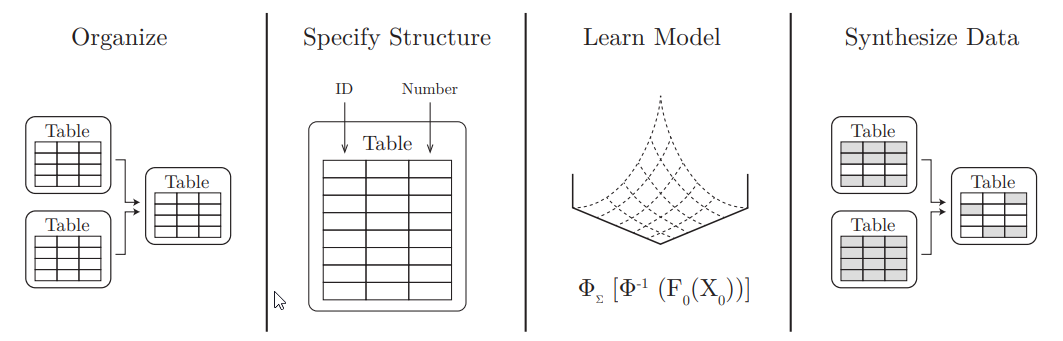

In [2]:
from IPython import display
from base64 import b64decode
image = "iVBORw0KGgoAAAANSUhEUgAABCcAAAFVCAYAAADc54XJAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAK5aSURBVHhe7P3nWxTZ+oYNv9+ff+B5Pm2VZEIdxZzFnDCMI+acFQNiTpjDmHOOo45hzAHz6JgRc8ZRUbaibtQxNUP373rrLgpooLs6Q9N9ncexDqmqtrqqumqFs9a61/8PhBBCCCGEEEIIIQUI5QQhhBBCCCGEEEIKFMoJQgghhBBCCCGEFCiUE4QQQgghhBBCCClQKCcIIYQQQgghhBBSoFBOEEIIIYQQQgghpEChnCCEEEIIIYQQQkiBQjlBCCGEEEIIIYSQAoVyghBCCCGEEEIIIQUK5QQhhBBCCCGEEEIKFMoJQgghhBBCCCGEFCiUE4QQQgghhBBCCClQKCcIIboYjUb8888/+Pbtm7aGEOKP/Pvvv2pe8OPHD20NIYRkk56eruYR379/19YQQohjUE4QQnS5dPESAv5TBM2bNNHWEEL8kd2/71Lzgv59+mhrCCEkm7hjx9U8osMv7bU1hBDiGJQThBBdKCcIIQLlBCFED8oJQoirUE4QQnShnCCECJQThBA9KCcIIa5COUEI0YVyghAiUE4QQvSgnCCEuArlBCFEF8oJQohAOUEI0YNyghDiKpQThBBdKCcIIQLlBCFED8oJQoirUE4QQnShnCCECJQThBA9KCcIIa5COUEI0YVyghAiUE4QQvSgnCCEuArlBCFEF8oJQohAOUEI0YNyghDiKpQThBBdKCcIIQLlBCFED8oJQoirUE4QQnShnCCECJQThBA9KCcIIa5COUEI0YVyghAiUE4QQvSgnCCEuArlBCFEF8oJQohAOUEI0YNyghDiKpQThBBdKCcIIQLlBCFED8oJQoirUE44hRGfn13B8d1bsW7FSmz87Q+cvPEK37SthPgShUNOpCP1yXns37wKy5euxraDV/Dyqyljk/GVcg6Jyid8ANMnPDl/ANvWrMX24/eRatTWeww/ua7ELignSOHDBMPnd0h+9hjPUgzaOmcwwvDpHV49fYjn75nrWcOv5ER6qlIe78OWVcuwfPVWHLryElnFY9IlXHrq3feJ8fsnpCQl4tHzD8rdTYj3QDnhEOlIubIBY9rWRaOO47Bq7xlcT0jA5ePbsWjEzwgP74TY3+/go5Y5+SZf8PLGFdxPSdOWia/j9XLiyz1sH94CTSLHYdm2Qzh16gj2rpuN4Z17YPKeB0jc2QfVevyOz9rHvZYvL5Fw5T6sPVrG5BOY1a4uIkb9hssX16NPWAjCJ11QnkgP4SvXlbgNf5IT6Q83YVhke0S2aITw2nVQT1Idpexv1hYdIyPRecJBpPh0WW8NE94dGId2zZuiYbUwVChTFuXLhiFi5mU7X9AYkDC/DaqWLYfyZcqhYtV6aN68DUbveqVtdx+m17sxon5llA0ooty3gYhY/NipRlj6g7XoXScMocVkP0HotClFuQrEEv4iJ77c3YaRzRuh09il2H7oJE4f2Y0Ns4aiW/eJ2PsgEbt6V0bvnV5aOqbfw+qudVGpeDH1tyrRbQc+aZsKii8vE3D1Xgq8oWVhfL4d0a1boHndqqhYVsnflDyuwk/V0LBZBNpEtFJTq6YN0TC8MVp3Ho5ft57HC76ddiuUE/Zi+oj4ZZ1RJbg6+m++Z6FBYMKHK4vRKaw46vTfhoc+eaMakbS5C8oVKYKQauNwjg+jX+DVcsL4Cn/0q4oa/fYgKfdLivTXiJvQGpVKFkWJ7l7eiDYmYWvnUAQqFeiaY8/lreQbX2Jbl1CUbL4ID5XzNJwdjWpFi6B46xV45olXHi5dVyPePXmKD4Wo9m5MeYKnhemACwi/7DlhSsbmDiHqeZftsQNv+Yoxm0+HMaJFUzQJLYrAcoNw6KO2Xo+vZzB3UCQaBxRBYJn+2J8Pz13q/oEIK+K8nMjAhOTNnVCackIXf5ATxld7MbBKVQzck5Sn52D66zhMah2GMkWC0atA5YTtctj4agM6BRe8nDAmbUE3JQ8JCKiO8We9qGFheofdvUKV+7koqsScwndtdSamb68Qv3cOelQvjjJ1+mLNtVT35gvGd3jy5INf5jWUE3ZhwINV7fFT0ZJoNT9B5+2ACalnxiM8MABV++7CS5+rxBjx95r2SuGsVCrCRiDOY69siTfhzXLCcHEiagc1w6IHVrpP/riF+U2DCoGceIZ1v5TIKASHx+WRn8aXq/FLYCDaLkvMqFybPuDeycO49NwzBblL19X0Chv7xiDuh7bs9Zjwen1fjD7mSpdv/8A/h3V8x9EhUkEthmqjziq1AZJF2lXM6jsTq6OrIOg/pdFz+1ubFenUg7Mwf/sCtA4ogqDqE3EpHy5oWvx01C/mqpxQ8sXTo1ClCOWEHr4vJwy4NKEGSjRdqL4osITh1jy0CCxgOWFPOfzjBEaWL1rwcuLZWnQoXgQBRSpi5HFvalgYcG5UZSVvK4baEy9bzftNHy5gVrNSCAptibkXP7otbzC9Wo/+Mcf9ssyhnLADQ8KvaBEsBek4XPiqrbSG6T329/8JgUVC0Wm91pDwJYwf8OB0HC4/t3UhiK/gvXIiDTdm1ENwSF/st9pGN+Httq6o4O1yQsH44T7OHr8MS49W2uXJqFM0GL1/z4+zcPG6Gi5iSrMRhUhOKJXNic0xknLCJv4pJwyUE9YQOdFvAW5cmorwYkVQst0aPNer9Jje4PfpS5HwcFk+y4kZbpMTVSkndPF5OZF2A7PqBaBU333WX1Sa3mJ713IFKyfsKYd/nECMF8gJpfaDD/fPIO7Sc3hXy8I+OSEYn29Ap1JFEVxtOI66abyf4eIkRAynnCCWkMK0Zxm1u3WTeXfsCv72/ewYVC+qFLyVR+JkQQ/kIsRFvFdOGHAmpiICizXAnATrIxWNSWvQua/3ywk9pCdDraLB6LMrP94quHZdDZenILz8sMIjJ35cRmydChhBOWETygnKiRxocuLu9/tY2CQQAQHNsOi+9VqS8dl6zFzzBIYnlBO+is/LiR+nMSZMaYTWn42bVotHI5JWd0T/ApQTdpXDXiMnvBX75QTwDedGV1U+G4D60665oZww4Mrkuqg4lHKCWMD4cg3aBxVBQNGqGH/ezlvk0z4MKC2Bk0LRf689gzAd5Mc7PL19Dy8/WSpmjfj26atXBJWxG9N3/PPJ4FKlgXgO75UTRjxZ0hIh/ymK8pGrcM+ack+7hW2bbRUszmH6/hmff9h355oMn5Gq3OfOVGrzV044f11Nn65hfsuSCCrjPXJC97qbPuH6vAiEFi3rNXLCkXsqv6GccEFO2F3OFaIyPFNOpBvx9+qfUUKpmIdPv27lGqXj/vLp+O2VCUZH5ITJoFy3by7VD+yVE7aePcoJ2/i8nDA+wbIWgQgoUhadVt2z+qY/7dZWbMkP82YBu8thN8gJu8or5Rn+8uEdPnzVxKXRAIMrD7RdmPD982cXv8cROQF8PTYMFYsUQeBPUThmrapm/IbPX23l7iZ8ujYPrUsUQ3l75YRd+y08UE7oYsK737qqMRYCAiOx6Y2dxVH6PSxorGReSuW+4rC4jK5fadewond7tGlaH/WqVEbHZQ/x9flRLBwVjWGdmiGi31okmN/MhiScXTYK/fsNx5iY4RjQoz+mbj2Hv7ZPxYhRc7BiQltUDJ+J69q9aHp3GRsmjcS4KbOxcP5sTB7UCb/0iMXuO59zFaLpeLw1Gp1aN0eTOtVRrc5YnPphwPMTKzBt3HhMmRCD/r+0RZ/Y3Xhgnuua3iNuelf80qIJGtasgup9t+Od2Y7/ObMAA3r1Rt/e/TAsZjxip8RiWqykcYju1wf9+sbiYJJ5LmHAq7MrMKpHH8RMW4CFs8aif/v2GDz/FJJ85/nyCbw55oS8ietUUkSgkok36ofZm48h/tlHnYp9Gq4v64OOyv3fWO7/ehNw5v197J83CiOGRyOqZwd06joYsWvOIslaoW54hXPLR6J372jMmL8Ac8b0RcdfBmLhqSQL3/sNz44tRFTbFvil1whMnDgOMVGDETNjJ259yniATO+PY2aXn9GqcTjqVq6C/tvfZT2z6U9+x4S+vdGnbS0lHyqGKs16oK88Z31isPX2A+yaMBhRUUMxYtgwDBs8CIP6j8LWu1oFwPQOcXMHYfCgqIztQ0Zhy237Hi6Hr6vxFU4tUfKVGhI3Q/LLamjbQzlOOdZefTFl7/OMz9mZD6Y/2oaRHdoq16Seck0qo/u6F1mNCsOVJejTvjUiGtZF7UpVMOJg7jBVgq3rbsTrk0sQE1kzI3//TxBqtOqpHW9v9J+4N6N7evojbB/REe2UfK+Bku9V67IeL7IPBMt6tsfPzRohvHplVB96MDtglsP5vSP3VMFBOeGonLC/nLO/DM/IwzpENEWjWlVRrf1yPPr6HMfmj1bu8c5o2awf1t1QHyL8NqID2mn3Z/iYkzD8eI6TK2IxYfwkTIpR9tGmF6btvu98V+osOaEc/5tt6KHkGUFVxlgOlq08L4tm7FMD9NkjJ/55eAC/DumOHn2HI3bmDEweNQJRw+dg3/3c18OML08Rt2IiRo5U6iCTxmNsdDQmLTmOJ5d05IQDzx7lhG18Xk4od9Df6yJRRsqNomXRtN8sbDl6HX9/tJ5TSzk+edBgDIsahuihUYgaOACDYrbgXlZRHYdfBw5UyvKM7UNjNuNOmhN1dXvL4UzM5MTHb4k4tngSxowai/G28gY7nxljykWsGR+DSTMXYs369VizZAHmz5mFUe3qIfqoPPgmfDg2Hd3btkSz8FqoXrkvdpgPifh8Fgv7ybH3wYCoUZg4KbNdoeRhw/qhX+++mLY/5yw/hqRzWDmyJ/pFT1Pz0fF926PDgAU47VTDwjE5YXy6DG2UfC2gaBWMO2v+aRPeX16P2JFjMHW2Ug7Mnoiojj+j95RduKvVAzMxvjqJZdGRqCMxOJTfsHjVVuit1Uv69p2EP3KMm7N/v4UNygld0nBlci0Ey0Me0hf7rA4wy4XpFTb8EqTeWCHNl+CJei99x4dXiYjf3B/Vigai+bSNmD9hPe5/eYMtHYIRUCQUQ9WHVcH4HL/3qYxSDWNxSZuX1PTpL8SGB6JUq+V4rGRo366vxshR2zIC8qQ/wMpf6mPwzkSzh+czLk9rhBKlI7Dges7sxfApGc/vHsGEBoEILDMEm/fMxrQtCVlToBpfrEPHkEDUnXDBLGMy4kvKSzw8EYsWgcoDE7nJbBo1I56vaINyjcbiwKNPZoW/Ccn7BinnqzSq+u7Gq6wNBjze3AvVi9fHlPPZ0W1NH89jcngJ1IuJw/vC/Vz5FN4sJ9R7aVM3VFaneMtMAQit1BidBs/AbxeT8kRY/v7hFZ7d/B3DqhdDYMmGiOwVjU03UrPu2y+3VqNbWCAqtJ2Py6m5bkTDI2ztWQWlwyfhQtY2Ez6en4iGxWtjzPFssSDP4LUFPyOsdHNMO52cPSQs7QX2D6uHaj22ZzwTxi949/IBTk5piuK5I8Gnfca7N8lIOjwSNZR84+dFt5CcnIzkNyn4ZDDg05tnuHNoElqEFEFgaBesjn+B1CypYsTHJ4cwPjwI5ZqNxY6LT/DeUjveIo5e1zR8TnmD5NcJWNhSyVdC+2PXC+U45ViT3+D958yKgZ35YNonvH15H4dH11Py30C0Xf4sO1/5/gGvnlzHpr6VlEpDCPr/kfuk7LvuaZ/e4U3yayTMj0BIkTIYuPOFdrzJePPus1bJSsOnty/x4NAYpXGj5OetVuDv7APBh6SniN/YF1WLFkHJvn+YXRMH8nuH7qmChXLCETnhQDnnYBkueVhi/BYMrFQMIU2mYdO8Cdh47wvebO6IEv8pinJDjiqfUvKH5Oe4d2QcGgcURfkhm7B3diy2JWQGbDPixdr2KBVQC5NsBtOygpmcAFJxcEA5BBYpj6hDed/Dfj09F/PiMrq568sJE1JOxyKiYnPMOPcuR33iw6U5aFuxCSYef5PnmUh7vh+j6pdDg+F78TTrQTThU8I6jGxfDxUszdbh4LNHOWEb35cTCsp9s7lbWEbbIDMVK4lqjSIRNX0bLiXlKpMMn/Dm2W0cntgUpZTn86fOKxH/IjX7WTd+xJNDY9EoMBQRY37DpSfv1LLE8bq6veWwRqac6LIA26ZPxlZ78gZ7n5n0h1jVrhHGnc6VF3y+ghkNlDzicMY1Mn55h5cPTmBqU6XNFNgBm83khPH5CrQLbYzx+x7BvKO46fU+DFHyvqCwvthj9tLT8GgL+lQugUYTzyP70D7iwoRwlK41CnHmb1TtwjE5gS+70Vt62iv1uMi1r7LyiPQHK9AhfCB2JZrt4dNlzGgYjLIt5yPe/BJrdb7kGxI0WLlX+v2OF1q9JPnNO/xj9hM6tN9CBuWELgacjK6AQMl4QofgqL3dlE3v8VvnDDkRXG8GbpjdTKaULegcWAyVavTGStUsGPHq1GJMnrwBV7U5f77ERaOKUpC2WWoeUDMd935tgpCilRBzIucdZ3y6PMPWBXfAptdmD1/qbvQrVRRluu/I0cshAwPihv2EoOBqaDfnbM5x48bHWNo8EEHVxuNi7qfxxymMCiuaS06k49bcSIzK1Y8p/ekmdCtbFCE1RubIFNLuLUarkADUiDmV83uVR/nNli4oHVBfd6w7yV+8W04IBrw4vRRDm1VQGvdaRSErhaDe4N/xNPd9bHqHbZ2UZzSgMeYm5KpIKHw+PRq1iiqNkcEHze7zNNxf3BKlilXDmFO5xpKa3mBb5xIICc8eh/rp1CjUCghE07m3tIZuBhlDNJRjKzkAh8y+2nBqJCpbqfhm/J8gdFz3Os825ZtwZEgYAgOaYEFmr4ksPmBPVC9sSMxRJbcTJ66r8SXWtJWKlH53UnvyQcFwNAo/KXlhDjmhYkLyhkjluPLKCceuuxEvV/+MkCI2hnX8OIphoUpelkNOZGBK3oBOgbnlRAa2z9Oxe6qgoZywX044Us45VYYredjWDkEIqlATfZc/VCWcMekUlk6Ygk1XPmR8RvgRh+hyxVCyalvMO5PzSIyPFyMioBhqjv/L7vPKQQ45AXw9GaNOcVy2x06zfFNIxaGZC3BJyxP05IQx6Xf0Kx+I+haHh6Th5qz6CCnTFVvN3yB+v4H5TYsrz8p0xOfJd0x4t707yvwnt5xw/NmjnLCNX8gJ4ccLnFkyBBHlM+r6OVJwHUTtfJr3/v10GEMrKOVIk/lZvSay+LAbw3uutzA1uBN1dTvL4Uw5ERjaGDNO25M32P/MpD9ciIiQ9lj/KveTYsSz5V0RrcmJDAw4PVKpw+SSE+k356LTyOM5Zy9LT8TmzuWU+k5NjDKXh2n3sbRFcQRXHYXcPsT0Ziu6FQ9Eo1kJ2hp7cVBOfD+AgSXkHpAYhbe1FyNGJC5rhRDlvigRuRHJZpcjdXcflC1SCj135H0Boc7QJlLZ6rAO5/ZbWKCc0MWAi+OrKTemcrMF9cAuewdlGROxspUM6yiCkKYLck439H4buikV2Tzrs0jHvXmNlRsuGD125PzCTzu7o4Ry0zebd0+76TW+3cDK7k0R0WcNbptnRGnXMaNOAILrTEN8nsqtJl6KVsH4c7lufSWT2RSpZLi5Gk8qhjMYUzG3nDDgwqTBWJvV31nh+y0sbVUKgcENMf2ieSb2DadjKiGoSHlEH8+9c+XsHy1SMsRAtJh/X1tDChrvlxOZGPFPUgJO7VyJWSN7IqJyiQyxqDxLTWddz9Vw1ARiUC/syenUMki/h/kyNEsa/He0p+3bKYyuWAyBPw1HXJ5bNx2PFzVHSEBTLJSAcMYXWPdLiPr/1WVzPt/Ahug+GLroXI4eQnoVX305oTxuyvY6RZUCdMJfOc7T9GorRk6Iwz/asnM4cF3trRTZzAczMJyIRkUrciJlU4e8csLh626vnMiYcs2inEjZZFVO2DxPR+4pL4Bywl454WA551QZruVhcn9Ym/JX0BogQZXH4s88Rf1G9d4t099sSJIj5JITMFxGbK0ApXHWHhvM5lI3Je/AzKW3suot1uVEGuKn1UVw0WqYcMHylTZckpmLpNF0QfstTEje1g1llbqRXE9LV0LEb6XcPSecePYoJ2zjN3IiE+NnJCWcxK6VMzGqR3NUL15UPf+A4MaYcz33jfUdlybURFDRGpj0l/k2E15vicYkrWdRTpyoqzsoJ+zOGxx4ZozPVuDnwEDU7LUcZxM/5yi/0+4exKEceZYBZ5X8MrecMJyfjKjV2UM65frdXtwKZYoEo/HUSzlEzbdTMahaNGMofd5De4QlzQLVctgxHO850Sc4Q060XZ79cvlb/Ar0atoc/VffyrGPtOvTEF4sAOHTris5X05sywnn9ltYoJzQRckw1rVHCcloAlphpb1vH7UKhWRQZfvty2k6tcqqPPCWR4nIW5XOKCXduzckmxWAJrzdmPGmsMvmvF0as0nHx8SrOLFvBzatnIxOFYopFYBJuJzn7tYyvICWWJYx7iQbUwo2S4YX3Bf7cz/lFuWEEW9u3cSrrLzmMy5NbYgSRUrh58W3c2YUafGYKdemWE2M2HIG586ey5mOTFUqbUVRJea09h9IQVN45EQu0t/gzIxWKC8BikL7YG+OsUI25ITyfGQUShmFjCBz5ct0ecE1hmHb6Vz3rZKOTm2hNHIrYvRp5WH7sAM9Q5R8I3QwjuQpKS3jipxA+n0sbKpURsoPxuGsGLzpeLQkCnOuWSvanETvujooJ6zngxk4LCccvu72ywmpxDkrJ6ydp0P3lBdAOaEvJ4zJV3HxofJLu1TO2VuGa3mYNEz0HqLMe7fFUm2IaTbZ9+6+vPeuPeSWE8qx31VfrgQhYlFGbw55xp6tn451Zl9uVU6k38H8RiKFm2PJI/PGSzbGxBVoq/zf4DpTtZhbqdjds6Ty+4Ri6BHLv44lOeHMs0c5YRu/kxO5SH9zGrNalUWgDK/qs0eNsWJO+r0FaKE8+xUHH0J2Uf0Qy6Jm47rF29eJurqDcsLevMGhZ8b0BoeGVlff7AcUCUHFOq3Qa8R0rD5wO3vIRRaW5YTxzS3cSsrOBz5fnIrGwUVRpvVi3MmRYaUhfnpdBP8nAHWGbsXZXMd17uwRTG+uXI+wGO3z9uKYnDC9Xo+OyjWTvGjwAYsVS+W3/ohnV+Owf8dGrJ4UiUryUsnCvu2REzmwc7+FBcoJG6hdk6S7pd7NlgvTG+WhVscdFUfX3CJBrawqGdOIE1ZvGgmQF1MtEOX77M7uyml6j4MDKiCkWjTicjSyMjB9vIO9swejQ7NW6DN+GXafisejp6cRWzfAhpxohZW5+5GZZXj7ctdYLMoJc0x4dywadZSHqkLnjXiau36hdjEtqlQ+GmDMjuOIOx6XN8WdwKUn9nZTIZ7Ge+VEOh7v24sbeoWvci//0a88AotUwMgT5g+BLTmRjjtzGyoFa0YGLxiOD0eY0iAPqT8KO49ZuG+VdOLERTz5ZMrKN4IqjUHulx3WcElOKFXupA2RKF2kFLpv1T7z4zJmRa1QY9Q4hgvX1SE5oZ8PCo7KCceve37ICevn6cg95Q1QTujLiX/+GIbofV+dKuccL8Mz8rDA8tE4qfesOXvv2kMeOaE8UYkr0S5YacDUm5kxpDX9DlZM3wbz0SpW5YRy3Ub+JNetLdaY98Q0w5S8Xj3mrLfF2ltRvRnVLMkJZ549ygnb+LycUO63A3tv6OYDppS9GKDcxxafTWMSNkWWQGDJrvhNeygMl2di2PLHmszLjRN1dUflhJ15g8PPTNornFs5Ep3CK6CE8v/kvpBeBVV/mYtzOcapWZYT5phSlHZRDeWcynbBpie5r1TG0JdAZd+NY3ZYPC5JJy8+0T5vL47JCcP5caghQ0dDlN82x3mY8PHObswd1B4REb0wcekunI5/iMTTk1G/mCtywvH9FhYoJ2xhfIrVbYqrFZMaY87pvuXLJHVf/4y3imX6YPfbXA9aZmU1Wq9S/g2X5vRCh9bN0HnCeuw7uAdrRrVBeNNo7LifN8KJ8fUhjKobgpDqg/D7E7MjTEvAnPD8lRPGpF3oH1ZMaRwMxL7X2fv9eHYTdkn3SKUyM026fQY0x2K9/tzEa/BeOaEUSDF9sM6s+7AlvhwYiHJFgtF3j/mzY7vnxOVJNdWeE81+vaeuSbsai3oSFLHZQlh5qZdFpkEPDI3CMb3KgRmuyQnlOz/8gQFliqJEy6WqkPh0dBxifjPvfWUvLlxXi5WiL7h1NNcbYrvyQeVIdOTEWwtywvHrbllOfLl5DGeem32jXiXurR1ywsp5OnJPeQOUE3pyIh335vfBNGltO1jOOVeGe6ecgCkZ2zqXREDRahh/7rvS8FqAWfve58iHrMoJwyVMqV5MvW5We05Id3Hl/8pb0DNy3pkByHV6GFnsOeHEs0c5YRuflxM/4jCmz1roF49fcGhAKAKDe2Nvniq7CR/+6Ke0EYLReokIiU84Pk6p25sHDciBu+SEhXLYwbzBoWfG8A5vU7N3aviQiBtxWzGndz2UKaLkpSNPmA03tSEnjEnY3acigopWxuA/XmfXBT6ew+adMjQuDddia6vBsyMWZvbYcgeOyImMeDjB/ymKSoMOmvWYMSL50EjUDw5ErYE7kTN7n41GjsiJLzdx/HTmjCvO7bewQDlhB59Pj0Ft5YEMLDcQB3L30cqN8RU2dZAuhsFoPi8h741hT6X80z6MGL5HeXANeHv3POKOn8PNxPcwWPzqzzgVozw8RcIQdShVW6eRFo9ZZm9d0m7sxO+3MkcgeUBOGB5ibaSSIQfUwbiT5pWRNCTMHYD5NyXL+IJjUfLG9SelMWBF9Zg+Ivm1pbF3pCDwajkxvC6iDujfK2qFMqAaJv5l/sTZkBNKhXdj++CMt3GZr+C/HMVweRtSTinwrd66r5H8WbnztUZFQEBE3q6YGqbP7/DebD+uygngq1KQVkVQsbqYfuUldkSPw1GnOiC5cF2zKkVDsytFprfYGj1ZW9CwV06o18SSnDDimRoMKtewDoeve7acGJ4lJ0x4uzkaseZvYbV8z1Ilzpi4XO1mbrGBZ+s8HbmnvADKCR05YUzEKqVBtkotTx0p55wtw71UTmQ1vpRKetQeHJwzBydzZSXWY058wsH+ZRCoE3Mi7UpGA6lM951a7BilfjFDZvUJRtetlgPAWYw54cSzRzlhG3+QEyPrDMYh3bI1o7EdUtVCUHnh61mMrVJMHZp09eV2xIw9otz51nBFTtgohx3NGxx4ZtLiZ6PL+HN580vTe5wZVRvFa07BlayACHpywoBHqyNRTnl+640+mWOYTNqNuRg076b695ejQ1FRyXPClMa85UMz4ePr19rf9mK/nDC9P4LhlYohsPQvWGMupD+fxGhZX2EwDufJ3mWK48x9K/nYzp3InO09S05EZcsJ09stiJl0PmPByf0WFign7OIzLk1rjJL/CUT4hHM6mYgJKQeHoFrRoijXdhnuWqow2FEpN75YhQ5NpiPeysOfg/RbmNcgEAGBkdj0JtdD/ekABoUWzarYfN8XjZisCLnulhNfcWNec5QuEoLmM68qVTMzlP1t79UdG7SovYYbc9A0qBiqDjtu8Vp+vzwDgxcyIKa34NVyYthPCG21FA+slhoZQZpKVB6FMzneYGhyQgrD3L2bFNIfL0WboCIopew7u5wxIGFOY5QoWgnRxyzeubgyfSAWq2G4jXi+oQPKFglGm6WWumt+xtnxfbDILGS363JCKZQSZqNxQDFU+qUL+k931pq7cl1TsaNrMAJK9sOBzPXpj7FixHxtQcNOOZF2bSrCiwWi1ZInueREKvb1C0Wg0iDJISecuO6p27uixH9KYYB0x1dRzm1ZNBaYh+lPu4bpdQIsjs1NVRpi5YoUQYk+TsgJh+6pgodywpqcUMr+o8NRs5RSZmq3kd3lnNNluBfICcNlTO85F1m+JJMvcYiRwHnFK6LN7Et5rpl1OQF8uxyL+gEBaDgzQalW50aLaVGsBsafzTYexsS16FCyGMr33ZMjyHAmavR6eau62DxPcPzZo5ywjT/IiehyJdF2yX0reYGCOtQoGNVjTptNx2+OvGVvgJCiYejQuS9m5X4IcuBMXd3OctjhvMH+Z0biUzSsOQ4XLLRjvh8ZjArhs5A9KZ91OfE1/ldEFC+Kkk1m4VrOhgVStvVGz3WvMhZ/JGBeo2AEVRyOOMsZLmYNWKgt2IudcsLwDHsGVENIQHUM3v0yR10l/dYcpU5WRGkzbUTu7P3z/gFK3SFz39+xPzo6O1ZW6nb0UOqgZfrtz7qH0h8vx8hfM2SM0/stJFBO2Ev6K8RNaIayARXRffVNC9HvTUi9vAC/lAlE2M/zcclSCamQ2SWxbN+92cFwcqNUVuY3CkGFBl0wOGoYoodHY1TMOEyaPBNLt8bhVrLZ0256p1TSy6mRfEce+2BWYH7Hg/WxGBxZEcFlh+DIFyNerI7GrCxV+Rn7+pZGQEBDzLuVq+JrfIplLZTKUlAXbH+vrcvk80EMDi2iZmbZ+aRy7mcnoL5SCS/bdjnu5agopSM5bgwahPbHgazD/o47qzqgYnA9jD3+JseDbHx7DrMHTMFJK9eP5D/eLicCA0LReMhW3LEwLj/95W4MqBSGHltzv3nX5ESRMoiYEpdDtJk+XsXCtmVQvFJv/PYkV/X4+22siSyPknVHI+5NjjsXb8/OwuDJJ7LNfvoz/N63CoqX7YCVt8xfHSrPy5V56D/6UI7v/UeGSSgVaPMoz5l8PTZMHd7QYv4DCw1uM4yJWN1GqZQENMMip2d4cOW6Kg37JS1RQnpvaIE4TW93YszEOPXvTOzKB4VPRzCsQqA6pC67bDXh07WlmNytuSqM260yj+at4OB1T3+0BK2CAhA+9VpG5cP0Fr/HTMKJHG97P+FoVBhCqozFn2aFvOnTNSyb0A0RwUqe2GYVcg+Tt+s8HbmnChi/lBOm99jRTYZ2FkXF4XkjwZu+vcLlzSPRXJUI5o1tO8s5Z8tw4zOsaq2U06X64g+9h+jTH+hfSrk/G8zB7dxF/ZOlaKXcnyU6b4PZ5KN2YsS781PQNLQl5l5JzZUPGHBpYk0EW6pfKMibvQbSG/WnKBzN8ZwJX3BjSTtUCG2HpQk5u7V9vbsCncqEovXcy7mETxqebu2FasF1Mf5Uzt4T6a+PYHyTsiiuNDBqjc85m5Gjz15mHt1qydNc50sy8Q85oTToSzfA0C23kbd4TMfLXf1QrUI3/JZbJpiRGZslpOlC6E2241xd3b5y2Km8wc5nRg2eGVACbRffyyhXs/iKK1Mao8Uc857ln9VhMLknHjClnsOkukEILP0zVtzNuZf05DiMq1cGA/dlt4e+316FTj+FoP6oOOQ8tLc4N3MgYk/kbtDY4jMO9peXIMVQbbSFXiBKbvL68jZMbhOGEj9FYPKhF3mEqundHxhQVmZEGYE488zk+31snDIQncICUGHIYXwxvsDaETNxNXMH6Y+U3zY4I/Cv+sUmvN05ClO0GV2c3m8hgXLCIb7g8aE56FUnDPW6TMSKHXG4fv8+rh79DcvGRKJ2xSYYvOQ0Xlp6i2G4iIWdWiOiVgWUDS2Dn8pURsOW7RAZOQtnc3/e+B7xiyNRsVQl1KtXDw3q1kW9mjVQrWxxBCuZfkDRULQcdwSvtIfPlHIeS/o2QuVKrTBm2e84tG8blk0dh4VHXuDboy3oXakkqkf0wIAp+5FkTMf9tQPwS4t6qBYainJKqli9Cdr+Eou4Twb8Na8jfm5WCxVLa9tqNkXbHsuUB+UhNg36Ga3DK+Mn+X+lK6Bu07YY9ftLJReSrtRKBvmf4gjvGIXoYcPVNHxQX3RrUR1lihZBUNVxyNGrHt/w5OAM9GzcEJ2i52Hdlm1YO3cMBg2ahkOJebMAUnB4t5yorBRyV/Dw4DT0bB2JqGkr8fuRs7h44TQOrJ2ETnXqoufSqxaiQ2cO6+iBNUeXYsKoWCzavBu7Vs/AoJZ1EdFvIU4nWcnNvz3Boend0axBJGLmrcW2rWvw6+gByncfxLPct25aEk7N74tm1Ruh14RF2Lh5A5bGjsCwyTvxQNPh6Q83IqptBBpVKqM+c2XL10LLNiOx+6VRqXtsQ/TPGdvUfKOCbPsFHaO353nTkYEJKTuVSnrHTcgzvbjduHJdFb4kYE3PWqjUcDAWr1+J2AEjsOWhdi0dyQdVjHh9dAp+rt4Yg+Zvx6HDe7FpwUSMnXcUT//oj1DJD4PLI7xpNywzn2vRjuuezRckrO6FuhUaIWrheqyePBAjNz/MU8kwvjqG2NbV0bT/Auw4eBh/bFyIyaPm4diTP7S5zYNRsU4z9FgS7/h5OnJPFSD+JCfSH2zA4NYt0Fwp70tmBnMLqoDwZq3QJkJSBCIa1UXlEsUytikpp7QX7CvnHCvDlYb//M5KOV1bLad/Ci2LauERaN8uErPNYy6k38f6/j+jVb3Kar5SLrQ8ajdphQ5TjuPTjwuY30G5P2vK/ZlZnrdC76U3tP+shwnv9o9R6gLVUKFURj2hbKmfULN+K0w6kt2/OP3eYnTssgbZbQ0Dzs3piI7t26Bp9fLKcSvPRWg55dhbIbJ9JMbt1t6AqnzF433T0KNFK/QcMR0rNmzA8tiBSr2lC2J33bMyNbIBfx+djd7NW2HAjPXYt/93rJ45DtGjl+DkzhGoJL9hsVDUaNgKEw+ZNbfsePYs5dERrTtivpWhJ/6MX8iJSk0x78oDHJrWHe0iB2PGyp04euYv/HV6P9ZP7IDwOt2x/GpqDkmWB1MKfu9ZGV02vbLyOSfr6pnolcOu5g12PDMiIJvUUb574TiMnLxUKTOP4/j+bVgyujd6j9+DJ2o5mI5HGwfjl5b1s8+xZjO0G7lL9qDGcJDZPkrV6YRhWrsiOmow+nduiZollXzXwvCvb08OYlb3JmgcGY35a7bit9VzMa6/8hsdSLQgFyxjfL4dI9u0RMt6FVE6M+8PDkODrLy/FVo3a4JGtWugbpPOGPXrbiS8s1ghU1DqZOcXoX/DMFSLGIUVOw9i/7YlmD5uAY6++IbHm3uiWokqaNO9H6buS8ohPb/cWI0+NcPQZPBCbFw5BYOHb8ajrIqJ8/stDFBOOIPpK5KuHcK2VQsxd/oMzF+yBjuO38Jbi5VrBzG+xN7BdRA+cAce56lEm2B49wBxC7uiekA59N+T8w1BWuoL3L12EZeuP8Lbb2ZbDKlIfv0xT2XbWzC8T8SNi5dx61mqklURb8N75YQRf58+jruZz0naezw8sxsblvyKWdNmYeGavbj8Ms9DpJEpJ7SYE2kf8fLOVVy9nYRPdt+EBnx4egOXLt/E36m2/lMaUp8l4PKlBDx958kKrdj1kRh7INcgRIdw5bpmYsTHxOv460I8nlvoeeEwaR/w7MZFnDt/GfdefVHzPVPKA1y5dgsPn75CysfvVvIO+6+78WMi4i9cQPzzzzny1Zyk4UNiAi6dPY8rd1/hS8aB4OHla7j9IBGvUj7iu0uZmCP3VP7jn8M63IM95VxhLcM9iVy3hKsJSFSeX/tyEqknPcWNS1dxL+mzWik3vX+M69cScP/JS7z58AVpFnfk3c9eYcHn5YTxGc4cu5PV1T7t/QOc270ey+bNxIyZC7Bu72XYLB4F01vsGjkaucPMuBc3l8N50Hlmvr7Ci5SMHMv46TkSLpzFn5du4llqPuViP94jMf4Srtx8Bu94nJW6yIs7uH7xIuIfvUXO7P01kj9auS7Gj3h2/QL+in8Oy6GnnNyvl0M54WWo0XCD22Ftko7nUjK1LR1C8NOQo3abQEKcxXvlhCvkkhO+gvEp1gyJtTjOkxBXoZwghOjh83LCTRifrMLQ2PN2zQBIiL9BOeFlpN2YiYbBLaxGmlcxPsPq1iGoM8nZgHeE2I9PygmTD8gJUwoOxdRHtXrR2K9NQ/bt0kwMXXKfPZCIR6CcIIToQTmRF1PKQYwJr4wGI/Yho6j+hsszhmCZ03GhCPFtKCe8DdNbxI1rhGotY3H8uYXwqj+ScHJGG7VBcigz6AQhHsQn5cT3BMxuGAiZT3/hvUKq+IxPsbxlEAJDu2CLRGL8dB2Lh87EuY8W+/4R4jKUE4QQPSgn8qLOThNYFOU6b1aDJn++vhAjZpwDi2pCLEM54ZV8wZNjyzC2T1f0GRCNSdPn4tcZkzA2ejD6d+2FUQsP4qFHxo8RkhffkhMZweTatWqFtq1/Rvu2bdA2ohXadV+M64VwaN7naysxcsBozJg+CaNjZuKPxxaEJiFugnKCEKIH5YQlPuP6yhEYPGoaZk6MwegZe8GimhDrUE54OyYD/nn/Fm/ef2FXbVIg+GbMCV8iHd+/F86gR6RwQTlBCNGDckKH9O9gUU2IbSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQThBCBcoIQogflBCHEVSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQThBCBcoIQogflBCHEVSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQThBCBcoIQogflBCHEVSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQThBCBcoIQogflBCHEVSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQThBCBcoIQogflBCHEVSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQThBCBcoIQogflBCHEVSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQThBCBcoIQogflBCHEVSgnCCG6UE4QQgTKCUKIHpQThBBXoZwghOhCOUEIESgnCCF6UE4QQlyFcoIQogvlBCFEoJwghOhBOUEIcRXKCUKILpQTpDBhSjMgzaQtELdCOUEI0YNyghDiKpQThBBdKCcsY0w6jQ0LZmFkZGM0rP8zBk+dj2UH7yP18hbMmdAfbapXRo2WAzB15mzMnT0DU0aPwpgxsVh+6CH+0fbhE5je4eKG2Zg2tD3CK9VEpyUJ+KZtAtLxYO8sjO7WAg2bdsTw2K24/knb5GaML45ifv8mKB/UDuuSaCc8AeUEIUQPyglCiKtQThBCdKGc0CMdt2Y3QEj5aJz8oa0S0h9iUdMgVI05C4O2SjB9iMeqbrXRbMwxJBu1lT5C+u1VmNwvEmEhTTD3eraeEExvtmLqwtvK1fIw3/ahf+gvlBMegnKCEKIH5QQhxFUoJwghulBO6JGOO3MbIqTCSJzOISceYUmzIFQblVNOCKbU4xhZpTx6bHsJX/IT6XfWYc2JJ9jRvTxKNpqJa1+1DcK3A1i94bnnz/f7QQyinPAYlBOEED0oJwghrkI5QQjRhXJCD8flBJQ1f42rhpA60xCfpq3yAVQ5ccoAY9JO9K0QgsbTLuOLts2ynDDBaMwlEYzGnJ8xKcvaR9LT0pX/YYYxHem5HUQOOaH8Xz0bYvqGD6/f4nOe3yDz/1k4Pj+HcoIQogflBCHEVSgnCCG6UE7o4YycMOHtpg4oHtAMix54fKBDvpEpJ6Rx/3p3X1QOrofYvz5nbDSXE6a3OLdiBH4OC0b4tGsQN/Dl+maM71ALpcoNQ5xyHU1vz2Hl8NaoGtIGi08cxpZNv2Hn5rkY3Ckaex4n4uzWjdi+cxuWDeuIPstuIKuThionmmPMsqVYuWUXft+8HFNHTccfj8y6cZg+487WiRg1cxviTh/EqphBmHH0NYzGl4ibPwgR5Uqh/9qT2L5qAQbUr4exx1O1/0goJwghelBOEEJchXKCEKIL5YQezsgJ4Ovu3ihRtDLGnbW0tXCSLScUTMnY178SStSZgD8lAGaenhMGxA0LQ/jUDDkhpN+ei6YVMuSEyo+TGBVWGR2WXNYCiKbhyqQ6qNpiKo6nZPRoMD5ZitY/DcbhzBAXIidKV0X00XdZvSzSHq9AZM0B+CNZ1pjw7sBg1IpYjEeaFzKlbEOP6kNw5KMsfcP+vqVRo+c2PDa8w58rZ2Fbgvn4FP+GcoIQogflBCHEVSgnCCG6UE7o4Zyc+LCtC0oUq4dZPjSuI4ecUDC9OYCoSsGoN/YsPn7NKyfOxlRBfXM5cW8BWpjLCcMZjKlUHePPZ+4zHfd/bYJy/fZn9ZQwvd2ETiU7Yds7TUVoPSeWZJoHwZiIla2KI2LxI+U/vMamyJJoOCMe39PTkS7px23Mb1oXsZflSL7jUP9QNJqZkHVcJBvKCUKIHpQThBBXoZwghOhCOaGHM3IiDTdnhiv/ZzjifOilfG45Ib0UUg5FoXpQLYw9vA2rnJETleth+rWsT+D+/KaoNPR41jU1pYic6IitWk8Ki3ICqdjRNRgVh8cpl/46ZtQJQr2o9Th44CAOZaaDJ3BHFRwiJ8qg/WrfClbqLignCCF6UE4QQlyFcoIQogvlhB5OyIkfCZjToCSaz0uwIC4KL3nlhILpHY4Nq4biFWtiwOqccuLcqKo55ETajVloVN4DcsL4AmvaFEfTefeyek6ET4/P1TMiHWnqf8mQE5FrXmUNCyHZUE4QQvSgnCCEuArlBCFEF8oJPdJxe47IiWicyiEnHmKxJTmR/hqnJjVH3c5rcfe7ts5HSLu2EPOP5O0KYnofh5jqIWi30lxOpCF+en3Um3RZuz4mvN7aFeXKROFY5nX8cRpjKtXNKSd+bYKKUcey5YQ6rCOXnChdC5MvZl9cY9IWdK/eFVufy7eb8P7IMNRuMhsJWb+XCcn7lmG7KjS+42A/6TmRxJ4TFqCcIIToQTlBCHEVyglCiC6UE5YxvjyFdb9Ox+CmP6F06XroNWkuluy/h9TLWzFvUl80LlkUJer2wdRZszF39izMiJ2CiSOiMH75abw0FxmFHdM7/LVmEgY2q4QK4V0xdv5hPDMfVaE0/j+cnIQxm3I2+NPur0fv9jHYcf4qLh7dga2bJqB1cCW0j1mGEwnnsHFqLzQsXRbN+83Ab1deIX77LEQ1r4CydXsgdtUpvHhwEAtjfkH1ktXQMWYBDj1WvvT7QYztuwA71i7D1kPncOnkNsyJmYBN8R/MekJ8wYPfJyMq+ldsO3IKR39bgRV/3MNX40ucXDER3WuVRtXWwzBr8SHILkk2lBOEED0oJwghrkI5QQjRhXKCeIy0j3j15BlSpKND2gckPXuFd5++u6HXggnf373A87dfre/L9A3vnici+TP7SNgL5QQhRA/KCUKIq1BOEEJ0oZwghAiUE8QaMvONBJd9/+6dtob4I5QThBBXoZwghOhCOUEIESgniDVSU1MRXCwAv+/cqa0h/gjlBCHEVSgnCCG6UE4QQgTKCWINg8GATRs2Ivn1a20N8UcoJwghrkI5QQjRhXKCECJQThBC9KCcIIS4CuUEIUQXyglCiEA5QQjRg3KCEOIqlBOEEF0oJwghAuUEscaN+BuYMW06tmzerK0h/gjlBCHEVSgnCCG6UE4QQgTKCWKNjevXo1vnLugU2UFbQ/wRyglCiKtQThBCdKGccJ6Vy1fg4YMH2hJxB9evXePb2QKCcoJYY9b0GRg/dizq162nrSH+COUEIcRVKCcIIbpQTjhPp8hInD19Rlsi7mDv7t0YPGCgtkTyE8oJYg0pJ65cvowdv/2mrSH+COUEIcRVKCcIIbpQTjgP5YT7oZwoOCgnCCF6UE4QQlyFcoIQogvlhPNQTrgfyomCg3KCEKIH5QQhxFUoJwghulBOOA/lhPuhnCg4KCeIJV4lvcK2LVvVv6W8OHP6tPo38T8oJwghrkI5QQjRhXLCeSgn3A/lRMFBOUEscXD/AfTu0VP9e/u2bRgWFaX+TfwPyglCiKtQThBCdKGccB7KCfdDOVFwUE4QS8yfNw9zZs1W/5bZdFhW+C+UE4QQV6GcIIToQjnhPJQT7odyouCgnCCWkAZp/PXr6t//fP6MFcuWq38T/4NyghDiKpQThBBdKCech3LC/VBOFByUE4QQPSgnCCGuQjlBCNGFcsJ5KCfcD+VEwUE5QQjRg3KCEOIqlBOEEF0oJ5yHcsL9UE4UHJQTJDfx8fH468IFbSmDFy9eYO+ePdoS8ScoJwghrkI5QQjRhXLCeSgn3A/lRMFBOUFyM37MWKxeuVJbyuDhgweoWa26tkT8CcoJQoirUE4QQnShnHAeygn3QzlRcFBOkNw0rt8gKxhmJiaTCWVLlcabN2+0NcRfoJwghLgK5QQhRBfKCeehnHA/lBMFB+UEyc3smbNgMBi0pWw2bdiA5NevtSXiL1BOEEJcpUDlxJMnT9S5sSUTq/hTeZQuXoJJSWVKlkLt6jUwqP8AbN+2DV+/ftWuGCH5D+WE81BOuB/KiYKDcoIQokdhlxN3bt/G1CmxaNe6DSqULWexju6PSXpChdepi2FRUfhj716LQpIQd1EgckJseq/uPdQMrFnjJti0cSNOnjihNoKuXL7s9+nC+fM4cvgwpsXGqhmCpDWrVsFoNGpXkJD8g3LCeSgn3A/lRMFBOUEI0aOwyomnT56i/c/t1GNv16at+mLw9KlTuHzJcj3d39L5P//EoYMHMW70GJQMDlFfKO/csQP/93//p11BQtxHvsuJc2fOqo3tfr374Pq1a7yxbSC9Jn7bug01qlZTM87Pnz5rWwjJHygnnIdywv1QThQclBPEnDWrV+PLly/aUl5kaMe7lHfaEvEHCqOc2PfHHygRFIyRw0fg3t172lpijY8fP2Lt6jWqoJC2nOEHe1EQ95KvcuLPc+dQPDAIM6ZNo5RwEAksVa9WbbRq0VK3MkCIu6GccB7KCfdDOVFwUE6QTKQHbLnQUKSnp2tr8tK3V2/1niH+Q2GTEyImAosUVRvbxDGkt0mlCmHo0bUr/v33X20tIa6Tb3Li/bt36vgtignnyRQU0q2KkPyCcsJ5KCfcD+VEwUE5QTKRbu8SF0uPbVu28ln1MwqTnHiWmKgOUaCYcJ5MQbF44UJtDSGuk29yYsTQYejYvj3FhItIRiAZvwyJISQ/KOxyQt7sSQyXqEGD0SmyA35u3Trfkgxha1CvnsVtTM6lurVqqaLb0jZPJAmM1q1zF4yOicG1q1e1u8o/oZwgmfx14YJSNlzUlizz3//+Fzu2b9eWiD9QmOSE1AeGRw3VloizSD4QXCwAz//+W1tDiGvki5x4+/ateuPGHY/T1hBXkIqyrTcWhLiLwionpJvhsiVLUa1SZbRuGaG+xZMAVxf/+ivfklyz5cuWWdzG5FyaPXOmUvH9xeI2TyUpu1YsW45a1aurv+n+ffu0u8y/oJwghOhRWOTEg/v31eO8feuWtoY4i7x0btygoTrLCSHuIF/kxMb169WAjpxtwj1IAyuoaDF8+/ZNW0OI5yiMckLEhDSgpLfWrZs3tbX5D4d1uJ+CHNZhMpnUmaXq1KiJZUuWaGv9B8oJQogehUVOzJ45S31pQdyDDPMKK/cTe8cTt5AvckK6Tc2ZNVtbch1D/CZMHD0aY0fZkcatwaVP2n+0hvE1js/ph07NGiC83QIkpGnrLfDPxRWI6tQKTeo0wqRTBROhViTPT6FlEH/9uraGEM9R2OREppjo3qVrgUeRppxwP94QcyI5ORl1a9byO0FBOUGEvXv22C19Jd7Y/HnztCXi6xQWOSFls8wm4x4MuLFpPMZZaoNYSBNWX4StZklha5fIzILyuyclJWlrCHGefJETMsOE+zIBE5LXRaJ65K84fuc1Pv1Ih8n0Ddem1UNw0coYffKLsmyE4fMbPDy9An1rtMTih9ajSWdjxLNlrVCiViyu6mQCKh92oU+pUEQd/q6tyH9kHLtUFAnxNIVNTqxZtQqR7X7xiumtKCfcj7cExBRBUbViJb+K/0M5QQQRc/a+HDEYDGrsHYk/QXyfwiInZLjn0SNHtCUXMb3Ghsgq6DTvGO6+/gRDugmmb1cxo14AgirF4NQXZdlowD9vHuDMit6o02IhHtnTLClk7ZIyJUupszIS4ir5IieaNW6C33fu1JZcJR13F0RjWQ7hYMTjxS0QUqwOpuV4gk14vXEkZl60r5HycXtXlLInE/gRh5HlCzYTiGjeAr9t3aYtEeI5CpOckF5FNatV95oGI+WE+/Gm2TpWr1yJIQMHaUu+D+UEuXvnDqpXruJQ9+1hUVFYv3adtkR8mcIiJ2QIwrkzZ7UlF0m/g0XRS3MKB+NjLG0eiODasbiWo1nyCptGTsclO9+dFKZ2SZWwiuqwR0JcJd/kxK6dv2tLrmLAhblzcOKHtqhiTU4on740D3OP2PewFqZMQHqjUE6Q/KAwyQkJXOhNx0k54X68SU58/PhRfSssQZ/9AcoJ8vrVKzXulSPcv3cfd27f1paIL1Oo5MRZN73lN5zHr3PilNaJGdbkhPKpy/Nm46idzYfC1C6RnoSUE8QdFEI5kYbbx+LwIkdsTetywpRyFnFXvigf+Yhn184g7uRl3E/+CpO23RzzTMDw/plSoD5DqqUMQScTSEtNRPzp4zh5+QlS7eq25RyUEyS/KExyIiY6GhvWrdeWCh7KCffjTXJCkGPZ8dtv2pJvQzlBCNHDL+VE2i3Exb1QWiJmWJUTJrw7cxxXlWZJ/rRL0pCaGI8zx07gypNUeLBZQjlB3EYhlBOWsC4nBOPrOCyfsw6HLj/As4fnsH7IL+g++ySSc00eomYC1fph3tIFWLPzOM4d34klI3ugz7TDeG6uRC1lAsbXODmjMzpFb8bFx4m4tT8WXX4eh8NJnpmhhHKC5BeFSU706dkLRw4f1pYKHsoJ9+NtcmJabCyWL12mLfk2lBOEED38Uk5YwqqcyCA/2iXG1ycwq1MkYjb/hcdPb+JgbCe0H3sIrzzTLKGcIG7DD+REOh4tbI7ioV2w9aX2RKYexJDyYRh6+HPGsoZkAiVC2mLFI7Mn3piErV0qoMHE88j6dJ5MQPmOFT+jfMNZuJGVLxgQPz0clfvtwwdLOtRFKCdIflGY5ESXjp1w6uRJbangoZxwP94mJ+bNmYP5837Vlnwbygn/ZuXyFU7nZy9evFBnbiO+DeWEhq6cyId2SfpDrGpbFk1m3kB2syQeM8PDMHDfe4u9NFyFcoK4C7/oOfHPjS2InbwZCdKNSlAe2sVNQ9B8/v0cXZwkEygZNgpnc8SzAD7t7oMyIe2xIbMXRO5M4Mc5jKschAbTb8D82w0nolG5zGAc+aatcCOUEyS/oJxwHsoJ90M5UXBQTvgvEgBTZji4d/eetsYx0tLSUC40lFMN+jiUExo2ek54ul1iODsG1QPrYVZ8jlYJTkaHofzgw/BAs4RygrgNv5ATQnrKbRzfvAjz5i7EylVz0adaMJrMu5M3E6ioZAI5otooj/OFcahRrDSGHMyUETkzAePTZWgdEIDwAUuwadMmbNbSpiUTMKDXfPz5Vf2YW6GcIPkF5YTzUE64H8qJgoNywn+5dvUq6tWuoy05x8gR0Vi1YoW2RHwRygkNG3JC8Fy7xIjEpRFKm6guBi/ZmNUm2bxpI5ZN6Ie+v56DB5ollBPEbfiBnDAh5dRUtK7aHBMPJWbYQjXTCHEwEzDvKZFLTrxcjXYBgWi7PFE5kvyBcoLkF5QTzkM54X4oJwoOygn/5Z9//nG610Qmr5Je4f27d9oS8UUoJzR05YSn2yVGvFzdFiEBrbAyMb9aJZQTxH34vpz4cR7jqwSh/vTr2dP8pN/HwiYZhtLw8igOa92erHWfSv29J0JLdMKWV9oorVxyAmkJmB0ehGqjzuacSkjhn/u3kJh7pRugnCD5BeWE81BOuB/KiYKDcoIQogflhIaenMiHdklawiw0DKyMsWdyN0A+48GtxDxtFXdAOUHchY/IiXQ8WtAMIUVrIvZyrlzg4y70KR6In1c8y+rVYEzajUGVi6PxrJv4lrASK05mPKaSCZQo0RYrHpg9tumJWBcZhhazrmZ3g/pxHCPKhmJwZncqmPD2YBRqVeyLvclmYWZ+JGD5hPV4bK5B3QTlBMkvKCecx51ywpRugOH7d3y3N/0wIN2uqFdp+PAkAVfOncSx/UcQ/9bGmxbTJ7y4dRV/nT6OQ/su4rkH8jc9KCcKDsoJ/8RodO/b1/T0fM40SL5BOaGR/hCLmgYiqMZkXMktJ/KjXWJ6i0NR1VG1726YN0sMCcswad2jHL0z3AXlBHEXhVpOGF/FYcmECZgwajDa1whF6eKlUCOiP0aPHY9J8w4gUX36PiNhdX+0bNYHC/eewbnD27Bq9VFcPxCN+nW7YuK0tbigTafxccdg9Fh9DkdWLMDq347g3MndWDKiN6IWncMbLQf5fGkdxg9qjRrFS6BaxECMX30Rn9Qt3/Hkj4no0WkYFm47iKN71mN+7EIcfZE7V3IPlBMkv6CccB73yQkD/hxTGUFFSqB600j06TcYw6KiMODnGiip/DaBpeqh88ChGB41GAO6t0eTsGAEFAvH7AQ78h/TJ1zfOhtjI6sjpGg1TLhg451K+gMc+HUi+oaXREBQb+z1RGQtHSgnCg7KCf+kXZu2iL9+XVtyjU+fPqFyhTB8+5bPGQfJF/xbThjx+vgiTJ4wDmMHt0Od0iVQumRVtOkXg/HjJ2D+/kRNCuRTu+T7E+yb0BVdhy7A9oNHsHfdPExbeAQeapZQThC34SM9J+whDR9fPsTjpE9ZxjDt80d8sagPTfia8hQPn6Tgm11vHs1Jw6eXD3D/6TuPdJvKhHKC5BeUE87jPjnxDQf610Tf357lyFfSHy1CREARFI/ckOPtCL7dx5rIehhzyv5cKP3ufDQLtENOqJiQsrkjilNOUE4Qn+bxo0cILFIUT58+1da4ToWy5TBpwkRtifgS7DnhCPnULkn7hJcP7iPxnSdbJZQTxH34kZzwLSgnSH5BOeE8bpMTptfYNHQS/sw17tT4ZAlaqXJiE1JyVVi+HIrGyD0550zXQxUdQfbKCeDDb11RgnKCcoL4NEsWLUKPrt3UYJbuYtTIkejVvbu2RHwJygn/hXKCuAvKiUIK5QTJLygnnMdtciL9DhZP2oTXuQSEnpxIv78Eseteaku2oZxwDsoJ4usYfrj3javEsDCZHH39SwoDlBP+C+UEcReUE4UUygmSX1BOOI/75MQjHPgjAbmHiurJCXy5hH1HMuTE95THuHHxIuKlS6iV2HY55YQR39+/wusP1hslunIi7SOeJ/yFC9cewd09SSknCg7KCUKIHpQT/gvlBHEXXiMnLpw/j5EjohET7d7UsX2kktpb3OZKav9zO7UhZGmbK0muwdUrV7SrYh3KCZJfUE44j/tiTlhGV04IxiQcWzQVCzccxIWrl3B8dTQi247ApvgPyP3xDDlRFSM37MTi2Qux9rfd2LZkKob36IPYvQ+zo4JrWJQTpne4tKQv2neNxW+nLuOv/YvQv1UkZp18kxWV3FUoJwoOygn/4sH9+9pfwF8XLmDvnj3aknOkpqZiWmystpSxf4PBzfaSFCi+JCcOHzrkkXaJBJjt1rmLxW2upDYRrdCzW3eL21xJcg0ePXyoXRXrUE4Qd+E1cmLDuvWoXrkKtm7e4tZUoVw5/FSmrMVtrqQyJUupD6Klba6kij+Vx47t27WrYh3KCZJfUE44T0HLia/HhqN6xVaYeTpVkxHpeLqiDUqXH4D9uf5DRnDNQNQcuBsvzAJymZL3YXDlMHTf9CRHz428csKAu0tao1zVETj+PnvfX86OQ52femDHK/foCcqJgoNywn94+OCB2oDLlAdXLl9Gvdp11L+dRep55s9uZLtfXBYexLvwJTkxa/oM5Z6vjYULFrg1lQgKRtVKlSxucyUFFwtA3VruP17Zrz31GMoJ4i68Sk6MHztOW3If0sOhbatW2pL7aNqwEXp266YtuY/hUUMpJ4hXQTnhPAUuJ06PRa3gCui/Kzmrp0T63V/RNKAcRhzL+cYyQ06EIuqwNk96Fmm4Oas+Qsr0wV6zL8ktJ0xvf0ef0EDUn34j5/CTH+cwrlIIfln90i29JygnCg7KCf9hxNBhWLRgobaUQT2l4WNPz05rNG7QEH+ey24QnoiLQxOlLkV8B1+TE7GTp+DZs2duTbWq10D3Ll0tbnMlVSxfAUOHDLG4zZUkPTIoJ0h+QjnhJJQTxF+gnHAM6aos3UGFTDnx48cPLFuyxO1B4GwO61DI/M7vb+/h4rH92LmoD2oVK4EB+3JKiEw5MfRI3m7W3/7oi1L/KYX+e9TZ01Vyy4kv+weg7H8C0WbmSfUta1a6uBdj6wWh+tjzTk+vLAH5Mq+fuZzYs2s3nv/9t/p3QUE5QXyN//u//1MbOf/73/+0NRlIWZD8+rW25Bjy7O7fty9HHijfI93GP378qK0hhR3KCduJcoIQfSgnnIRygvgLlBOOER8fj5rVqquV8Ew5IbJCxpm6G9ty4jPu7Z6Kfu0iMWTGRhy78hDPr85DRIBjcsIQNwJhRQLRdnmitia3nDDhzYZIFP9PMDotOJ9TTqjpCu4k5Y5aYT/SiJEu5ZcvXc6SEyIsfgotQzmRj1BOEEL0oJywnSgnCNGHcsJJKCeIv0A54RjSkK5bs5ba/TlTTvTu0RPbt7n/edWXE2m4v6o9KpRojnnXPmvrMv+PMz0nSqLfbus9J74fjUL5IkHotvV9xgo3s3TxYoyOicmSE8eOHvVI3u4olBOEEJIB5YTtRDlBiD6UE05COUH8BcoJx1m8cCHGjhqtyomD+/ajdPES+PQpu2HvLnTlhOEsxlQshjJ99sC803T6zdlorMmJtPhfMVeTFPbEnNj9NvtL8gTE/HgEw8ICUX3UWWSuyuLbNezd9whmcTYdJikpCWVLh2Knkj+KnOjXu48aRLigoZwgvoTIP+mhZA0Zota0UWOH8rMpEyfh0IGD2lJenjx5og7bIoUfygnbiXKCEH0oJ5yEcoL4C5QTjvPixQuUCw1VKmi/YIKSrw3o10/b4l7S7y9Ac5ET7dbhlQU5MbZSMZTqss1MXHzFjZW9UK9UcfTZ9RmGv+ZinhYYU5UTgaXReHwc3pnty/TmAKKqhKHbxsdmgS5NSNncEcWDuuP3rDaKES929kG1spFY98i898V33F8zDkuv5VEWDiP5+cRx49G3V29V+MjUhAUN5QTxFdLS0lAlrCLu3L6trbGMNICWLFqkLenz9u1bVSqmpKRoa/Iiz7F8Jjk5WVtDCiuUE7YT5QQh+lBOOAnlBPEXKCeco13rNmjcoAHCa9dB3PE4ba3rmN4cx/zhwxEdNRDdm1ZBudKlUTa0OiK6D8YIZf3IJeeQ4QuMeH1sKjpVr4VOsVtw9PhBbFk8B2vPJOLSrOaoHN4DoyesxWVNLqQ/Wozu/X7H/b/WY/aMxdi87ziObPkVQzt2xaRdD5AVMSItHuuH90WHOuVQplR5NIjshzGbbmobv+PJvino0qorJizbiYP7tmHZlDGYs++p08EwzZG8sVmjxmjRtJnac8IboJwgvsLvO3eiY3vbjcrHjx6pDZH0dNt9oaQX2cTx47Ul60yeMBEzpk3TlkhhhXLCdqKcIEQfygknoZwg/gLlhHPI81m+TFmULVVafSNZYJi+4s2jBMTfeIg3XzO7RBjx9cMHfLU2t6chFc/vJODBq89ODsVIxz+v7iMh4QlSco8ScYHPnz5D5oivULYcjh89pq0tWCgniK8gPRceP36sLelj77AOo9GIf/75R1uyjvSweJaYHXCXFE4oJ2wnyglC9KGccBLKCeIvUE44h0yPVzwwCJMmTNDWEHcg8SZklg6DwR19MVyHcoIQQjKgnLCdKCcI0cdr5MS02KkoGRyidil0ZwoJCERwsQCL21xJQUWLqW/wLG1zJUljZv68edpVsQ7lBMkvKCecR2JNJNxI0JaIO5Df1xMi21koJ0hhR4ZnfP3q+FS/Igit9bSQ3hLOTPMr+/zy5Yu2RAobviQnRISXKVkKrVtGuDUFFimqth8sbXMlyXWXWEyWtrmSZL87t+/Qrop1KCeIu/AaORE7abLaMJdGtzuTSARJlra5kiRzEfFhaZsrSUSKVHZtIZ+lnCD5AeWE89y7e0+dWpS4j3///RePHj7UlgoeyglS2JFpjp2J4SLTJdesVt1i7InlS5epjTtHmTl9OqbFxmpLpLDhS3JiQN9+KBVSXO0p7c4k1ydEae9Y2uZKkv3KS15L21xJst8dv/2mXRXrUE4Qd8FhHU4iDyyHdRB/gHKCEOtQTpDCjEwNKo2K+OvXtTWOIXWs3FP6SjyKij+Vx/1797U19iNxLzhzR+GFwzpsJw7rIEQfygknoZwg/gLlBCHWoZwghZmbCQkYMXSYtuQ4Mu3oogULtaUMpMeYK8+E/F82cgonlBO2E+UEIfpQTjgJ5QTxFygnCLEO5QQhhGRAOWE7UU4Qog/lhJNQThB/gXKCEOtQThBCSAaUE7YT5QQh+lBOOAnlBPEXKCcIsQ7lBCmMvEt5pza+3MXDBw/QrnUb/Dp3rrbGdVYsW+5U3ApScFBO2E6UE4ToQznhJN4oJ/b98Qd69+ipm3p07YrFC3OODyVED3+QEzLt3d07dwpF+vPsWbVSZWmbt6W448dx5fIVi9u8MZlMJu2OsB/KCVIYmTRhAiaMc1+d68s/X9QZzH6da3sqdHtZs2oVenignkU8B+WE7eRPcmLj+vUW2yLmSdolmzZu1P4HIZQTTuONcuLxo0c4fOiQbhoWFYXOHTpq/4MQ2/iDnPjz3Dn1HBuGh3t9kuMsTMcq0y5b2uZtSY5VJJWjUE6QwobUFSqULYf3795pa1xH6iNSL2ncoKG2xnUMPwyoU6Ommj+TwgHlhO3kT3Li9q1bFtsi5qlrp84YHROj/Q9CKCecprAO6zh+9JhqKQmxF3+RE5HtftGWvJtf2v6Mn1u31pa8m59Cy2DxwkXakncjb30pJ/ShnPANpIeQCAp3IvuUKURTU1O1Ne7h+fPn+Pfff7Ul4u1QTthOHNaRk82bNmFMzChtiRDKCaehnCD+AuWEd0E54RkoJ2xDOeEbvH37VvurcCDxMZwZckXyH8oJ24lyIieUEyQ3XiMn5s6ajYo/lcfYUaPdmkoVL4FSIcUtbnMllQgKRtlSpS1ucyWVKx2KpUuWaFfFOpQTJL+gnPAuKCc8A+WEbSgnCjcfPnzAzZs3UaNKVVy+dFlb6xr37t7D48ePtaUMZDjG0SNHtCXXSE9PV8uedWvXqr0oiHfjS3IieugwVKtUGYMGDHRrCi4WoNb1LW1zJckQSmlHWdrmSpKy8Y89e7WrYh3KCeIuvEZOjBs9Rs3Qqleu4tYk+/TUfiUjsLTNlST7nT51mnZVrEM5QfILygnvgnLCM1BO2IZyonAzcvgINRDm9WvXkJKSoq11HoPBgCYNG2Hv7t3amgy+fPmiNlQunD+vrXGe//u//1PrLSuXL0enyA7aWuKt+JKc6Nm9O4KKFkPlsIpuTZntB0vbXEmyX08d76YNtgNWUk4Qd8FhHU7CYR3EX6Cc8C4oJzwD5YRtKCcKL1evXFEaGmH45/NnbY3rzJoxU23AWeLM6dPqCxeJQ+EOJO6EBK49sG+/toZ4I742rGPp4sXakvuoX6cuBg0YoC25j6qVKmHi+PHakvvoFBnJYR0kX6GccBLKCeIvUE54F5QTnoFywjaUE4UXGX5x7sxZbSkDGX6RlJSkLTmO7E/iQVjj0IGD+PHjh7bkGBJjIvFporaUQcKNBMRfv64tEW+EcsI2lBM5oZwguaGccBLKCX2kK+aVy5cxfsxYtGjaFKWLl1Ar/0yBKBEcjNrVa2DwgIHYs2u3WkH0ZignvAvKCc8gzyblhD6UE76FTOPXKLy+OjzD21i3Zq2a15HCBeWEbSgncpJfckKEp5xHTHQ0GtdvgJLBIXnq5/6a5FqEK/flsKgoHDl8uMBnSKKccBLKCevcvXMHLZs2Uwuobp27YO+ePerY0/j4eNyIv+H3SQKRye8g97sEa5VCUp4PETreCOWEd0E54RmkgKac0IdyovDx4f173ZkuZFjG3NmztSX7eHD/vvaXfcgxOBLj4vnff6t5x9MnT7U1OZGysrDNOOIvUE7YhnIiJ/khJ6QeK41vifXRv29fHNx/ABf/+ovtEi1dunhRlRIjhg5T60IyJE+e5YKCcsJJKCcss2XzZvXGnjxhIp4l5uySSfIi43HXr12nFpQD+vXzyjdYlBPeBeWEZ6CcsA3lROEiLS1NzbcPHTyorcnLmzdvHLp/447HoUbVag71+FuyaBG6dupst4CX4Rs7fvtNW8qLVKSl96EzzyvxLJQTtqGcyIkn5YTkOQvnL0DxwCBVwia/fq1tIdZ4/+4dli1ZgtASJdV2eUFM40w54SSUE3nZunmLWij9vnOntobYi0zFJlNA9ereQ506zZugnPAuKCc8A+WEbSgnChczpk1Ty3t39cqTSmvF8hVUOeAI0kVYyg9phLiL6GHD1bd8xLugnLAN5UROPCknpGyWst2Z4/J3ZFYnERTy2+R3z27KCSehnMjJ3bt3VTNJMeE8mYJi+dJl2hrvgHLCu6Cc8AyUE7ahnChczJw+XRUK9vL9+3ftL8tI8MxNG21PKWgJKd927tihLVnG1vebI9OVyvl5m8z3dygnbEM5kRNPyQn5faVdQjHhPJmCIvd00Z6GcsJJKCeyEaMW0aw5Joxz/+/nb0j0c2kkvUp6pa0peCgnvAvKCc9AOWEbygnfRbruylSdVy5f1tbkL9K7QuoRkheTwgvlhG0oJ3LiCTkh+YkMP/PE7+dviFQuWzoUnz+5bxpqW1BOOAnlRDZi1qQwevLkibaGOItUEOvVroPZM2dpawoeygnvgnLCM1BO2KYwywmj0agGWPz48aO2xnf58OGD9pdjSMNSKvS5K6Fyzdw57tjS8cl4cMm/nek+LPuT39dXkWsisUG+fv2qrfFeKCdsQzmRE0/ICZmJSHpNSDBe4hoyHXT5MmWxcf16bY3n8Ro5sWjBQjSoWw8bN2xwa5Ju8hXKlbO4zZVUtlRpNZqppW2uJAnytGb1au2qWMeb5MSkCRPQuUNHbYm4imQAcm95C5QT3gXlhGegnLBNYZYTMrxBjn31ypXaGt9EYj+50jCMnTwlR0wJkRKS58hv7w5k6EblsDDcunlTWwN1aIbEW5IGuDP0693Hp9+QSuBsuXeXLVmqrfFefElOjBs1Gm1atbJYV3clSTf52jVqWNzmSpLGeJOGjSxucyVJw/TwwUPaVbGON8kJKaMkLg1xD/LCtHXLCG3J83iNnJCbSDK00sVLuDXJPgvbfqWxbwtvkhNyLLZ+X/sx4Mam8WqhMNaONGH1RXzS/qc1jK+PYV6/SETUr4vI+QlI09bn5TMuLR+MrhGNEN5wAk7/0FbnM//73//U++Bdiv1jhT0J5YR3QTnhGSgnbEM54d1I70V55iS+g7uQt8eS57izZ8L+fftQs1p1p3t45EaGQVYoWw43ExK0Nb4F5YT7sUdOdOrQQT2XkiHF3Zpkn4Vtv2tWr9GuinW8SU5Uq1TZjUPE2C6R6aNLBAWrM0DlBxzW4SQc1pFNudBQNVaCWzC9xobIKug07xjuvv4EQ7oJpm9XMaNeAIIqxeDUF2XZaMA/bx7gzIreqNNiIR7ZEw/LmIgVrYJRb8oVnUwggw+/90LZ0ME4Yn9sLrciXTiDihbDtatXtTUFC+WEd0E54RkoJ2xDOeHdXDh/3q1BqUVITJk4ySNdo6Whfe/uPbdFgZc5+n018B3lhPuxd1iH9CR69uyZW1Ot6jXQvUtXi9tcSTKTztAhQyxucyW1iWhVqIZ1yDAEuQelQe0W2C7JKj9fvHihrfEslBNOQjmRTamQ4rh65Yq25CLpd7AoemnOB9v4GEubByK4diyumT/BplfYNHI6Ltk13fpH7Oha3K5MwBA3AhULMBMQJPjMxb/+0pYKFn+QE5s2bFDPUYZreXuS4yxMxxpYpKjFbd6W5FhTUlK0O8J+KCcKB/4yrMNdiByX/NSTc9wfOnCQ04HaAeWE+6GcsD8VNjnxz+fP6j34/PlzbY2LsF2Cb9++qddU4jblB5QTTkI5kY3ICbe95Tecx69z4pDjubaWCSifujxvNo7a9bAWLjkhvVEoJxzHWTkhb93KlCqFFcuWeX2S7ssyBtTSNm9L0gNI8ipL27wtyT3+yYlgiZQThQNflhPm8Rvcwdu3b9UhF1J3WrVihbbWvSQnJ6sNxPj4eDx+9Ehb6x5uxN/Q/vINKCfcD+WE/amwygm3veVnu0SNFSTXlHLCTVBO5MTr5UTaLcTFvUCO0a1WMwET3p05jqtflI98TMT103E4dek+kr9aetNjngkY8OHZfdx/lmoxQ7CeCaQhNTEeZ46dwJUnqfDk7OqUE87BYR3eBYd1+BaUE97Hpo0b1RmeDAa7XtXZRCqhLZo2VQMzy5tHyfc9Mc5YfocFv85XJYgELj//55/aFteQ4JpS5ywMDXl7oZxwP5QT9ie/lxNsl1BOuBvKiZx4vZywhNVMQDAi+fgyzFt7EFceJOLRuXUY2q4r5p58nTMj0TKBmv3mYPn8Vfj92FnE7VyEUd17Ycbh5zmMqKVMwPj6BGZ1ikTM5r/w+OlNHIzthPZjD+GVh2Yvo5xwDsoJ74JywregnPAupEEvDfu/lQaEuxgycBAG9R+QFQvCXTEhLJG5778uXFAbi88SE9VlV0l+/RpVwiqqDWVfgHLC/VBO2J/8Xk5Yws/aJZQTboZyIic+JyfSH2JxsyCU67wFL7UHMvXAIFSsMARHcoTLlUwgGKXaLMdjsyfemLQF3cvXw5Tz2fO658kElO9Y1bYsmsy8gax8wRCPmeFhGLjvPTwxIpdywjkoJ7wLygnfgnLCu5AZndw9Q8XOHTvUimh+c/jQIXU4ibu4e/eu01OTehuUE+6HcsL+RDlhAT9rl1BOuBnKiZz4Xs+Jz0jYPAWxmxPwRVuT/nAhWgY3wcL75h2cJBMIQZWYMzlspFLsY2/vUijVfj2StEwkdyZgODsG1QPrYVa8+ZcbcDI6DOUHH8Y3bY07oZxwDsoJ74JywregnPAe7t+771Re5yxLFy92+dpJj4aI5i3yTX7I8yzBjgs7lBPuh3LC/kQ5YQE/a5f4rJywNb0V5UQG9soJKeApJzJJx7vbx7Bl0Rz8unAF1szthZpBjTD/Tt5MoGqeTMCAv8ZVQ3CpQTiU+dDnyASMSFwagZBidTF4yUY1E81IG7FsQj/0/fUcvqr/y71QTjgH5YR3QTnhW1BOFDxSSZT7TcrchuHhbplN49HDhzaDUkpFXxp0Vy5f1tY4hsStaN0yAksW6ecH//77L44eOaItuYbEzZDZQH6dOxdfvmQ2EwoflBPuR5UTNqbAp5zISPbKCRlKRTmRiW+1S3xSTkhDWoI26UE5kYG9ckIqJbZ6o1jC5+SEKQWnp0agRrPxOJyY4QqNjxcjItjBTMDcSObKBF6ubqs0XFphZaIHBnJZgXLCOSgnvAvKCd+CcqJg+fr1q9roixo8WI3XIPP5u4oEpKxZrTr27t6trbGONDwkHoUzSFyJvr1624xh8b///U9pvFVX7zV3YPhhwKiRI9U8UxothRHKCfcjb/mPHT2qLVmGciIj2SsnZEpuW71RLOFzcsIH2yU+KSckwJKtypvICSm4pNufO5P02mjcoIHFba6kOjVrKYVdG4vbXEmdO3S0KSekcBfre/mS428wfE1OGM6PQ43Aeph5PfvRTr+/AM3VTMCAl0cPIaPXk7XuU6nY3aMkQjtuxmvtBVTu7lNpCbPQMLAyxp7J+T+l69aDW4m59uceKCecg3LCu6Cc8C0oJwqWFcuWqz0BjEb3VUg7RUZixrRp2pJtXAmQae//ffjggTpd8r2797Q1riG9S8aOGm2z14a3QjnhfqQc3bZlq7ZkGZETQwYNUural9yaKoeFqWW4pW2upHKlQ9GjWzeL21xJ4bXr2JQTIgHld3cmOK+vyQlfbJf4pJxYs2oV6tetp9v9cMdvv6knLpGn3Zlkn4Vtv/v++EO7Kpa5dPGi+jlnKtKFUk6kP8SipoEIqjEZV3JlAh9/74XSAa2x6llmZc2IV7sGoHpIA8y5+Q03Vy7HKfXlkmQCwQhtsxwPzZ7a9Kdr0alCU8y5mt0JynBsGCqUHpjVnQqmtzgUVR1V++5GstktbEhYhknrHnlk6h7KCeegnPAuKCd8C8qJgkWkhKV61MrlK5CSkqItOUb89etOyQ57h5M4O+xEAn06O4XpmtWr1Zc95ogYcafUyU8oJ9zPtNhYVczpsXjhQvVcRJS5M8k+C9t+bdVHpd1StnSoU897oZQTftYu8Uk5kZSUpJ7UhfPntTXEFfr37avaUWcoPHLCiNfHF2HyhHEYO7gd6pQugdIlq6JNvxiMHz8B8/cnZjx8nxOwtl8zRPRZgD9On8WRbSuw9ug1HIquh/pdx2PGmvP4oD64H7FzUDesPXcYq+avxI4jZ3Fq1yKM7DUYS869Ub5N3Rkurx2HqNZVUbp4ZbQZMBZrL2qhdb8/wb4JXdF16AJsP3gEe9fNw7SFR/DCubqTTSgnnINywrugnPAtKCfyHxnm8PrVK23JMrNnzkLXTp1d6tXgKAP79bfZLV6epxZNm+L58+faGs8jjeMaVaqqDXpriLj48P69tuT9UE64n4QbCepx2oq1QuxD4slI7yRnKDxywn/bJT4pJ4R+vfugd4+e2hJxFqmkBBYpqjamnKFQ9pywh7SPePnwEV59yvSFafjn4xfL9tD0FSlPHuBpyjfHp9tJ+4SXD+4j8Z27O03lhHLCOSgnvAvKCd+CciJ/kWNuXL8Bli9dpq2xjASRlNheUsm3hXw2atBgxMfHa2ucQ/5/hbLlrDbu5A2q1PtGDh+hrXEOES69uvewa4iHiBzpgXr1yhVtjWXkHpC4Xc72NslvKCfcj9xXMuudJ2Ld+Ru3bt5Uf3MZjuUMhbLnhD34ULvEZ+WE9J4ILVFSHeJBnEMKqIhmzdWAVM6+IfFZOeFjUE44B+WEd0E54VtQTuQfMqRBGtBzZ8/W1ugjLy5SU1O1Jcukp6er9QfpZSFjxF1FgnIv+HW+tpSTZ4mJ6Nm9u1u+5+D+A2qwP3saP3fv3tX+0keeWRlu7OzQkfyEcsIz3L1zB8UDg2wOpSbW+e9//4u6NWth6pRYbY3j+Kyc8CF8Vk4Ihw4cVN/6U1A4TqaYCK9TV42u7SyUE4UDygnnoJzwLignfAvKifzFXQEhMxFhIMNC3THLR36zd88eqyLEWR7cv6/95d1QTngOCcYv7RIKCsfJFBMypEMar85COeH9+LScECQDEFMpXamcierqb8ibjrjjcWjSsJHavdPVboiUE4UDygnnoJzwLignfAvKCc+TO5Cjo0jQx1UrVrjUWHAGieEg310QQyX+2LsXiU8TtSXnsBXXoyChnPAs69asRXCxADV2S3JysraWWMNgMGD/vn2oXb0G2rVpq8oAV6Cc8H58Xk4I0jVPegHIiUpD+cjhw2pkZjlpMfv+nh49fKiOmZQI3DWqVlMzTZnqyx1vOwpKTuzZtVudm31YVJRbU0vlPuoU2cHiNldSs8aN0a1zF4vbXElyDex5uCknnINywrugnPAtKCc8hzTspXFUs1p1l4ZCyJBPmb5dekhI3AdZzo+yZOiQIeqQEYlD8ebNG22tZ3iV9CoryOa5M2fVOBOuvOyS612renX1+nvjjB6UE55HZq2RnslBRYupwV5PxMXh9q1bqvSyVE/3tyTttsuXLqtlnQyxKhEcrN6P8gLVVQpKTqxfu84j7RJ5mdyjazeL21xJMsxPYjda2uZKkmsg5aMefiEnBCkwpdEjwZJk3J+cNFN2kga/NEJkKqO3b99qV811CkpOTJowAW0iWuH3nTvdmkoEBaNhvXCL21xJUkC1aRlhcZsrSX5byeBtQTnhHJQT3gXlhG9BOeE5YqKj1TzoXYp+JdEepLHdtlUrdQjt6JgYtex1RyNCjwf3H6gvUkYMG6at8RxyH1avXEWtd4gMkTLKVeS6y/UfNXKktsZ7oJzIH0RMnT51Sg0YW6dGTfU8mLJT2VKl1ZeBkq/Yim/jCAUlJ6ShL3FxLNXVXUkyTEjuf0vbXElyTl06dcKypUvdmmS/z//+W7sqlvEbOZEbKTi/fv3KpCS5CZydG9wWBSkn1q5eoy25j5pVq2FUtPsrExXK/YQ5M2dpS+5DxuZRTngOZ+XEoYMHUTI4BLNnzPT6VEapIJQpVcriNm9LAUohLcPRLG3ztiT3uDMVLsqJwoG3ywkZzuFOgSCxqcaNHoOO7ds7Jd0c5eXLl1ixfDl27tihrfEs8j3yBvf27dvaGteR6++N3fopJwoGmdnGUh3dH5P03HY2EL8tCkpOyGxCEgvR3ZQtHYrlSqPf3UhIhBXLluHZs2duTSJ6KSdIgUI5YR+UE9n4g5zYvGmzeo5hyu/u7UmOszAdq7xNtbTN25Ic6zsbXRstQTlROPBGOSHlsacq/IIMr5Dx4b6KJ8eUywsi+X28AcoJ4stQTtgH5QTxWSgn7INyIhsO6/AuOKzDM3BYh20oJ9yDBI2U+AyNGzR0afYtS8j+cguPyRMmqnG93I004CUYpSXk+548eaItuQ+RLTJUJXeMCVtjph1FAnxKr6/BAwa6ZaiNK1BOEF+GcsI+KCeIz0I5YR+UE9lQTngXlBOegXLCNpQT7mHEsOHq2G2p8LmTx48fqxXNvy5c0NZkIOW+xGaQoH/uQsTE8KihaP9zO4sBPOVeqRwW5lZBIV3LJVB13169c/QIkWNpFF5faRAs09a4h2/fvqlx0TpGRmprCgbKCeLLUE7YB+UE8VnskRMyW4gjUE7YD+WEZ6Gc8C4oJ3wLygnnMZ/BQqatlLfyHz9+1Na4zt07d9ThSRI4zRKSL/bq3kNbcp2lixerYkLGo1tD4kKos4+4aWiJTKsuPU4kFkBuJGaHRLOfPnWqtsY9xE6anKPu4umZSCxBOUF8GXvkhCPtEsoJxxLlBClw7JETMr2OyITPn+ybu5hywn4oJzwL5YR3QTnhW1BOOI5U+iQifETzFtqaDNwd9PrLly+4ctl22eIupAGgJyYyyc/GvNRZrl+7pi25B/PfSYbLNGvcBH169vJovIvcUE4QX8YeOTFrxky1nLWntxnlhGOJcoIUOPbICRkPK1PhlC9TVhUVtt56UE7YD+WEZ6Gc8C4oJ3wLygnHkDf89WrVVnsZWBr6kElSUpL2l2PIMAdn7lmZMvH2rVvakv1IQz0tLU1bchw5XkcR4eBshdjZOBRynNbiTMi2RQsWokG9eup1zA8oJ4gvY4+cuH/vvnpfVa1YSe0dpjezEeWEY4lyghQ4Iifq1qylVkz0UttWrdUbUZJ0y5TMwJqxpJywH8oJz0I54V1QTvgWlBO2kYCUEkwxE1uNeYnJIPEgHH3jL0NDWjRtijWrVmlr7CfzO6UhaS+ZMSacvddl2EWNKlUdikEhw15aNm2GObNma2vsR34DGeayZ9dubY19iHyQcmTqlFhtjWXMh5aIyPjf//6nLbkfygniy4ickDqNpbZIZrp186badpF7S5LEmJEp4C3lr5QTjiXKCVLgSINXZIOMd9VLmVPrZaYyJUth7uzZFsd6Uk7YD+WEZ6Gc8C4oJ3wLygnrPLh/X228S1m5f98+ba19nD51SpUFEjfCHl6+fImK5SsoFWDnA0Am3EhQy/mTJ05oa6yTKSYkxoQEiXQWiUFhb5BM6bEpDZDYyVO0NY4jv0nt6jWUCv1ybY0+MmxDAm5KXAu9N7O5kedCfncJnvn40SNtrfugnCC+zMH9B+xql5RTGv1yb2Um6d29asWKPEPkKCccS5QTpFAgBXSmoSwZHIJf585VH3Zr2CMnenbrrmYs7dq0cWuSY5Tvt7TNlST7LVuqtMVtriTZ7wElI7YF5YRzUE54F5QTvgXlhHWkUSaywLzXhCNIGWqtd2JupIyWN4muIhVSe+55eSkhQxlcEROZ7N29G3fv3tWW9Llz+7b2l/OkpqbarHibI+WuI2IiE+k9IcN3zp4+o61xH5QTxN+RYXHS6Jd7S/4VKWFtmJi9cqJ5k6aoXCHMYl3dlSTfLeLE0jZXkuw37Kef0KJpM7cm2a+t8oRyghQ48kZFYk6MHTXarmBW9siJXt27qw0VaVi5M8nDUrp4CYvbXEmyX5Eplra5kmS/B+0wtZQTzkE54V1QTvgWlBMZgSelZ4S8XY8aNFhb614sdVV+lpjo0Yqh9FTw5NAEe/nvf/+r/eV+ROpY6iniShwNPeTN7JCBg9Q3w66IHcoJ4u8cO3pU7TkwY9o0VTjqYa+caNGkKSr+VB4tmzV3a5Lvlp5wuev/ribZr8TcsLTNlST7laEzelBOkAJHjOTNhARtyTYc1mE/HNbhWSgnvAvKCd/CH+WEvJ0zf/MulTjp+r9ty1a8fftWW+teZDaIhfMXqI1pYfu2beqz5OhwEUeQ8dvStVqGQgivkl6p8sXa20l3sGnjRnWohyCCYNTIkerQEU8h8UAaN2ioXl/5W5BeHLWqV7fZkHEGES0ynr5zh445hrIkPk3UDZCaG8oJ4u9ID257G8aODOtYt3atxaEOrqTQkiU9MqyjRFCwUgb/ri25Dw7rIIUCR+ckp5ywH8oJz0I54V1QTvgWviwnZOiCec8BiR0g03+WCA5G/759tbX5g/RYjGjWXH3rLkMbmjRshIcPHmhbPYcEj5TuyDt+267GhpAXFZ7k8ePHqhiYPnWqmv/KlKvOPIOOIFJAgl2OjonBuTNn1fM9sG+/tjV/ELkl95XUB8wbUDIkyFJcL8oJ4u840i6hnHAMyglSKMh8W2MvlBP2QznhWSgnvAvKCd/CF+REcLEATBg3Pquye+7sOdRQyhFZP6BfP3WdIBXcvy5cUIdxFATSY0EaekJ+TVkpiAxZ8OuvWd/taaQHQ9TgwTh35kyewHaeRK6pNF4c6SXqTiSvuXD+fI44I107dVbvQ7kf469fV9eJrIgePgJBRYth8oSJ6jpvhnKCeAJH2iWUE45BOUEKBVs3b7Er1kQmlBP2QznhWSgnvAvKCd+iMMsJaeTJm2d5Uy7nIDNVzFbyeBnGIBUu80ZiQSLd/6VhJ3mSOZ7uUWAJETNJSUnaknsROeCJmS1sIdLHvHeCCJG2rVqpQ2ccfTHjCeQ+VOOLPH2qdmWvVCFMvV8lBtbhQ4e0T3kvlBPEE6xZvVrtQWQPlBOOQTlBCgXyJkmCuWxcv96urlSUE/ZDOeFZKCe8C8oJ36Iwy4lMpFEcdzxOfUst5yLBn2U4wZnTp/P1zb0ldu38XX1mpCJuPmOE3JcSCE0CK3oCGeowfuw4Nc6EOZlTnP6xd6+2xj28fvVKzcd69+iprclm1vQZbpmJxBISI6RVi5b4bes2bU0GEkdEhtG0a9M2X3up5EbkyPk//1QbTdJTQu7PTpGROHrkiFMziBQElBPEE/y+cyeqVaqslkG2nlHKCcegnMiFZMRSCG3asEEtGGWOaKYRiImOVgtomX83JSVFu1r5hxSCmbZe5giXCpFepY1ywn4oJzwL5YR3QTnhW/iCnDDnb6UiOS02Vs1v5bzq1KipxqSwFQ3eU0gvBWuzVdy9c0etnIu4cCfSYG8T0UqNq2Gp94g03OvVqu02QSE9F6QyLNNuWmpkSGBO6d0i9R938vLlS1XwyLNqqYeE1HEyh1LkN/JGeN2atahXu456H8o05lMmTsq3hoA7KexyQu5Jqc9KfXXc6DEW6+j+mCRY7dzZs9VZMwoifxThIHFa5N6SoLYik631dKKccAzKCQ25oaSS0yi8flYmJje/jKeLnTTZ75OIGomSLZGzZfyhBMUyj/TsClLRkP3JGE+9FF4no5DMTI3rN1CjTlsK1kQ5YT+UE56FcsK7oJzwLXxNTmQiFS95M9dSm/NdKsFSJ/F0PAIpN2XKbmuV7NxIwER31QUyERlgrcGeydevXx0OlK2HrcaNvLQaFhVl93WxB5EPV69c0ZZss++PP7Bm1SqPzlYiM4VIYM6SwSHqfde0UWN1eIkr044WNIVVTshLOektLC/kpNeK9KySF4UiiSzV0/0tjR8zFoMHDFRfXEr+KLJCekC5A+ktZE+7pHqVquq9lZmkF5QE8c398pRywjEoJxTepbxTGxBlS4eqbyyeP3+ubSG5EYN7Ii5OvV6SGYhZd7WwPn70GMqULKVWMvWSPPSZGYB8t/xWMg7SEpQT9kM54VmclRNrVq1WzzGoWIDXp8zn0tI2b0uF7VidmRqScsK3ECERPWy4WhGUc5Xu/iIu3NlIlYZQ9y5d1UqhNEadGUogFXLpzaDXq9EaMm2ns3z8+BErl69waB/Xr11ThyY4i7PHe+/uPTU5g8Qi6dW9hzpriZSB7kKG0OzdvVutC8j9VTwwSBUxBdVrw90URjkhjVip81b8qbyal1vrvUQynkWZ3UbitEhbYu+ePdoW55EXnxIENnc7JHcK13oWSZLeRfJbJb9+re0lG8oJx/B7OSFiokG9emjRtGmBdZssrIikkDd7UhF2RVCInOjRtau2ZJnM7lMyFlesvq2MmnLCfignPIuzcuLkiRPqvXTu7FmvT7Vr1ECtatUtbvO2JBVv6S5uaZu3JbnHP9sZcMscygnfRKYVlSEe8iZVzll6AcmUl7YqcfZy9vQZl3ojyPHJcAzp8eXIG0x5SykNAVsVd2vIUFN5qyw9X2/E39DWWkZ6Ik0YNw4Vy1dwSU5IbAp5QSINe3sQYSMCRX4zV75XSLiR4JS0zI0MK5HhuhLDQ+4n+Q2WL12m9obxJQqbnJDnWYZLde7QsVD3WCkIdvz2m/pbi1xwBfn/Y2JGaUuWkSFv8l3SDpK8wHza59xQTjiGX8sJeVMgBamICTHvxHEyBYUEzXIWe+SE7F+CMNkbSdseOTGgbz+1QTVi2DC3Jul+J4W9pW2uJHkIqykPrKVtriTZ79EjR7WrYh3KCefgsA7vgsM6fAt/khOZSENXxjdL0EwR9nL+0jiXoJr29niQt+Ii6Y4cPqytcQ9Sr1q0YKE6FtwepMEuPQEk0KWryBtTkTd6SINcun/rNSTsQaaB7dOzlypE7JnaVXp5SuPY3T1z5a1x+5/bYduWrXY1ZOXekWstdS65byRJjxmR4c70eCkMFCY5Ib+hxFMRMSGNL+I4O7ZvV39vCaTvLPbIiWVLlqh5qD2zB9krJ6RNKr0x+vbq7dYk3y1S21IbwJUk+23SoKHFba4k2e+9u3e1q2IZn5UTMnZPTDHFhGvs37dP7UrlyFSf5tgjJ6Sh5kg3U3vkhGT+8hZVHlh3JnlYJC6HpW2uJNmvp453727b3eAoJ5yDcsK7oJzwLfxRTpijvv2eMTPH22+ZnlTv7feCX+ern5OGvMRu8DR6jV6JV+GqKLBG5jX48OGDW2NFmGMrZoSnvtccKZd7dOumBte0NtxErrGIoFrVq6v3iQT4nDl9ul8MYy5MckLewMsLU4oJ15D2nfQ+cab8FOyRE+fOnLX7+bZXTjSq3wCli5ewWFd3Jcl3SxwZS9tcSbLf0BIlLW5zJcl+b8THa1fFMj4pJ6Qrnswp7olu/f6GVDzE9M6ZZd+bktzYIycchcM67IfDOjwL5YR3QTnhW/i7nMhEjRuwZ4/65k2uh4hsCdgmsRVkBhAJPJ2JzMTgTEwJZ5DhslI/yBwHLsNGZHx4fiBj9iXJMx9vo6LrDmRISeLTjDhY0uiXHgkb1q1Xl/MDkTCZyHWW3hBXlXrQ8Kih2fFKmrdQnxlPBtX0NgqLnBCBJL+Tu2eF8Ufk/hYBt2njRm2NY9gjJxzBkWEdnvj9JaYih3W4Rr7ICYkGLRaJvSbcgxTA8ubGmQoP5YR9UE5kQznhXVBOeAbKCdtQTuQl94wL8q9Ens+PXhKWEEHSpGEjJZ9oq874JY32/BhLLz0DpNyUoIL58SZ6544dajkp3aglOJ50+3Y2cKYryLkuUxoiUg+S31/idcksD+aCyp8oLHJi/dp16hCngrhnfBHpUSaz+jkD5YR9UE64GZmKR8YdugtD/CZMHD1anYLLZhq3BpdsxTgzvsbxOf3QqVkDhLdbgASdvOqfiysQ1akVmtRphEmnnA9m5Qry4MlN6syUYpQT9kE5kQ3lhHdBOeEZKCdsQzlhHekhIQ2eelpEeWkwS90nvypz5kgsipHDhuPC+fPaGs8jvTbkeyXweX4hsShkisPzf+bfeWYicS1iJ09RGyLye9etWQtrVq/2+5dwhUVODOjXT8m352lLrmLAjU3jMc5SG8RCmrD6ImyGXi5k7ZLMgJWSDzoK5YR9UE64GQkgJJm2ezAheV0kqkf+iuN3XuPTj3SYTN9wbVo9BBetjNEnvyjLRhg+v8HD0yvQt0ZLLH6Yrv1fPYx4tqwVStSKxVVbIvXDLvQpFYqowwU3Tq1OjZpOddeknLAPyolsKCe8C8oJz0A5YRvKCdvIuGiZEUMqvhKwWa5Xx/bt1WCY0nj3FHfv3LE6baa8HHJnME45R5nGVBp4ehzcf0BtdJgPgXAVmTpwUP8BFivJMuxVjuvff//V1rgX6a0qdahOkR3U31UCpEqgTgkGmB/xLgoDhUVOiExy25An02tsiKyCTvOO4e7rTzCkm2D6dhUz6gUgqFIMTn1Rlo0G/PPmAc6s6I06LRbikV1ZQeFpl8j9L41ne+q3uaGcsA/KCTcjjRqJ6Ooe0nF3QTSW5RAORjxe3AIhxepgWo4n2ITXG0di5kX7TOLH7V1Ryp5M4EccRpYvWDnRsmkzdX50R6GcsA/KiWwoJ7wLygnPQDlhG8oJx0hOTlbfzspUmnLdJIiizK7hjqkpM3mV9EqNdyHDKaxNmyk9KKRHh5T9rnZjl4p/u9Zt0LRRY1y5rF+WSS+CiePHq8NQZXYTV5FYGpKnyDNnaeiIxBGQRrHE3XCnjJHeIEsWLVKD/snvKL+nHIMjU7j6C4VFTsjzIrPwuIX0O1gUvTSncDA+xtLmgQiuHYtrOZolr7Bp5HRcsrODQ2Fql1SqEOZU/Ytywj4oJ9xMs8ZNXJr+MicGXJg7BydyxBeyJieUT1+ah7lH7HtYC1MmIIGnfttKOUE54XkoJ7wLygnPQDlhG8oJ5xAhIL0I5NmV6yczTA3s11/NW11Fpin9de5cm/euBG2U8t8dyH4ciXn14P59NVCoq0jPkMwgmHqcPX3GLV32Rb4MHjBQzRvkdxMpIzOmMU6BdQqLnJAg/a5Mf5kDw3n8OidOaZ2YYU1OKJ+6PG82jtrZfChM7RKRrxIY1lEoJ+yDcsLNuFdOpOH2sTi8yFEuWpcTppSziLvyRfnIRzy7dgZxJy/jfvJXWJpsyzwTMLx/hvv3niHVUoagkwmkpSYi/vRxnLz8BKme68FJOaFBOeF5KCe8C8oJz0A5YRvKCdd5+OABxo8dp04JJ9eyYXi4GuXe3ntPGvoyfamrSJd26cXx5YtSP9JBJIQc36OHD7U1riO9EOzpdSDDYyS4pKtDJiR/l+Ee9kgFuR5bNm9Wg/vJ7yNTDUpcC7nuxDZ+KSfSbiEu7oXSEjHDqpww4d2Z47gqj12+tEvSkJoYjzPHTuDKk1R4sFlCOaFBOeE6hVBOWMK6nBCMr+OwfM46HLr8AM8ensP6Ib+g++yTSM4l/tVMoFo/zFu6AGt2Hse54zuxZGQP9Jl2GM/NlailTMD4GidndEan6M24+DgRt/bHosvP43A4yfEZNeyBciIDygnPQznhXVBOeAbKCdtQTrgPudekUt4ovL56TUVWiLQQeWEJmXFD4ndJ1+kFv853eXpSCegosRuke7u14Rky80fjBg3Rrk1bpwJwW0LibsgzI2WcyBFLcTgkdoTk5TIHv0gFV+XEpYsX1WsnwzGsDS95/OgRJozLlkYN6tVzSBqRDPxSTljCqpzIID/aJcbXJzCrUyRiNv+Fx09v4mBsJ7QfewivPNMsoZzQoJxwHT+QE+l4tLA5iod2wdaX2hOZehBDyodh6OHPGcsakgmUCGmLFY/MnnhjErZ2qYAGE88j69N5MgHlO1b8jPINZ+FGVr5gQPz0cFTutw8fLOlQF6GcyIBywvNQTngXlBOegXLCNpQTnkHyWBEFMtxDrq/IAOnZIALBHBkj7+4hBRJIU2I1WOJEXJw6jMETSMNBnh1riFBw97lK7wfzBov8Ldc573Cbi9oniKNQTmjoyol8aJekP8SqtmXRZOYNZDdL4jEzPAwD97232EvDVSgnMqCccB2/6Dnxz40tiJ28GQmZvReVh3Zx0xA0n38/RxcnyQRKho3C2RzxLIBPu/ugTEh7bMjsBZE7E/hxDuMqB6HB9Bsw/3bDiWhULjMYRzwwxXhhkxNDhwxB24hWWLl8hVtTceVhleBXlra5kiTKuty3lra5kuRanTphu/FMOeEclBPeBeWEb0E54VkkUObihQvVSr5cZ5kNYvKEieoMFfnBf5P/i/A6dXHs6FFtTf4gQT37Kw2F2TNnams8S2ag0hLBIep1luvt7kCl/grlhIaNnhOebpcYzo5B9cB6mBWfo1WCk9FhKD/4MDzQLCl0ciLy53ZKe6ibxbq6K0ny7TYeaO/IOXXv0tXiNleS7NfWsD3KCafQlxNCesptHN+8CPPmLsTKVXPRp1owmsy7kzcTqKhkAuZdpRQMF8ahRrHSGHIwU0bkzASMT5ehdUAAwgcswSblIZMHTdKmJRMwoNd8/PlV/ZhbKWxyQt4EyY0tc7+7M8k+PbVfyWAsbXMlyX53bt+hXRXrUE44B+WEd0E54VtQTuQPMtRBeix0+OUX9XqLLO/bq7eaT3liykrZ555du9XZKH5u1VodaiI9CPIDOSd509i/bz81v5BGisyO4W7kHC1N8bpn926PTvHqb1BOaNiQE4Ln2iVGJC6NUNpEdTF4ycasNsnmTRuxbEI/9P31HDzQLCl0cqJurdoeq+fLfmWImDtTZllgaZsrSfZ71UYbjnLCKfTkhAkpp6aiddXmmHgoMcMWqplGiIOZgHlPiVxy4uVqtFMqtm2XJypHkj9wWEcGHNbheSgnvAvKCc9AOWEbyon8RyqDUyZOyqr0ypSg69asxadPn7RPuM7Xr1/VekFm2SQxH8wr9v/++6/2l3sw35/E0sjssZCamorYSZPVKUPdxedPn7F+7Tq1R4hcP7mOcj3zq5Ltb1BOaOjKCU+3S4x4ubqtUqa1wsrE/GqVcFhHJiJbp8VOxbNnz9yaigcGYcWyZRa3uZIqVwjjsA7PoCMnfpzH+CpBqD/9evY0P+n3sbBJhqE0vDyKw1q3J2vdp1J/74nQEp2w5ZU2SiuXnEBaAmaHB6HaqLM5pxJS+Of+LSTmXukGKCcyoJzwPJQT3gXlhGegnLAN5UTBIY347du2oWmjxupvUDI4BKNjYnD37l3tE44hU3uKlLAHmTFDGpvS8BBx4SxJSUmYOiVWDUwpIsIeZPpQZ3qLyHWR6yP1E7lect2kzmTvORPnoJzQ0JMT+dAuSUuYhYaBlTH2TO4GyGc8uJWYp63iDignMqCccB0fkRPpeLSgGUKK1kTs5Vy5wMdd6FM8ED+veJbVq8GYtBuDKhdH41k38S1hJVaczHhMJRMoUaItVjwwe2zTE7EuMgwtZl3N7gb14zhGlA3F4MzuVDDh7cEo1KrYF3uTzQruHwlYPmE9HnugxyDlRAaUE57HH+SEvKmTc+yrFFbeniQokhRSlrZ5W5JrWiWsosVt3pbkWK0FBtSDcoLkNzKLhsRxknxAfg8pV/bu3g3DD9tNjo8fP6q9E6SMkbzdHgwGg/rbN2nYCDfib2hrHUcEcOzkKXj58qW2Rh8RISJiI5o1x9UrV7S11pHzl+sg10Oui1wfuU5yvUj+QDmhkf4Qi5oGIqjGZFzJLSfyo11ieotDUdVRte9umDdLDAnLMGndoxy9M9wF5UQGlBOuU6jlhPFVHJYojd4JowajfY1QlC5eCjUi+mP02PGYNO8AEtWn7zMSVvdHy2Z9sHDvGZw7vA2rVh/F9QPRqF+3KyZOW4sL2nQaH3cMRo/V53BkxQKs/u0Izp3cjSUjeiNq0Tm80XKQz5fWYfyg1qhRvASqRQzE+NUXkdG58jue/DERPToNw8JtB3F0z3rMj12Ioy9y50rugXIiA8oJz+MPcmLHb9vVc2xUv77XJxnLKMnSNm9Lck1LK3mlpW3eluRYP7z/oN0R9kM5QQqKD+/fY/nSZaihlIPyu1QoWw6zZsxUeyhYY7ZSrkmPgpSUFG2Nc0hvhlUrVuDNmzfampxIHAep+CfcSNDWOIcIComHIT0fpPeIJeR85bzl/OU6yPWQ6yLXh+Qv/i0njHh9fBEmTxiHsYPboU7pEihdsira9IvB+PETMH9/oiYF8qld8v0J9k3oiq5DF2D7wSPYu24epi08Ag81SygnNCgnXMdHek7YQxo+vnyIx0mfsoxh2ueP+GJRH5rwNeUpHj5JwTcz42gfafj08gHuP33nkW5TmVBOZEA54Xk4rMO74LAOz8BhHbahnPBOjEajOu1nt85d1N9H5GWPbt3UqUelce+qiLCEDI8YP2asGsMhd8Pi3JmzqFGlqlreXblsu7xzFOkhIcNCTp86pZ6nnK+ct5y/XAe5HqRgYM8JR8indknaJ7x8cB+J7zzZKqGcyIRywnX8SE74FpQTGVBOeB7KCe+CcsIzUE7YhnLC+3n+/DlmTJumPnvyW0k09vp16zo1ZMkeZL8iCX78yBgUL0NAEp8+RXx8vLrsbuT7YkaMyJpxQ85TzlfOmxQ8lBP+C+VEBpQTrkM5UUihnMiAcsLzUE54F5QTnoFywjaUE4UHkQVS72pcv4H6m0msmuhhw10eZpEbKfv79+2rDrsQpF5Sr1ZtbNq40eowDGeQWBcjhg5Tz0POR85L7sdMKUK8A8oJ/4VyIgPKCdehnCikeJucsBWsinIiA3vlhGRulBOOQznhXVBO+BaUE4WTmwkJGDl8BEoEZzTsWzZthp07dqgVTlf48uWLKglkalPzZ0fKrp7du2PL5s3aGueQ49uxfTtaNG2qHrcc/8gR0bh186b2CeJtUE74L94mJ2z1pqKcyEj2yAkRzXJN/U5OSEAj6Rro7iRTb23bstXiNlfSVqXQlULT0jZXU3JysnZVrONNckIeRFuZPOVEBvbICQk0FlwswGZvlPyCcsK7oJzwDJQTtqGcKNxInIY1q1ahTo2a6u8oPfSmxcbarJhmItN6Tp4wEW/fvtXW2M+yJUtwYN9+u2YUkWlOZcpROT45zro1a2HN6tXqTCPEu/ElOSENMUt1dFfT5o0b8fuOnRa3uZI2rFuHPbt3W9zmavrwwXawaG+RE5lv+R8+eKCtsQzlREayR05IcGG5prZ6o7gLr5ETG9atV0+8c4eObk2yT0/tV4IwWdrmSpL9ivSwhTfJCXkLI9G09RA5MWHcOPUBcGeSAqZX9x4Wt7mSSpcoqXaBtbTNlSRRxG3JCamAyX3gTAXQE1BOeBeUE56BcsI2lBO+gQTJPHv6jFp2ZgaTlLwz7rj1YJIjhg5TpwWW+92ZWTCkESAN1vJlyuL1q1fa2mzke6V+klkPkuPq3aOn2oAUYU8KB74kJ2ZNn6GeS9tWrd2aZJ8SM8XSNleS7FeGPVna5kqS/Up+YQtvkROSX1QOC8OF8+e1NZaR/GXp4sUW6+qupBLBIRg2JArn//zTrUnumSmTJlvc5koS6SHHrcejhw/VOpLEFMoPvEpOjB87TltyH+1/bqc8XK20JffRtGEj9OzWTVtyH8OjhhY6OSG/m619zp83T51SsHrlKm5N0sNAMmNL21xJntqvXANbY363bt6iZvLeAuWEd0E54RkoJ2xDOeF7vEp6hTmzZquNNfltZZaNJYsWYf8ff6g9JTJJfv3aLbNg5J7mdNWKlZg1Y4ZaPsr3V/ypPObOnm1RYBDvx9fkROzkKRbfNruSalWvge5dulrc5kqqWL4Chg4ZYnGbK6lNRKtCJSeEPj17qVMm6yHf6Yl2iUiEksEhFre5kmS/njhe2aeUA3pIGy6ieQttyfNQTjgJ5UQ2mY1X6YpJXEOMb8PwcEyfOlVbU/BQTngXlBOegXLCNpQTvou8Eftj7161viS/sSTJEz01vPDK5csY0LdfVs+Ndq3bYP++fUhLS9M+QQojlBO2E+VETjwhJyQvkRg1MpSNuIYMxRNpLEPr8gvKCSehnMhGGtQSqTt20mRtDXGWvy5cUO2oN02LRjnhXVBOeAbKCdtQTvgHd+/eVRsLEuxafu8mSn1HYnd9/fpV+4RzSABNCZKZOYOIvLEbN3oM7t+7r32CFHYoJ2wnyomceEJOiOSU41m1YoW2hjjL3j171Cmp8zPmD+WEk1BO5ESigcu4JQl4RZxDxnxVq1QZC+cv0NZ4B5QT3gXlhGegnLAN5YR/8fnTZ7VuFl6nrvq7ly1VWg2I+eTJE+0T9vH40SM15pRUcGU/DerVw6YNG9So+sS3oJywnSgncuIJOSGciItTe09IXAXiHHdu31YDfMrkEvkJ5YSTUE7kRWbjkC6aFBSOkykmOkV28LpurZQT3gXlhGegnLAN5YR/Ir0jJbic/O7Ssy+z8Xnk8GGkp6drn8rJv//+qwbBlDqYfF7iOA3o189rpsgmnoFywnainMiJp+SEIEOkKSicI1NMyD2V30GJKSechHLCMqtXrlQr+bNmzGRAKzuQuYPFSEoUdCmsXJ133hNQTngXlBOegXLCNpQT5L///a96v1eqEKbeC1J2SW+/N2/eqNtlKnQJnmZtO/FtKCdsJ8qJnHhSTkijesa0aaqgkJk53r97p20h1vj06RPWrVmrigmZpcmagPYklBNOQjlhnevXrqndNqUXhVRijx09ivj4eHXOYZmOxt/T7Vu31MawGF15+MuULIVNGzeq07t5I5QT3gXlhGegnLAN5QTJxFLPCIlNkdmzomN7/Z4VxDehnLCdKCdy4kk5kcmZ06fVmYhk+Lk0uOU4ZeY8tkseqtdAhubLbzx+zFg11pA8HxJUNL97TGRCOeEklBP6SEP73Jmz6vlkjldlyk4S+bZn9+7qtKESJMyboZzwLignPAPlhG0oJ4glJKbExPHj1caJMzEpiO9AOWE7UU7kJD/khCBC9eiRIxg8YKDyG1TPqo8zZSQZWi5l+55du9UZOgoSygknoZxwDLFvEkuBKc0tc8XnJ5QT3gXlhGegnLAN5QQhRA/KCduJciIn+SUnciMvUS3V0f0xeVvPba+RE8uWLEWblhGIO37cralG1WqoVrmKxW2uJHnzLT0CLG1zJTVr3Bgb1q/Xrop1CpucIIUXf5ETIjIlg/b21K5NW1W4Wtrmbalc6VAsmr/A4jZvS9ItnXJCH8oJQogeviQnJo4bj/bt2imN581uTTLrjbQfLG1zJZUMDkHLps0sbnMlVQ4Lw7EjR7WrYp3CJieI9+I1cmLo4CFqhiZvr9yZZJ+Fbb/jxozRrop1KCdIfuEPcmL50qVZzzST/yYJ9ucolBOEEJKBL8mJyHbZ8VTcmTLLG0vbXEme3O+qFSu0q2IdygniLjisw0k4rIP4C37Rc0KppEjXxc+fP3t9at0yAhHNW1jc5m1J3hDNnjnT4jZvS3KPs+eEPpQThBA9OKzDduKwjpxQTpDcUE44CeUE8RcYc8K7YMwJzyA91ygn9KGcIIToQTlhO1FO5IRyguSGcsJJKCeIv0A54V1QTngGygnbUE4QQvSgnLCdKCdyQjlBckM54SSUE8RfoJzwLignPAPlhG0oJwghelBO2E6UEzmhnCC5oZxwEsoJ4i9QTngXlBOegXLCNpQThBA9KCdsJ8qJnFBOkNxQTjiJN8qJDx8+4OmTp7pJpmyVBhwh9kI54V1QTngGygnbUE4QQvSgnLCd/ElOpKSkWGyLmKfJEyZidEyM9j8IoZxwGm+UE2tXr1Eyveq6qVxoKGKio7X/QYhtKCe8C8oJz0A5YRvKCUKIHpQTtpM/yQm5hpbaIuZJ2iVzZ8/W/gchlBNOU1iHdRDiKJQT3gXlhGegnLAN5QQhRA/KCduJwzoI0YdywkkoJ4i/QDnhXVBOeAbKCdtQThBC9KCcsJ0oJwjRx2vkhAxJGDp4CN6lvHNratmsGZo1amxxmyspvE4dVXxY2uZK6t2zJ7Zt3apdFetQTpD8gnLCu6Cc8AyUE7ahnCCE6OFLcmJ67FSMHBGN69evuzVVURrxUo5b2uZK+qlMWfTq0dPiNldSk4aNcPrkKe2qWIdygrgLr5ETA/r2VTM0piKIHj5CuyrWoZwg+QXlhHdBOeEZKCdsQzlBCNHDl+RE65YRWfVyf09LFi3Wrop1KCeIu+CwDifhsA7iL1BOeBeUE56BcsI2lBOEED04rMN24rAOQvShnHASygniL1BOeBeUE56BcsI2lBOEED0oJ2wnyglC9KGccBLKCeIvUE54F5QTnoFywjaUE4QQPSgnbCfKCUL0oZxwEsoJ4i9QTngXlBOegXLCNpQThBA9KCdsJ8oJQvShnHASygniL1BOeBeUE56BcsI2lBOEED0oJ2wnyglC9KGccBLKCeIv+IOc2Lljh3aOTb0+BRUthsAiRS1u87Yk17RMyVIWt3lbkmP98OGDdkfYD+UEIYRkQDlhO1FOEKIP5YSTUE4Qf8Ef5MSe3bvVc5QKg7en4oFBCAkMtLjN25JcU6kwWdrmbUmO9X//+592R9gP5QQhhGRAOWE7UU4Qog/lhJNQThB/gcM6vAsO6/AMHNZhG8oJQogelBO2E+UEIfpQTjgJ5QTxFygnvAvKCc9AOWEbyglCiB6UE7YT5QQh+lBOOAnlBPEXKCe8C8oJz0A5YRvKCUKIHpQTthPlBCH6eI2cGDxgoJqhSaA3dybZZ2Hb76iRMdpVsQ7lBMkvKCe8C8oJz0A5YRvKCUKIHr4kJ35u3UY9lwCpm7szyT4L2X6XL1mqXRXrUE4Qd+E1cmLVihXo2qkzEhIS3Joa1K2HerVqW9zmSqpepYrSWGtqcZsrSRoemzdt0q6KdSgnSH5BOeFdUE54BsoJ21BOEEL08CU5ETtpMnr37InDhw67Ncl3S/vB0jZXUmjJUmiv1GMsbXMl1a5REyeOx2lXxTqUE8RdcFiHk3BYB/EXKCe8C8oJz0A5YRvKCUKIHhzWYTtxWAch+lBOOAnlBPEXKCe8C8oJz0A5YRvKCUKIHpQTthPlBCH6UE44CeUE8RcoJ7wLygnPQDlhG8oJQogelBO2E+UEIfpQTjgJ5QTxFygnvAvKCc9AOWEbyglCiB6UE7YT5QQh+lBOOAnlBPEXKCe8C8oJz0A5YRvKCUKIHpQTthPlBCH6UE44CeUE8RcoJ7wLygnPQDlhG8oJQogelBO2E+UEIfpQTjgJ5QTxFygnvAvKCc9AOWEbyon8wISPF1ZhwqjRGKukcRMLazlvwN/H9+KvFJO2XBAUzDEYk85g75lXSNOWLWNE0uk9OJek8ylTCs4sGafeB2NHjcH0nfe1Dd4L5YTtRDlBiD75IidaNG1qsyFNOZGBvXKiaaPG2PHbb9oSIZ6DcsK7oJzwDJQTtqGcyA9MeL22PSq2nYi1Sr1o4+bT2nrP8/XxQazf9wjp2rLzfMf9Df3RY8YFpBaYmyjAYzC9w+kp3TFiZ6KuoDClnMLU7sOw66mVT5k+4taBjWr9eNng+qgyPE7b4L0UFjkhDXlbDWnKiYxkr5yoULYcTp86pS0R4jz5Iie6de6CFcuWa0uWoZzIwF45UaNKVbUQIMTTUE54F5QTnoFywjb+ISe+4+zsTugUGYn2zRuhfp06qFdbSXXqonGztuiorO885Qg+eKzBK3IiErVHn4NBW5MX9x7j19v7sHL5cszoVAXVYs7ofK89mPD+xDj83GsznmVajvQH2DSgNSIa10d45rHWrosGDZujtdLwkcaPpIimjdBQOYeM7XXQoPcGPDVq+3AIC8egrHt3YDzaRzRHo5o1UKeWdhw1a6JO7SYYvS9F+UQGhvMzEFGjOmrXrK1+pm515e86jdFp3iX7r03aI6zr/gtm/vUxa7+WSHu0Fj3bTcfFj3qfUs5nSxdUo5xwG40bNMTe3bu1JctQTmQke+TE//3f/yGoaDHcunlTW0OI8+SLnJDKWw8bDXmRE5KhRTRr7tYk+yxs+7UlJ16+fKl+Ljk5WVtDiOegnPAuKCc8A+WEbfyu54QpFceGVkLQf4rip7678c5jQsIce+SEGW47xnTcmdsYNVyUE6aUA4iq2xmbnlmyCgYkrmiHEso9FBg6AAc/aavNMH5Jxt3jKzGsQSkEhY3CmR/aBgfQPwblTN+exbSmJdR7OTBsEA6k5P2c4eUu9A8rhlJ1BmL1mWf4xwlJkv5kJTrUH40zFs4zm3Q8WdkejUedhvWPUU64m5EjojEmZpS2ZBmRE3IujRs0cGuSfRa2/dqSEzfibyC4WAAMP1xTm4QI+SInLl+6rN7cz58/19bk5e3bt7h29arb09EjR3Dk0GGL21xJhw4cwLGjRy1uczW9S3mnXRXLSIZZv2491VQS4mn8QU6cOnECdWrWVJ6/a16f6tWqXWiOtXhgEIYOGmxxm7clucc/f/6s3RH2Qznhy6Th5sxwBP+nGGqM/8vFHgX24qCccNsxukNOfMFfE+qh4ZQr+K6tyc33I0NQTrmHgiqNxjmdLzK9/h39KnXFNodti+1jEAy3F6J1caUxV6QC+u18hdzuwZSyD0Ma98Wul05YiSy+4NyYumg+K173WPDlHMbXaYI58dY+RTnhbg7s24+SwSH4+PGjtiYvSUlJStlguZ7uSjqwfz/ijh+3uM2VtG/vXpw8cdLiNlfTp0+6hk3tsdEpsoO2RIhr5IuckEZ0o/D6mBYbq60hzvL9+3f1beTmTZu0NYR4Fn+QE6tXrlLPMbBIUa9Pcpw8VvcnOU6R5I5COeGLpOHDw3PYu24hRkWUQ+B/iqJs0yH4dcU2HL3+0qm36PZjr5xw9zG6LieMiavRPrQ1VuqMxTDYKSeAbzg9uhN+vakfVjI39hxDBgbcWdgSpSV/Kt8bvyeZfd70FoeiWiJqX7Lya7hG+u15aFqmG7Yn6+1JufbzGqN8t22w/DHKCXdjMBjUYRBrVq/W1hBnSUlJUXtNcKg5cRf5IicECZISWqIk7t65o60hjiKSRwSPjIEUSUFIfsBhHd4Fh3V4Bg7rsI3vy4k0JJ9bgRERddCs71zsunAHp6bUU3sl1Bx7Ai/unMTmiR3QILwzpuy4Bd0wAU5jS0546hhdlRPy/xuh9M9roNfZwH45YULKlgEYddSRuo59x5DFj1tY1KK4ck8XRcWeO5DhJ0x4sz8KraMO4q07ft/0+1jQpATaLkvM0zvDnPR789G8eCussChVKCc8gQSVr1QhTLdXN9HHaDSqvSakTiJ/E+IO8k1OCONGj0G50FAKCicQMTFrxky1m7SM7SIkv6Cc8C4oJzwD5YRtfFpOmD4hfkkkKgWURKu5V/FJbZim4eas+hkN/6whE0YkHxyG2gHBqDd4F54615LXQUdOuHiMxqQ4LJsyCVMmSpqMmTtvZ2xQcVFOKI3whU2C0ezX+8qerKMnJ76eWYY1V7N7SqTf2YxVcR+0JTuw8xjMMdxagIgQGd5RHr23JyEteR+iWo7AEbdNP5qGK5NroWSb1Xih13ZLu4zYmiFot/qFBYlBOeEJpF7du0dPVKtUmYLCCURGRA8bjjIlS+H5339rawlxnXyVE+np6RgycJAqKC6cP8+YCXby9etXTJ0Sq4oJTtND8hvKCe+CcsIzUE7YxnflhNL4OzIMNYoqjebqE3Ax62W9pYa/gukNtnctpVyLELSYd0M/noDDWJMTrh+j6eND/Hn0iBqL6+iRo4iLf53xWRXX5ITpzSZ0Cq6AkSf0/7d1OWHEy9W9EHPUmW/PwN5jyIkBt+a3QCnlmALLtcfAThEYdfSdcrXdx+c9fVCmVB/s1R22/xl7+5RC2T57LATGpJzwFNILWWIliKC4feuWtpbYIjU1VZ1dUMREwo0EbS0h7iFf5YQggkKmFZWKYNNGjdWZKThEwTJ/P3umTmNUtlRpNKhXj1P0kAKBcsK7oJzwDJQTtvFZOWF8gbU/ByvnVhTlo46ayQYrDX+lIf1iVVuEqA3aKBz9oq12C1bkhMePMR235zgvJwwnolExsBVWJup37bYmJ4zvL2Nuy8oY7oKcsPcY8vDjJhY2k+EdRRDSdCEe2tvtwk7SEmajUWBNxF7SO7eM37F4jcm4nOdjlBOeRGaYkJ7JctxSth7cfwBpaY7FOvEX7t+7r85yUiI4GK1atMTTJ0+1LYS4j3yXE5lIF6DYSZPVhneJoGDVWjYMD0fj+g38PklMibByP6kZpSpwfvsNP344MZ8WIW6AcsK7oJzwDJQTtvFZOWE4h7GViinnVgx1Jl02a5xba/gD/+zsoU6JGRDQEsueuHOstRU54cFjTH8ahw0rFiKmVRh+ajQQvy5bjUN3v2lb7cGE5A2RKB7SB3ttSJBMOREQUAHh2hTqzepVw09BRRFQpAyGOS0n7D8GS3w9FYNqRWV4Rxj678o7e4crmN5sRKfA4ui7W282IBPebJTj7429eT5GOZEfPLh/H6NGjlRn8ZBUo0pVNZi/pXq6vyWZJax8mbLqb9u2VSvs++MP9WUzIZ6gwOREJjJm6fHjxzhy+DD27t7NpKQ/9u7FuTNn8eH9e+0qEVJwUE54F5QTnoFywja+23PiKVZEBCnnVhQVlQag7Ya/Wa+E0AE4oD/LnoNY6znhTceYG+l10RAhFaJxysZ7FMs9Jwz4cHcPYsLDXOg5Yf8x5MH4Ejt6N0e37o1RUo4trB/2vnbjwI5vf6B/cCDaLn+mrbDMtz/6omRAK6x8lluNUE7kJ//++6/aQ+DQgYMW6+j+mERG/HXhgs0pRQlxBwUuJwgh3g3lhHdBOeEZKCds48sxJ5J39UXFIkUQXCcW17Iat1Ya/qZ32Ns7FIH/CUT45Itw66gOa3LCq44xN2m4NqU2QiqPwwUbbkEv5sSz5d1ciDlh/zHkxIjnW3qhzbgzSP2WgPlNQ5R7vBiq9NtrZVpPJ/h+BFGhgWg+/762wjLfjwxGuYAmWHg/9xtpyglCiP9AOUEI0YVywrugnPAMlBO28V05oWBKwdnY5ihbNBQdVtzTYjpYavib8OH0eDQIDECVLmtx56u60o1YkxMKXnOMuUlD/PS6CKk0Js8MHLmxLieAz4enYa6tHVjF/mMwx/hsM3pFTMC5jxnL3+PnokVwEQQUrYTB+94oV9INfD+EIaUDEbHokbbCMt8PDULZgOZY8ohyghDiv1BOEEJ0sUdO/L//XxCuXC34KW4pJ7wLygnfwqflhMpXPN4/Az3q1kCbmHU49eANrs3MbPifR+rrGzgwvy8aV2uGqKXnkOyRmHk6ckLFG44xN+l4tLA5QkKjcNypYR3uwP5jyCI9EZu6tcKUc+Zd1b/hxpymaqyOoIqDcOCtG/TEl93oExyEyLWvtBWW+bK7F0oE/oL1r3J/J+UEIcR/oJwghOhir5wID29Z4IKCcsK7oJzwLXxfTmgYPyHx4l6snTcJA5uWQeB/iqJsoz6YOH0Rthy9gdeOxIp0GFtyQqNAjzEvn3f1QsmgLtj+QVthBc/JCfuPIYN0PFnXFW0nX0Ce+JPf4jG3icyMUgzVBh+Eq37C+GIV2gWGYugRvZnpMmKEFA8dgqN5PkY5QQjxHygnCCG62CsnhIIWFJQT3gXlhG/hN3IiC2vBJj2JnXIii4I4xrykXZuK8KBwzL6h31XDk3LC3mMQDA9XoVPzSbhoZQKNb9dno5k6vKMyhh1KUX4V5zH8NQE1g5pi4QO92Q0MuDihOko0XWBhKlPKCUKI/0A5QQjRxRE5IRSkoKCc8C4oJ3wL/5MTX3F2VFUE/acowoYchuN3hzM4KicK4hgt8PUIhpYtiV479botmPBhezeUUu6hwND+7p9BxK5jMCD50noMrhOMEi0W4J61HibGV9gUKcExRaT0xc6nzpqUjClOS1Qeiz/1dmFKVr4vGNXHWPrdKScIIf4D5QQhRBdH5YRQUIKCcsK7oJzwLfxDTnzH2Zkd0DGyPX5pVhdVy5RR7+OfylREvWY/K+sj0WnyEXzI8yrdgCcnNmPT1p3Ys2u3knbh923K8vr12HE+SfuMPdgjJ5w9Rg9iSsGOrqVRNeZU3uNOf4jNUZHo+HMLhIdpx6qkyrWaoV175VgjJ+BQiu2DNb2/jbj9B3Hw963YcSoRebyC3jGY3uHQmFZoXCMM5UqHKt8fqv4bVr071uXqqpD+aAP6162obi+nHqvyb7nqaNKiNTrNOZ/xIdN73Dl+AIf278K27aeQaHUYzWccGlgWFQYehK6L+XwQQ8qUwxCLxoZyghDiP1BOEEJ0cUZOCAUhKCgnvAvKCd/C/3pOOILSgDwajXr1J+FCVvsyDR9ub8CQ0bu1ZXtwtOeEt2BCys5e+Kn6ePxlb0BKR/hyGXO6xeCQGgDCgMer+2LQ5kTk1AoePoYsvuDKrG4YffCt8o3K0Txajf79t+CZpVEbX+IwslJFDD9qZfyIxpe4aFQLG4pjFg0G5QQhxH+gnCCE6OKsnBDyW1BQTngXlBO+BeWEDUwfcDKmLuqPOY3UrI4Aabh14KD2tz0UVjmh8OUcxteohlEn9RvijmNC8uauqBdzJuuamFK2onvN0Tibu8eCx44hG1PyFnSvPQpnMwWI6R22damFsafzdp9I3T8IVRvOxg3dHzMVBwdWQpNZN6z85pQThBD/gXKCEKKLK3JCyE9BQTnhXVBO+BaUE7YxpZ7B+Hp1EHPsnfpWXcVke8hCNoVYTohE2N0XdTpuxEujtsotfMORQT8hYsGD7J4SP+IwMqwh5iTkDn7pqWPI5tvhwQhrttAscKUBJ4aHofGsBOQ4mvRHWNa6DkYeS82+FyyQ/mgpfq4djbhso5ULyglCiP9AOUEI0cVVOWFIS883QeGKnJBz7Ne7j9enwCJF1WRpm7cluaZh5X6yuM3bkhwr5YQ+lBP28fHEaPwy+mTeKSrtojDLCQVjIjZ3bYShB1yb4SIHphRs6VASbZcnIss3GM5hfJVKGH3KwlXyxDFkYULK5o4IbbUCz7IPBn+OqZor1oURSdt7o0m/3XitJ0mMSdjRqxEG7n6VfW55oJwghPgPlBOEEF1clRPCp09f8kVQOCsn3qW8w6EDBwtFWr1yFVatWGlxm7elBUqjfdvWrRa3eWNKT7c0aFwfygmSg7TnOL52N+580ZalYXn/vva3PRRyOaFgSjmOsb8Mwq7njj9PFjG+xJq2JfDzimdmcuI8xlcpi6FHvmsrcuL2Y8jCiJerf0bp1ivwt5mcuDC2KsoPOYLMozE82oC+kbH402pvCMGAxxt6o9OUc2bDgCxBOUEI8R8oJwghurhDTghv377zuKBwVk4Q4iyUEyQL0ztc2rIZF81nnjC9wq7lv2sL9iByoj1Kl6uNZkqe26L1DG194cLw+HeM7jcXf+m3uu3kA3Z0KYlWS56YyYkzGFOpMsacsa5w3HsM2Xz4rStCWyzFEzM5cTamMqrFnFWFkiklDtP7TcChl3pixISUuKkYMOEgrH7M+BI7o1qoZW/jqqGoSDlBCPEDKCcIIbq4S04IL1++UgWFp+jaqTPlBMlXRE4s+HW+tuTbUE7okYaHa/qj9+gFWLZkiZqWzp+J0Z3qovqQw9pn7CMt5SluJyTgppJu3X6urS18mL58QKpbZs0w4FxMVTSYHp8d0+HbfgwIbY4lj/R7RrjvGLIxnBmFGvWmIz77YHCgXygiFj3KiInxLRWpVqcWzeZbamre6VBzYMDbxzfV++Bmwk3ce+m5IJ/ugnKCEOIqlBOEEF2ckRNfv2bXBkVG5E6eQhpNB/cf0JYI8TxTJk7C6pUrtSXfhnKCFBRfTsagQZ9d+KB1gki/Ox+tmi/AXXeP2rCHLycxul4f7H6feTD3sKBFCyy8UxAH411QThBCXIVyghCii6NyQsTE//P//L84dPiUuly/fgQOHTqu/u1pJk+YiEULFmpLhHiebp27YP++fdqSb0M5QQoMUzKOTByE6fvu4fWzi1g7chCWXi2ongQmJB+ehCFT9+Heq2e4tHokhiy+CsfD6foelBOEEFehnCCE6OKInMgUExJXIjS0irpOhnJk/u1ppPtr9cpVnApsSIijvHjxAuVCQ5X7/qu2xrehnCAFiwFvbp/DyfN3kPzVvXEknMHw5jbOnTiPu8lfUfBH4x1QThBCXIVyghCii71ywlxMCM2bt8f581ez/s6v3hOtWrTE0SNHtCVCPMf0qVMxdUqstuT7UE4QQvSgnCCEuArlBCFEF3vkhMSRMBcTgvxdvERF9e8HDx6hbNlq6t+e5tDBg6hdvQaSk5O1NYS4n6tXruCn0DJ4/vff2hrfh3KCEKIH5QQhxFUoJwghutgjJ6whPSZETAhhYXXUf/MDiZRft2YtCgriEURMlC9TFmdPn9HW+AeUE4QQPSgnCCGuQjlBCNHFFTmR/N83au+Jnj0HI+HmHW1t/iCColqlytiwbj3++ez9U7AR7yf59WvMmTVb7THhb2JCoJwghOhBOUEIcRXKCUKILq7IiYJGjl0aUmVLhyJ62HDMmzNHlRZM//927RinDSAIw+g1keiIuAPISoOMaYJj5QAopbmFaUkbmlDCPTYay1G6X7GmWAW/J00z9WiLT2uOmbvb1bi8+LS/o8+LxXj99Xq4sNMiTgCJOAF0iRNA9D/HiT/e397G94eHsf5yP+6Wt2O1XBrzT1P38m2zGY/b7cn/wBEngEScALrECSD6CHEC6BMngEScALrECSASJ4AiTgCJOAF0iRNAJE4ARZwAEnEC6BIngEicAIo4ASTiBNAlTgCROAEUcQJIxAmgS5wAInECKOIEkIgTQJc4AUTiBFDECSARJ4AucQKIxAmgiBNAIk4AXeIEEIkTQBEngEScALrECSASJ4AiTgCJOAF0iRNAJE4ARZwAEnEC6BIngEicAIo4ASTiBNAlTgCROAEUcQJIxAmgS5wAInECKOIEkIgTQJc4AUTiBFDECSARJ4AucQKIxAmgiBNAIk4AXeIEEIkTQBEngEScALrECSASJ4AiTgCJOAF0iRNAJE4ARZwAEnEC6BIngOjl58s4Pzsbi6vrwwY4RU+73f4t+Hq/PmwA/vrx/Lx/I5Y3N4cNwHHECQAAAGAqcQIAAACYSpwAAAAAphInAAAAgKnECQAAAGAqcQIAAACYSpwAAAAAphInAAAAgKnECQAAAGCiMX4DRlikkX1JnxAAAAAASUVORK5CYII="
display.Image(b64decode(image))

   _Image from Ref. [2] (Reprinted)_

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", bbox_inches="tight")

import sdv

# Timeseries

## Time Series Data Modeling using Probabilistic AutoRegressive (PAR)

A probabilistic autoregressive (PAR) model is used to model multi-type multivariate timeseries data. The SDV library has this model implemented in [`PAR` class](https://sdv.dev/SDV/user_guides/timeseries/par.html) (from timeseries module). 

Let's work out an example to explain different arguments of `PAR` class. We are going to work with a timeseries of temperature in multiple cities. The dataset will have the following column: _Date_, _City_, _Measuring Device_, _Where_.

In `PAR`, there are four types of columns considered in a dataset. 
1. __Sequence Index__: This is the data column that has the row dependecies (should be sorted like datetime or numeric values). In timeseries, this is usually the time axis. In our example, the sequence index will be the _Date_ column.
2. __Entity Columns__: These columns are the the abstract entities that forms the group of measurements, where the each group is a timeseries (hence the rows within each group should be sorted). However, rows of different entities are independent of each other. In our example, the enity column(s) will be only the _City_ column. By the way, we can have more columns as the argument type should be a list.
3. __Context Columns__: These columns provide information about the entities of the timeseries, and will not change over time. In other words, the `context_columns` should be constant within groups. In our example, _Measuring Device_ and _Where_ are the context columns.
4. __Data Columns__: Any other columns that do not belong to above categories will be considered as data columns. The `PAR` class does not have any argument to assign data columns. So, remaining columns that are not listed in any of previous three categories will automatically be considered as data columns. In our example, the _Noise_ column is the data column. 

In [4]:
from sdv.timeseries import PAR

In [5]:
actual_data = pd.read_csv("./daily_min_temperature_data_melbourne.csv")
actual_data["Date"] = pd.to_datetime(actual_data["Date"])

In [6]:
actual_data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### A single timeseries dataset
In this case, we only need to set the `sequence_index` of the `PAR()` class to the datetime column (the column illustrating the order of the timeseries sequence). 

In [7]:
# model = PAR(sequence_index="Date")
# model.fit(actual_data)
# model.save("data_generation_model_single_city.pkl")

model = PAR.load("data_generation_model_single_city.pkl")

In [8]:
new_data = model.sample(num_sequences=1)   # may take few seconds to generate
new_data["Date"] = pd.to_datetime(new_data["Date"])

#### Stats: Actual data vs PAR generated data

In [9]:
stat_info1 = actual_data.describe().rename(columns={"Temp": "Real Data"})
stat_info2 = new_data.describe().rename(columns={"Temp": "PAR Generated Data"})

stat_info1.join(stat_info2)

,Real Data,PAR Generated Data
count,647.000000,647.000000
mean,11.012983,10.495558
std,4.745046,3.349044
min,0.000000,0.703497
25%,7.500000,8.438080
50%,10.700000,10.550561
75%,14.200000,12.548135
max,26.300000,21.988577


### Multiple Timeseries

In [10]:
all_data = pd.read_csv("./fake_time_series_data_multiple_cities.csv")
all_data["Date"] = pd.to_datetime(all_data["Date"])

In [11]:
all_data.sample(10)

,Date,Temp,City,Measuring Device,Where,Noise
1517,1981-08-12,10.6,City C,Device 3,Suburb,3.655035
617,1982-09-10,5.0,City A,Device 1,Airport,1.839362
774,1981-05-08,25.5,City B,Device 2,Downtown,8.100352
83,1981-03-25,10.9,City A,Device 1,Airport,6.230155
746,1981-04-10,28.0,City B,Device 2,Downtown,6.593491
275,1981-10-03,8.6,City A,Device 1,Airport,2.396638
48,1981-02-18,16.6,City A,Device 1,Airport,5.360477
1017,1982-01-06,27.5,City B,Device 2,Downtown,0.485326
1914,1982-09-13,8.6,City C,Device 3,Suburb,2.109030
1682,1982-01-24,22.0,City C,Device 3,Suburb,9.945653


In [12]:
from sdv.timeseries import PAR

# model = PAR(
#     entity_columns=["City"],
#     context_columns=["Measuring Device", "Where"],
#     sequence_index="Date",
# )
# model.fit(all_data)
# model.save("data_generation_model_multiple_city.pkl")

model = PAR.load("data_generation_model_multiple_city.pkl")

In [13]:
new_cities = model.sample(num_sequences=2)

In [14]:
cities = new_cities["City"].unique()
print(f"new cities: {cities}")

new cities: ['dSCQB' 'hNQ']


In [15]:
all_data.drop(columns=["Noise"], inplace=True)
new_cities.drop(columns=["Noise"], inplace=True)

stat_info1 = all_data.describe().rename(columns={"Temp": "Original Data"})
stat_info2 = new_cities[new_cities["City"] == cities[0]].describe().rename(columns={"Temp": f"PAR Generated Data {cities[0]}"})
stat_info3 = new_cities[new_cities["City"] == cities[1]].describe().rename(columns={"Temp": f"PAR Generated Data {cities[1]}"})
stat_info4 = all_data[all_data["City"] == "City A"].describe().rename(columns={"Temp": "Original Data (City A)"})
stat_info5 = all_data[all_data["City"] == "City B"].describe().rename(columns={"Temp": "Original Data (City B)"})
stat_info6 = all_data[all_data["City"] == "City C"].describe().rename(columns={"Temp": "Original Data (City C)"})

stat_comparison = stat_info1.join(stat_info2).join(stat_info3).join(stat_info4).join(stat_info5).join(stat_info6)
stat_comparison

,Original Data,PAR Generated Data dSCQB,PAR Generated Data hNQ,Original Data (City A),Original Data (City B),Original Data (City C)
count,1941.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,17.679650,15.614811,15.653913,11.012983,26.012983,16.012983
std,7.835891,4.157176,3.889150,4.745046,4.745046,4.745046
min,0.000000,4.109831,2.343556,0.000000,15.000000,5.000000
25%,11.600000,12.595411,13.109189,7.500000,22.500000,12.500000
50%,17.000000,15.657336,15.658939,10.700000,25.700000,15.700000
75%,23.500000,18.372658,18.273581,14.200000,29.200000,19.200000
max,41.300000,35.196641,28.281240,26.300000,41.300000,31.300000


----

The other models:

### Relational Data
SDV can model relational datasets by generating data after you specify the data schema using `sdv.Metadata()`. Moreover, you can plot the entity-relationship (ER) diagram easily by their built-in function. After the metadata is ready, new data can be generated using Hierarchical Modeling Algorithm (HMA1). You can find more information [here](https://sdv.dev/SDV/user_guides/relational/index.html).

### Single Table Data
Modeling data for a single table datasets. Different statistical and deep learning models are used here, in particular:
- A [Gaussian Copula](https://sdv.dev/SDV/user_guides/single_table/gaussian_copula.html#gaussian-copula) to model the multivariate distribution, and 
- A Generative Adversarial Network (GAN) to model tabular data (based on the paper ["Modeling Tabular data using Conditional GAN"](https://arxiv.org/abs/1907.00503)
More information is available [here](https://sdv.dev/SDV/user_guides/single_table/index.html).


### Benchmarking Data
The SDV library provides the ability to benchmark synthetic data generators using [SDGym library](https://github.com/sdv-dev/SDGym) to evaluate the performance of synthesizer. You can find more inforamtion [here](https://sdv.dev/SDV/user_guides/benchmarking/single_table.html). 


# Conclusion

In this post, we went over the main features of the SDV library and how useful it is in generating anonymous datasets based on realistic data. The main features are modeling single table data, time-series, relational datasets, and also data benchmarking. One point to mention here is that you need to provide a large dataset for SDV models to train with. This way, the model can generate a meaningful dataset that truly captures the real process.  Give this library a try and let me know what you think?

Thanks for reading!

# References
[1] Lei Xu, [Synthesizing Tabular Data using Conditional GAN](https://dai.lids.mit.edu/wp-content/uploads/2020/02/Lei_SMThesis_neo.pdf), (2020), Master thesis, MIT

[2] N. Patki, R. Wedge, K. Veeramachaneni [The Synthetic data vault](https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf) (2016), International Conference on Data Science and Advance Analytics (DSAA-16)

[3] MIT News, [The real promise of synthetic data](https://news.mit.edu/2020/real-promise-synthetic-data-1016) (Ocotber 16, 2020)